In [14]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


import numpy as np
import random
import argparse
from keras.models import model_from_json, Model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
import tensorflow as tensor
# from keras.engine.training import collect_trainable_weights
import json
import control
from  control.matlab import *
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import warnings
import random



from ReplayBuffer import ReplayBuffer
from DDPG_Actor_Network_fullcycle import ActorNetwork
from DDPG_Critic_Network_fullcycle import CriticNetwork
from OU import OU
import timeit


iterations = []
error_values = []

OU = OU()

tracking_error = []
total_reward = []
class environment():

    def reset(self):
            self.next_error = random.uniform(1.5,5)
            self.kp = random.randrange(10,100)
            self.ki = random.randrange(10,100)
            self.kd = random.randrange(10,100)
            return self.next_error,self.kp, self.ki, self.kd
        

    def env(self ,a) :
            
            
            self.kp = a[0]
            self.ki = a[1]
            self.kd = a[2]

            A = 0.00113
            B = 0.0078854
            C = 0.0171
            D = 0.067


            feedback_sys = tf([D*self.kd,D*self.kp,D*self.ki], [A, B + D*self.kd, C + D*self.kp, D*self.ki])
            
            y, t = step(feedback_sys)
            error = 1-y
            absolute_error = np.absolute(error)
            total_error = np.sum(absolute_error)
            itae  = np.sum(absolute_error*t)
            last_error = self.next_error
            self.next_error = total_error
            reward  = 1/(1 + abs(self.next_error)) - 1/(1 + abs(last_error))
            done = False
            if self.next_error < 1.2:
                done = True
            tracking_error.append(total_error)
            total_reward.append(reward)
            return total_error, reward, done

PID = environment()

def play():
    
    BUFFER_SIZE = 100000
    BATCH_SIZE = 125
    GAMMA = 0.99
    TAU = 0.001     #Target Network HyperParameters
    LRA = 0.0001    #Learning rate for Actor
    LRC = 0.001 
    action_size = 3
    action_dim = 3
    state_dim  = 1
    np.random.seed(1337)
    
    vision = False
    EXPLORE = 100000.
    episode_count = 10000
    max_steps = 1000
    reward = 0
    done = False
    step = 0
    epsilon = 1
    indicator = 0
    train_indicator = 1
    
    config = tensor.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tensor.Session(config=config)
    from keras import backend as K
    K.set_session(sess)
    
    actor = ActorNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRA)
    critic = CriticNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRC)
    buff = ReplayBuffer(BUFFER_SIZE)    #Create replay buffer
    
    for i in range(episode_count):
        print("Episode : " + str(i) + " Replay Buffer " + str(buff.count())) 
        total_reward = 0.
        state,kp,ki,kd = PID.reset()
        print("reset_error", state)

        
        for j in range(max_steps):
            
            loss = 0
            epsilon  -= 1.0/ EXPLORE
            a_t = np.zeros([1, action_size])
            noise_t = np.zeros([1, action_size])
            
            a_t_original = actor.model.predict(np.array([state]))
#             print("kp , ki , kd : ", a_t_original[0])
            noise_t[0][0] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][0],  2 , 0.01, 0.005)
            noise_t[0][1] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][1],  2 , 0.01, 0.005)
            noise_t[0][2] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][2], 2 , 0.01, 0.005)
            
            a_t[0][0] = a_t_original[0][0] + noise_t[0][0]
            a_t[0][1] = a_t_original[0][1] + noise_t[0][1]
            a_t[0][2] = a_t_original[0][2] + noise_t[0][2]
            
                    
            print("kp, ki, kd :", a_t[0])
            next_state, reward, done  = PID.env(a_t[0])
            print("error",next_state)
            error_values.append(next_state)
            buff.add(state, a_t[0], reward, next_state, done)   
            batch = buff.getBatch(BATCH_SIZE)
            states = np.asarray([e[0] for e in batch])
            actions = np.asarray([e[1] for e in batch])
            rewards = np.asarray([e[2] for e in batch])
            next_states = np.asarray([e[3] for e in batch])
            dones = np.asarray([e[4] for e in batch])
            y_t = np.asarray([e[1] for e in batch])
            target_q_values = critic.target_model.predict([next_states, actor.target_model.predict(next_states)])
            for k in range(len(batch)):
                if dones[k]:
                    y_t[k] = rewards[k]
                else:
                    y_t[k] = rewards[k] + GAMMA*target_q_values[k]
                    
        
            if (train_indicator):
                loss += critic.model.train_on_batch([(states),actions], y_t) 
#                 print("loss",loss)
                a_for_grad = actor.model.predict(states)
                if buff.count() <= BATCH_SIZE:
                    K= buff.count()
                else:
                    K = BATCH_SIZE
                states = states.reshape(K,1)
                grads = critic.gradients(states, a_for_grad)

                actor.train(states, grads)
                actor.target_train()
                critic.target_train()
                
            
            state = next_state
#             total_reward += reward
#             print("total_reward", reward)
            if j == 999:
                iterations.append(j)
            
            if done:
                iterations.append(j)
                break 
            
                
if __name__ == "__main__":
    play()
warnings.filterwarnings("ignore")








Episode : 0 Replay Buffer 0
reset_error 2.0926139165620707
kp, ki, kd : [0.51171552 0.02212645 0.3681052 ]
error 5.646543575520179
kp, ki, kd : [1.34840669 0.02202476 0.96575321]
error 3.197541620449617
kp, ki, kd : [0.77483327 0.0086667  0.57050121]
error 4.4040628895058695
kp, ki, kd : [1.07306878 0.01444186 0.79148889]
error 3.646594091842775
kp, ki, kd : [0.89631373 0.02329407 0.67023992]
error 4.079587636310243
kp, ki, kd : [1.01239334 0.02434976 0.75519042]
error 3.7954312779291848
kp, ki, kd : [0.95454258 0.02549149 0.69931418]
error 3.9325125386032256
kp, ki, kd : [0.98215658 0.02585914 0.74804662]
error 3.869536306008538
kp, ki, kd : [0.9843661  0.02225744 0.74447441]
error 3.856018726854174
kp, ki, kd : [0.98051074 0.02569244 0.75657713]
error 3.8740021430277087
kp, ki, kd : [0.98691554 0.02140615 0.76958544]
error 3.8500762219893767
kp, ki, kd : [1.00005305 0.01787426 0.77781599]
error 3.8117920513345442
kp, ki, kd : [0.98651285 0.02367934 0.77599954]
error 3.856734223495366

kp, ki, kd : [1.17885466 0.02738852 1.62991513]
error 3.5182018960348826
kp, ki, kd : [1.17894297 0.02091523 1.61533801]
error 3.4972681575212587
kp, ki, kd : [1.16628663 0.0207067  1.62121342]
error 3.520448842404641
kp, ki, kd : [1.17236965 0.02818027 1.62697085]
error 3.532705729643702
kp, ki, kd : [1.18815417 0.01996722 1.63728545]
error 3.4783965002787958
kp, ki, kd : [1.15843832 0.02139692 1.60311494]
error 3.536670258860485
kp, ki, kd : [1.17600033 0.02240867 1.63709919]
error 3.5085478534881935
kp, ki, kd : [1.16232553 0.03536879 1.63955361]
error 3.5744921661585214
kp, ki, kd : [1.19104992 0.02442984 1.67395736]
error 3.488920339888594
kp, ki, kd : [1.15746138 0.02083175 1.6287794 ]
error 3.5379404421326246
kp, ki, kd : [1.17383288 0.02641165 1.65155313]
error 3.5259608593905893
kp, ki, kd : [1.17303582 0.01498687 1.6453996 ]
error 3.48959070283421
kp, ki, kd : [1.1574674  0.0177834  1.63383629]
error 3.5277699305849284
kp, ki, kd : [1.17430156 0.02228037 1.66023614]
error 3.5

kp, ki, kd : [1.80053998 0.01817776 1.60278614]
error 2.7115194052997396
kp, ki, kd : [1.79676325 0.02546956 1.59299608]
error 2.7222090619530723
kp, ki, kd : [1.78776282 0.02227876 1.58954817]
error 2.7266331493030584
kp, ki, kd : [1.78896207 0.01961699 1.59600921]
error 2.722888738026866
kp, ki, kd : [1.78686487 0.01614592 1.59576608]
error 2.721025250400388
kp, ki, kd : [1.78032161 0.01254704 1.58311666]
error 2.722722780535161
kp, ki, kd : [1.77738516 0.02160181 1.58798011]
error 2.7349791473366896
kp, ki, kd : [1.79022228 0.02239554 1.59459532]
error 2.724708565662324
kp, ki, kd : [1.78752884 0.00789642 1.57838952]
error 2.7117128293305184
kp, ki, kd : [1.76679174 0.01033693 1.57669097]
error 2.732038766270323
kp, ki, kd : [1.78041364 0.02183681 1.58458413]
error 2.7325037498562414
kp, ki, kd : [1.78026367 0.01184441 1.58509515]
error 2.7220561271612187
kp, ki, kd : [1.78209731 0.02730445 1.57610609]
error 2.7366250642843375
kp, ki, kd : [1.77848234 0.01910174 1.59588304]
error 2.

kp, ki, kd : [1.89754172 0.02128582 1.2912766 ]
error 2.630497168886423
kp, ki, kd : [1.8944298  0.02581394 1.29858076]
error 2.6360714184757206
kp, ki, kd : [1.89845552 0.01682705 1.30101161]
error 2.6269695027635827
kp, ki, kd : [1.89214829 0.01228965 1.30433476]
error 2.62883197352785
kp, ki, kd : [1.90975311 0.01744757 1.31870831]
error 2.618955053058034
kp, ki, kd : [1.88666313 0.02061903 1.31072384]
error 2.6388048106372204
kp, ki, kd : [1.90413978 0.016417   1.32935246]
error 2.6226732498616125
kp, ki, kd : [1.89461847 0.01914219 1.33803062]
error 2.6319842408218954
kp, ki, kd : [1.91155781 0.02237716 1.34236398]
error 2.621237282266528
kp, ki, kd : [1.90398512 0.01640266 1.33123441]
error 2.6228036649962987
kp, ki, kd : [1.90454496 0.02409298 1.33383647]
error 2.627670875273572
kp, ki, kd : [1.91000558 0.01401691 1.33565629]
error 2.616657844650282
kp, ki, kd : [1.90810217 0.00763378 1.33426524]
error 2.6138166503751563
kp, ki, kd : [1.90975468 0.02271755 1.3338308 ]
error 2.62

kp, ki, kd : [2.13082789 0.02408404 1.28535837]
error 2.4693294315301086
kp, ki, kd : [2.12798591 0.01538609 1.2936881 ]
error 2.467247005372077
kp, ki, kd : [2.13240353 0.02218744 1.29768709]
error 2.4676277011696124
kp, ki, kd : [2.12750408 0.01598969 1.29356475]
error 2.4678207197323614
kp, ki, kd : [2.11282362 0.01993627 1.3021514 ]
error 2.478973255581801
kp, ki, kd : [2.12034908 0.01798418 1.30571476]
error 2.47333378935329
kp, ki, kd : [2.1188141  0.02214776 1.30704709]
error 2.4762749472132235
kp, ki, kd : [2.10727494 0.02961172 1.30793324]
error 2.4872450047535506
kp, ki, kd : [2.12128486 0.0205148  1.31696788]
error 2.474052122919006
kp, ki, kd : [2.10563404 0.01689377 1.31397058]
error 2.4822094935718497
kp, ki, kd : [2.11855144 0.01386342 1.30886785]
error 2.4725628343767903
kp, ki, kd : [2.11281815 0.0199676  1.30200071]
error 2.478989926674494
kp, ki, kd : [2.10269084 0.01864436 1.31021069]
error 2.4848973781181125
kp, ki, kd : [2.1180689  0.01903097 1.31459501]
error 2.4

error 2.4565419695842907
kp, ki, kd : [2.1430954  0.02050415 1.28696586]
error 2.4600963451463285
kp, ki, kd : [2.15144811 0.0226596  1.28906395]
error 2.455915586675175
kp, ki, kd : [2.1638998  0.02810974 1.28110606]
error 2.4505368275968333
kp, ki, kd : [2.15260426 0.01051528 1.28099335]
error 2.4498725753455464
kp, ki, kd : [2.14881713 0.01595188 1.27227362]
error 2.454450806398099
kp, ki, kd : [2.1611038  0.02388963 1.27749442]
error 2.450387058434228
kp, ki, kd : [2.16244828 0.01511988 1.27935808]
error 2.44585351568185
kp, ki, kd : [2.16373194 0.02697385 1.26624189]
error 2.4499470325322203
kp, ki, kd : [2.17265397 0.01480663 1.25730813]
error 2.43941300190593
kp, ki, kd : [2.16772392 0.03609341 1.25959683]
error 2.451237078626628
kp, ki, kd : [2.17480947 0.01328973 1.26186589]
error 2.437539882114182
kp, ki, kd : [2.16730691 0.006826   1.25081288]
error 2.439362629056832
kp, ki, kd : [2.18023387 0.01430155 1.25326494]
error 2.434652834436215
kp, ki, kd : [2.17824843 0.02860849 1

kp, ki, kd : [2.42467847 0.01844914 1.34121185]
error 2.3043486750381645
kp, ki, kd : [2.41714989 0.0196969  1.34548371]
error 2.308491938052264
kp, ki, kd : [2.42379724 0.01753481 1.36158896]
error 2.3046295124351532
kp, ki, kd : [2.4302858  0.02028183 1.35499639]
error 2.3022620525789326
kp, ki, kd : [2.41622256 0.01754755 1.36781099]
error 2.3084165160638084
kp, ki, kd : [2.42911666 0.01736983 1.38060972]
error 2.3020829868049066
kp, ki, kd : [2.43123559 0.02209391 1.38593963]
error 2.302616869137792
kp, ki, kd : [2.4296894  0.01917507 1.39150927]
error 2.302463272169436
kp, ki, kd : [2.44134405 0.02501156 1.40850406]
error 2.298808858050421
kp, ki, kd : [2.44107486 0.02977073 1.40896514]
error 2.300530541968657
kp, ki, kd : [2.43230744 0.02031914 1.40389207]
error 2.3016446864357896
kp, ki, kd : [2.44538873 0.03215402 1.41582632]
error 2.2992839785081953
kp, ki, kd : [2.44927615 0.01616459 1.41396954]
error 2.292079363317975
kp, ki, kd : [2.44636526 0.01999077 1.41728883]
error 2.2

kp, ki, kd : [2.84350725 0.01377312 1.57138385]
error 2.126304744189299
kp, ki, kd : [2.84003244 0.02209385 1.57101953]
error 2.1295205675834072
kp, ki, kd : [2.86070128 0.0279999  1.57039814]
error 2.123286964684259
kp, ki, kd : [2.85261284 0.01561924 1.57542842]
error 2.1234174386557454
kp, ki, kd : [2.86225558 0.02500548 1.57787477]
error 2.122075428081411
kp, ki, kd : [2.87044295 0.01894403 1.5873864 ]
error 2.1177570880916647
kp, ki, kd : [2.859754   0.01976155 1.59013618]
error 2.121835985194414
kp, ki, kd : [2.86844705 0.02478574 1.5828415 ]
error 2.119798697448855
kp, ki, kd : [2.88739293 0.01211972 1.59624499]
error 2.1101631771957052
kp, ki, kd : [2.88194443 0.02556145 1.59269616]
error 2.11514820784398
kp, ki, kd : [2.89203799 0.0249816  1.59600788]
error 2.1114088316932387
kp, ki, kd : [2.90202702 0.02187853 1.6021397 ]
error 2.1071801711119864
kp, ki, kd : [2.90313184 0.01857835 1.5980785 ]
error 2.106032098901495
kp, ki, kd : [2.90300929 0.01052649 1.59849033]
error 2.104

kp, ki, kd : [3.48373708 0.01438571 1.8163381 ]
error 1.9328894058461272
kp, ki, kd : [3.48553759 0.01979245 1.81862345]
error 1.9332257693469566
kp, ki, kd : [3.4925336  0.02670016 1.82226377]
error 1.9324814630411566
kp, ki, kd : [3.49954108 0.01716013 1.82055583]
error 1.9293432786494185
kp, ki, kd : [3.49654986 0.0113489  1.83077813]
error 1.9292727258820714
kp, ki, kd : [3.50681191 0.01703484 1.82921787]
error 1.927535598669997
kp, ki, kd : [3.50229303 0.02669187 1.83309092]
error 1.930068827074776
kp, ki, kd : [3.51465724 0.01674066 1.8394176 ]
error 1.9255718169454343
kp, ki, kd : [3.51621116 0.0186569  1.83594326]
error 1.9254538309947489
kp, ki, kd : [3.51919021 0.01581115 1.84786232]
error 1.9243370018240797
kp, ki, kd : [3.5143498  0.02590474 1.85632036]
error 1.9270258724602356
kp, ki, kd : [3.5371401  0.02756051 1.85966666]
error 1.9216418919759222
kp, ki, kd : [3.5407432  0.02011466 1.86587843]
error 1.9197063476529466
kp, ki, kd : [3.53355918 0.01542035 1.86353502]
error

error 1.8134349393599876
kp, ki, kd : [4.04689414 0.02326906 2.30704202]
error 1.8119187279993758
kp, ki, kd : [4.04662743 0.02941554 2.3046033 ]
error 1.812750226450625
kp, ki, kd : [4.05597765 0.0130181  2.33307961]
error 1.8089277851647882
kp, ki, kd : [4.04822267 0.02130612 2.32783473]
error 1.8114546754467926
kp, ki, kd : [4.06044999 0.02629833 2.3540878 ]
error 1.809835228425266
kp, ki, kd : [4.06147605 0.01152787 2.35814663]
error 1.8077273203039916
kp, ki, kd : [4.0721682  0.00793415 2.36567117]
error 1.8052669741054355
kp, ki, kd : [4.07326352 0.01526172 2.38995518]
error 1.806037901972858
kp, ki, kd : [4.08310747 0.01636638 2.39003002]
error 1.8043408711107882
kp, ki, kd : [4.08204116 0.02519517 2.39116335]
error 1.8056980650482428
kp, ki, kd : [4.0850171  0.02056881 2.41189864]
error 1.804570873435333
kp, ki, kd : [4.08359212 0.02363704 2.43244738]
error 1.8052869158014146
kp, ki, kd : [4.10178066 0.012327   2.43336676]
error 1.8003977226764671
kp, ki, kd : [4.100343   0.021

kp, ki, kd : [4.84873432 0.02776903 2.8803877 ]
error 1.6845589971689714
kp, ki, kd : [4.84423562 0.01941121 2.89717224]
error 1.684373228487066
kp, ki, kd : [4.85967737 0.01688267 2.89698157]
error 1.6820473026280172
kp, ki, kd : [4.86322699 0.03371621 2.8987628 ]
error 1.6832071881109076
kp, ki, kd : [4.88233226 0.02011897 2.89707465]
error 1.6793290528653104
kp, ki, kd : [4.88171059 0.02345802 2.90844384]
error 1.679744542645528
kp, ki, kd : [4.89204054 0.02195165 2.89778574]
error 1.678212637130831
kp, ki, kd : [4.90729985 0.01580644 2.9133749 ]
error 1.675629278161639
kp, ki, kd : [4.904349   0.01897546 2.9084603 ]
error 1.6763125920571529
kp, ki, kd : [4.91607881 0.01198069 2.92273082]
error 1.6741237383798437
kp, ki, kd : [4.92241305 0.01800563 2.9175217 ]
error 1.673854588479494
kp, ki, kd : [4.93321747 0.02026305 2.92420609]
error 1.6726586461853539
kp, ki, kd : [4.93607644 0.01928434 2.92655761]
error 1.6721966184474013
kp, ki, kd : [4.95704747 0.02654833 2.93212049]
error 1.

error 1.5608467032981075
kp, ki, kd : [5.99478868 0.01978908 2.99525912]
error 1.5577965968571186
kp, ki, kd : [5.9889418  0.02761883 2.99530479]
error 1.5587006695047805
kp, ki, kd : [5.99836066 0.01657817 2.99775866]
error 1.5573234736971
kp, ki, kd : [6.02175469 0.02596702 2.99060108]
error 1.555678271344557
kp, ki, kd : [6.03005209 0.01396688 2.98031627]
error 1.5543721840034173
kp, ki, kd : [6.02705735 0.02166838 2.99847441]
error 1.5550083545796403
kp, ki, kd : [6.05459045 0.02000397 2.99465317]
error 1.5524942755189104
kp, ki, kd : [6.05372927 0.01852925 2.99116284]
error 1.552499824337792
kp, ki, kd : [6.06683893 0.00781569 2.98779132]
error 1.5508577713314131
kp, ki, kd : [6.06788147 0.02067786 2.98225058]
error 1.5513512614293652
kp, ki, kd : [6.08060232 0.02003474 3.0009149 ]
error 1.5502199922017628
kp, ki, kd : [6.09137944 0.01678453 2.99525528]
error 1.5491307468630042
kp, ki, kd : [6.10346652 0.02153132 2.99313564]
error 1.548295190267676
kp, ki, kd : [6.11609089 0.01668

kp, ki, kd : [6.96468944 0.02251266 3.73376476]
error 1.4829585582698368
kp, ki, kd : [6.97077293 0.02251911 3.74765653]
error 1.4825559076739827
kp, ki, kd : [6.9784246  0.0223175  3.75659851]
error 1.482038246061198
kp, ki, kd : [6.99345985 0.02776375 3.76022182]
error 1.4812569226441972
kp, ki, kd : [7.00545428 0.01987421 3.76428878]
error 1.4801384906106747
kp, ki, kd : [7.00414748 0.01670036 3.77270735]
error 1.4800992751240853
kp, ki, kd : [7.01509743 0.02136563 3.77374435]
error 1.4795625621002133
kp, ki, kd : [7.03397619 0.0164861  3.78638837]
error 1.4781225321219897
kp, ki, kd : [7.02853147 0.02270023 3.79686026]
error 1.4787369385676437
kp, ki, kd : [7.04648439 0.01417911 3.79530138]
error 1.4772103782848485
kp, ki, kd : [7.05482633 0.02054645 3.79728488]
error 1.4769195479000774
kp, ki, kd : [7.06496588 0.01289298 3.8055344 ]
error 1.475952860176136
kp, ki, kd : [7.07814589 0.01769581 3.80055258]
error 1.4752839310966457
kp, ki, kd : [7.08113526 0.02190431 3.8215815 ]
error

kp, ki, kd : [7.91139084 0.02226183 4.43489961]
error 1.4269263187879586
kp, ki, kd : [7.93379643 0.0227149  4.44633588]
error 1.4257713508833492
kp, ki, kd : [7.94125029 0.01415673 4.44867997]
error 1.4250910656683775
kp, ki, kd : [7.94600958 0.01688594 4.44857136]
error 1.4249363573492004
kp, ki, kd : [7.95859852 0.01828002 4.45797104]
error 1.4243320252842158
kp, ki, kd : [7.95810095 0.01995416 4.45937257]
error 1.424415059747526
kp, ki, kd : [7.98080445 0.01698757 4.4643601 ]
error 1.4231413708755307
kp, ki, kd : [7.9870392  0.01156085 4.4722397 ]
error 1.4226392465159612
kp, ki, kd : [7.99282993 0.02105197 4.47579403]
error 1.4226614372204003
kp, ki, kd : [8.01398371 0.01453925 4.47340286]
error 1.4213578458283287
kp, ki, kd : [8.01727065 0.02932318 4.47837632]
error 1.4216841259731867
kp, ki, kd : [8.02441816 0.01832632 4.48362413]
error 1.420952928843598
kp, ki, kd : [8.03220636 0.02308716 4.48778182]
error 1.4207149950043674
kp, ki, kd : [8.03846251 0.01708375 4.47629551]
error

kp, ki, kd : [8.88418429 0.01573398 5.01612341]
error 1.3812380968127624
kp, ki, kd : [8.90001212 0.01665134 5.02094748]
error 1.3806030177519624
kp, ki, kd : [8.90056515 0.02821862 5.03049349]
error 1.3809028084122406
kp, ki, kd : [8.91129029 0.02361118 5.03864913]
error 1.380328782765607
kp, ki, kd : [8.92445643 0.02876417 5.06045127]
error 1.3799288491987303
kp, ki, kd : [8.92289679 0.01572265 5.05145576]
error 1.3796298534249694
kp, ki, kd : [8.92908862 0.01849177 5.06698923]
error 1.379452151929971
kp, ki, kd : [8.93641516 0.01888444 5.07810404]
error 1.3791613572218406
kp, ki, kd : [8.94862356 0.02167479 5.07805118]
error 1.378733721167039
kp, ki, kd : [8.94558599 0.0280855  5.08386925]
error 1.379038602605049
kp, ki, kd : [8.96513464 0.01951692 5.10044759]
error 1.377997247549897
kp, ki, kd : [8.97219389 0.02885658 5.10167515]
error 1.3779654209569432
kp, ki, kd : [8.97694731 0.01692561 5.1031054 ]
error 1.377440824223308
kp, ki, kd : [8.97528741 0.02023439 5.11525563]
error 1.3

kp, ki, kd : [10.25581914  0.01334863  4.86288999]
error 1.3313148706158247
kp, ki, kd : [10.27263945  0.02137463  4.87272867]
error 1.3309086915185
kp, ki, kd : [10.26835332  0.02116799  4.87578766]
error 1.3310410654695188
kp, ki, kd : [10.28609961  0.01545729  4.87947168]
error 1.330395040028147
kp, ki, kd : [10.28831351  0.01921596  4.88446136]
error 1.3303836633398192
kp, ki, kd : [10.31182101  0.02435571  4.89941625]
error 1.3297272171858916
kp, ki, kd : [10.30776896  0.01665862  4.90467991]
error 1.3297365779007988
kp, ki, kd : [10.31494491  0.01527638  4.91995599]
error 1.3294924338612906
kp, ki, kd : [10.31746298  0.02052198  4.91493247]
error 1.3294939345210268
kp, ki, kd : [10.33269251  0.02667991  4.93991908]
error 1.3291168271922187
kp, ki, kd : [10.3342893   0.01912772  4.94331526]
error 1.3289508093207827
kp, ki, kd : [10.34087801  0.01944004  4.95878269]
error 1.3287523055547217
kp, ki, kd : [10.34791445  0.020899    4.97264353]
error 1.3285578076836564
kp, ki, kd : [10

kp, ki, kd : [10.93996712  0.020969    5.65350919]
error 1.3112083203781153
kp, ki, kd : [10.94947632  0.02051045  5.65370986]
error 1.3109361531846426
kp, ki, kd : [10.96228499  0.01589743  5.65094888]
error 1.3105070103458458
kp, ki, kd : [10.9655204  0.0203553  5.6540244]
error 1.3104878375084432
kp, ki, kd : [10.97246711  0.01921829  5.64320435]
error 1.310276247909783
kp, ki, kd : [10.98178939  0.0241894   5.65460526]
error 1.3100972982039032
kp, ki, kd : [1.09937108e+01 8.77247281e-03 5.64462156e+00]
error 1.309526303568222
kp, ki, kd : [10.99648736  0.02085949  5.65201336]
error 1.30963850974161
kp, ki, kd : [11.00270144  0.01365822  5.64592195]
error 1.309354616116803
kp, ki, kd : [11.0161428   0.01948761  5.64377875]
error 1.3090749030793818
kp, ki, kd : [11.03095675  0.01939022  5.64080433]
error 1.3086663281292756
kp, ki, kd : [11.03324086  0.01812549  5.64467717]
error 1.30858462526494
kp, ki, kd : [1.10416287e+01 7.08764263e-03 5.64541259e+00]
error 1.3081860499360534
kp, 

kp, ki, kd : [11.34815698  0.0230031   6.66632833]
error 1.3003619561883903
kp, ki, kd : [11.3542955   0.01857267  6.67642474]
error 1.3001219009969165
kp, ki, kd : [11.35820881  0.02667606  6.68325719]
error 1.3001705873815226
kp, ki, kd : [11.37256158  0.0272581   6.69260815]
error 1.299810308751086
kp, ki, kd : [11.3676871   0.01588568  6.70796701]
error 1.2997280208516757
kp, ki, kd : [11.37162732  0.01253652  6.69780666]
error 1.2995638621000722
kp, ki, kd : [11.37691626  0.02144947  6.71714996]
error 1.2995930378376668
kp, ki, kd : [11.3808791   0.0240779   6.71047901]
error 1.2995385012464968
kp, ki, kd : [11.39099524  0.02790688  6.71352015]
error 1.2993481544431442
kp, ki, kd : [11.38717286  0.01695108  6.72562677]
error 1.2992459627140933
kp, ki, kd : [11.39412822  0.01545785  6.7341031 ]
error 1.2990399071695067
kp, ki, kd : [11.39099012  0.01723757  6.74052564]
error 1.2991540229003125
kp, ki, kd : [11.39367969  0.02300478  6.74243777]
error 1.2991915941449599
kp, ki, kd : 

kp, ki, kd : [11.83943618  0.01536502  7.18924213]
error 1.2880297215162477
kp, ki, kd : [11.85013503  0.0131367   7.18192352]
error 1.2877344840557932
kp, ki, kd : [11.85871853  0.02646083  7.18278243]
error 1.2877668350566411
kp, ki, kd : [11.86627439  0.02096581  7.19615332]
error 1.2874903091215306
kp, ki, kd : [11.86553494  0.01503465  7.18404051]
error 1.2874018256460222
kp, ki, kd : [11.87939692  0.01539352  7.18384094]
error 1.2870790322088137
kp, ki, kd : [11.87375329  0.01974987  7.19587562]
error 1.2872908524844595
kp, ki, kd : [11.88454429  0.02388956  7.19818606]
error 1.2871080906099142
kp, ki, kd : [11.89168383  0.01385166  7.21023624]
error 1.2867622763429245
kp, ki, kd : [11.88777674  0.02226656  7.20090763]
error 1.2870029050500456
kp, ki, kd : [11.89362084  0.02186381  7.20498761]
error 1.286857585868237
kp, ki, kd : [11.90065207  0.0176114   7.20779689]
error 1.2866163269688138
kp, ki, kd : [11.91636602  0.02064104  7.20343138]
error 1.286298065032161
kp, ki, kd : [

kp, ki, kd : [12.51675564  0.02116061  6.98918226]
error 1.2727908591010602
kp, ki, kd : [12.53373484  0.0222627   6.99538699]
error 1.2724434322983393
kp, ki, kd : [12.53783801  0.01916634  6.99266547]
error 1.272312503686495
kp, ki, kd : [12.53127727  0.01366913  6.99732065]
error 1.2723762803254324
kp, ki, kd : [12.54137118  0.03182148  7.00064619]
error 1.272414071728519
kp, ki, kd : [12.55000662  0.01840483  6.98273281]
error 1.2720418859069995
kp, ki, kd : [12.55043099  0.01663681  6.99182541]
error 1.2720089251304327
kp, ki, kd : [12.55783631  0.0225965   6.99747315]
error 1.271934167790266
kp, ki, kd : [12.56687508  0.01731214  6.99838066]
error 1.271668961357575
kp, ki, kd : [1.25718018e+01 1.09830636e-02 6.99490299e+00]
error 1.2714770963856963
kp, ki, kd : [12.57365975  0.02657001  6.99416419]
error 1.2716522504582115
kp, ki, kd : [12.58822463  0.02183379  7.00184725]
error 1.271278601098375
kp, ki, kd : [12.59952158  0.02815305  6.99987592]
error 1.2711259446068381
kp, ki, 

kp, ki, kd : [13.1904422   0.01402826  6.94040099]
error 1.2590017949799106
kp, ki, kd : [13.20649918  0.02673163  6.94311492]
error 1.2588365998137547
kp, ki, kd : [13.20857498  0.02395686  6.94353504]
error 1.2587650829898207
kp, ki, kd : [13.21510135  0.02446885  6.94465877]
error 1.2586452261065377
kp, ki, kd : [13.20725485  0.01463305  6.94139512]
error 1.25868467509058
kp, ki, kd : [13.21980042  0.02200524  6.95345687]
error 1.2585274307313776
kp, ki, kd : [13.23134592  0.01956607  6.95097543]
error 1.2582778188239845
kp, ki, kd : [13.2343649   0.02138719  6.94540206]
error 1.2582400852342621
kp, ki, kd : [13.23444446  0.02102284  6.94824891]
error 1.2582346231200305
kp, ki, kd : [13.24978594  0.01614155  6.94969313]
error 1.2578858215939217
kp, ki, kd : [1.32497366e+01 8.51898231e-03 6.94754257e+00]
error 1.2578012869880486
kp, ki, kd : [13.25653132  0.02141972  6.93375334]
error 1.2578149947163606
kp, ki, kd : [13.2655827   0.01503728  6.94269558]
error 1.257571310066476
kp, ki

kp, ki, kd : [14.07660725  0.023422    6.50354897]
error 1.2430219330284054
kp, ki, kd : [14.09112372  0.01409742  6.4908851 ]
error 1.2427019252475286
kp, ki, kd : [14.09152163  0.01581238  6.49325931]
error 1.2427086584752498
kp, ki, kd : [14.09957817  0.02187133  6.48388587]
error 1.2426190043305472
kp, ki, kd : [1.41145344e+01 1.21483030e-02 6.47212495e+00]
error 1.242290343256507
kp, ki, kd : [14.123407    0.01740119  6.4741007 ]
error 1.2421811419386408
kp, ki, kd : [14.12899528  0.01602688  6.46727806]
error 1.2420760771267347
kp, ki, kd : [14.14743516  0.01690688  6.45447066]
error 1.2417718810853828
kp, ki, kd : [14.15614262  0.0207742   6.44363595]
error 1.2416543811163345
kp, ki, kd : [1.41648571e+01 1.20987691e-02 6.43480497e+00]
error 1.2414424023416077
kp, ki, kd : [14.17149084  0.02305794  6.44112563]
error 1.2414138569020619
kp, ki, kd : [14.18553592  0.02174853  6.42644049]
error 1.2411679879983026
kp, ki, kd : [14.19333589  0.0184865   6.42479137]
error 1.241013172678

error 1.2281976309164335
kp, ki, kd : [1.50189355e+01 1.37551775e-02 5.93305227e+00]
error 1.2279241183457301
kp, ki, kd : [15.04220784  0.02095941  5.91818301]
error 1.2276118771794287
kp, ki, kd : [15.04917387  0.01844803  5.90449117]
error 1.2274953560834492
kp, ki, kd : [1.50638822e+01 1.13911409e-02 5.88347314e+00]
error 1.2272420599111655
kp, ki, kd : [15.07282648  0.01835143  5.86038103]
error 1.2271418051682375
kp, ki, kd : [15.10299445  0.0250255   5.85419857]
error 1.226726120899225
kp, ki, kd : [15.10975183  0.01925941  5.82740997]
error 1.22659825418513
kp, ki, kd : [15.13066931  0.02183007  5.82106095]
error 1.2263013255578472
kp, ki, kd : [15.15084914  0.02290294  5.79106487]
error 1.226008029148812
kp, ki, kd : [15.15697854  0.02057976  5.77539771]
error 1.2259069451793372
kp, ki, kd : [15.18649248  0.02778308  5.75675489]
error 1.2255054701028238
kp, ki, kd : [1.51981907e+01 1.24834382e-02 5.73627127e+00]
error 1.2252670168897888
kp, ki, kd : [15.21118256  0.02000319  5

kp, ki, kd : [15.67957441  0.0208079   5.26158996]
error 1.2184705704900232
kp, ki, kd : [15.69588836  0.01656975  5.24259878]
error 1.2182339251467076
kp, ki, kd : [1.56885906e+01 1.41591125e-02 5.23450860e+00]
error 1.2183267197131353
kp, ki, kd : [1.57133411e+01 5.79457897e-03 5.21330357e+00]
error 1.2179639258519535
kp, ki, kd : [15.72237415  0.01868002  5.19864006]
error 1.21787648216841
kp, ki, kd : [15.72991465  0.01953297  5.19379552]
error 1.2177758171903856
kp, ki, kd : [15.74278151  0.0194748   5.17110302]
error 1.21759956534677
kp, ki, kd : [1.57460001e+01 1.18863760e-02 5.17089578e+00]
error 1.217535072062745
kp, ki, kd : [15.75168911  0.01637144  5.16940847]
error 1.2174698585127661
kp, ki, kd : [15.76254058  0.01825075  5.14232233]
error 1.2173266501292457
kp, ki, kd : [15.7574347   0.02570428  5.13932962]
error 1.2174157698912325
kp, ki, kd : [15.7710317   0.02806898  5.13780477]
error 1.2172372580165176
kp, ki, kd : [1.57829026e+01 1.50218043e-02 5.12959127e+00]
error 

error 1.2072541961642778
kp, ki, kd : [16.53575874  0.01984322  4.62598645]
error 1.20729806309459
kp, ki, kd : [16.54282735  0.02411714  4.62019432]
error 1.207216042600311
kp, ki, kd : [16.56342854  0.02240196  4.59952896]
error 1.2069591352092646
kp, ki, kd : [1.65627192e+01 1.61774762e-02 4.60517156e+00]
error 1.2069603329216656
kp, ki, kd : [1.65803351e+01 1.43528559e-02 4.60919279e+00]
error 1.2067414820635414
kp, ki, kd : [16.57189617  0.02057609  4.60369162]
error 1.2068527820170334
kp, ki, kd : [16.58408429  0.024477    4.58393686]
error 1.2067070256411683
kp, ki, kd : [1.65723004e+01 1.42879938e-02 4.58688962e+00]
error 1.206839704273994
kp, ki, kd : [16.59274458  0.02320962  4.56133012]
error 1.206598393454951
kp, ki, kd : [1.65844877e+01 1.11023305e-02 4.56338043e+00]
error 1.2066857209286646
kp, ki, kd : [1.65884548e+01 1.54564299e-02 4.55643473e+00]
error 1.20664193276289
kp, ki, kd : [16.59828224  0.01815434  4.53880938]
error 1.2065240025388713
kp, ki, kd : [16.60671826

kp, ki, kd : [16.77506433  0.02494911  4.17705266]
error 1.2043730103228873
kp, ki, kd : [16.78080635  0.0192098   4.17527178]
error 1.2043010418742546
kp, ki, kd : [1.67616858e+01 1.04178385e-02 4.20089860e+00]
error 1.2045265129345193
kp, ki, kd : [1.67633437e+01 1.61763889e-02 4.21610756e+00]
error 1.2045101491346726
kp, ki, kd : [16.75738682  0.02235735  4.22492626]
error 1.2045856844151068
kp, ki, kd : [1.67585164e+01 1.17746112e-02 4.22932826e+00]
error 1.2045658605365972
kp, ki, kd : [16.75089098  0.01873001  4.2348268 ]
error 1.20466197575516
kp, ki, kd : [16.74703679  0.02275184  4.25441149]
error 1.2047115051221828
kp, ki, kd : [16.74576838  0.02074837  4.25911064]
error 1.20472563829104
kp, ki, kd : [16.73927409  0.02330054  4.26397419]
error 1.2048057551560527
kp, ki, kd : [16.73794351  0.02789885  4.26600185]
error 1.204824925980879
kp, ki, kd : [16.73766627  0.02231783  4.27115436]
error 1.2048247263221115
kp, ki, kd : [1.67319831e+01 1.44275881e-02 4.27297187e+00]
error 

error 1.2048423674330677
kp, ki, kd : [16.74669071  0.01946439  4.49924887]
error 1.2047203168596434
kp, ki, kd : [1.67460687e+01 1.51991405e-02 4.50570337e+00]
error 1.2047237262858865
kp, ki, kd : [1.67428144e+01 1.48370072e-02 4.51611636e+00]
error 1.2047628001277393
kp, ki, kd : [16.75124627  0.01921058  4.51229524]
error 1.2046655430169677
kp, ki, kd : [16.75626088  0.02119623  4.51006676]
error 1.2046070967208675
kp, ki, kd : [16.75505179  0.01842753  4.50685279]
error 1.2046187942633457
kp, ki, kd : [16.74877581  0.02403378  4.50347092]
error 1.204699862425311
kp, ki, kd : [16.75273112  0.0305217   4.50507284]
error 1.2046587403659699
kp, ki, kd : [16.76182151  0.02297317  4.50683683]
error 1.204541855124329
kp, ki, kd : [16.75702954  0.02120085  4.50315849]
error 1.20459764213643
kp, ki, kd : [16.76258426  0.02468326  4.49553604]
error 1.2045339851426689
kp, ki, kd : [16.77305023  0.02052225  4.48646455]
error 1.204403850143294
kp, ki, kd : [16.7682147   0.02271643  4.50022045]

Episode : 49 Replay Buffer 3046
reset_error 4.525029329984006
kp, ki, kd : [4.73141448e+01 2.48542795e-02 1.47295613e+01]
error 1.0731690799772564
Episode : 50 Replay Buffer 3047
reset_error 3.761510470843637
kp, ki, kd : [4.02185776e+01 2.10067765e-02 1.25357367e+01]
error 1.0859965386440877
Episode : 51 Replay Buffer 3048
reset_error 3.0987292975952196
kp, ki, kd : [3.40560878e+01 2.19725912e-02 1.06088040e+01]
error 1.1014439860625937
Episode : 52 Replay Buffer 3049
reset_error 2.635964500318594
kp, ki, kd : [2.97674667e+01 1.74654849e-02 9.27337860e+00]
error 1.1159337593518324
Episode : 53 Replay Buffer 3050
reset_error 3.4980222317831347
kp, ki, kd : [3.77387841e+01 2.30903593e-02 1.17903190e+01]
error 1.0916107853916266
Episode : 54 Replay Buffer 3051
reset_error 4.896655105238967
kp, ki, kd : [5.07006617e+01 2.79560534e-02 1.58474799e+01]
error 1.068306660891598
Episode : 55 Replay Buffer 3052
reset_error 2.808364981629146
kp, ki, kd : [3.13316618e+01 1.56551580e-02 9.78817947e

kp, ki, kd : [4.90534523e+01 1.52894873e-02 1.51315384e+01]
error 1.0705855511801015
Episode : 108 Replay Buffer 3105
reset_error 3.9651065659087514
kp, ki, kd : [4.16822072e+01 1.50032769e-02 1.28273912e+01]
error 1.0829927983642715
Episode : 109 Replay Buffer 3106
reset_error 2.9778166806121553
kp, ki, kd : [3.26355215e+01 2.25361095e-02 1.00039029e+01]
error 1.1058254678724229
Episode : 110 Replay Buffer 3107
reset_error 3.159881591753729
kp, ki, kd : [3.43431280e+01 1.88618080e-02 1.04867723e+01]
error 1.1006001244035386
Episode : 111 Replay Buffer 3108
reset_error 2.857931498144173
kp, ki, kd : [3.15866759e+01 1.80247551e-02 9.62247588e+00]
error 1.1093090297004644
Episode : 112 Replay Buffer 3109
reset_error 1.6177724552740314
kp, ki, kd : [2.01840462e+01 1.46514575e-02 6.11878357e+00]
error 1.170293874283166
Episode : 113 Replay Buffer 3110
reset_error 4.760492893818506
kp, ki, kd : [4.91859773e+01 2.25576999e-02 1.48904888e+01]
error 1.0703976042076468
Episode : 114 Replay Buff

kp, ki, kd : [3.84685490e+01 1.71107627e-02 1.07247928e+01]
error 1.0898792139930904
Episode : 166 Replay Buffer 3163
reset_error 4.843455727814815
kp, ki, kd : [5.22347659e+01 7.94640580e-03 1.45417137e+01]
error 1.0663052434324696
Episode : 167 Replay Buffer 3164
reset_error 3.6753029290194683
kp, ki, kd : [4.10223719e+01 1.77122889e-02 1.14129984e+01]
error 1.0843182811869796
Episode : 168 Replay Buffer 3165
reset_error 2.4792298114766074
kp, ki, kd : [2.95026207e+01 2.50063618e-02 8.19610483e+00]
error 1.1169639829553955
Episode : 169 Replay Buffer 3166
reset_error 1.5713554939103722
kp, ki, kd : [2.07728119e+01 2.07703555e-02 5.75113104e+00]
error 1.1655239847032601
Episode : 170 Replay Buffer 3167
reset_error 3.708242072990081
kp, ki, kd : [4.14307466e+01 6.09418313e-03 1.15040424e+01]
error 1.0834899426656426
Episode : 171 Replay Buffer 3168
reset_error 4.205473004603485
kp, ki, kd : [4.62733514e+01 1.99128216e-02 1.28392740e+01]
error 1.07480248323247
Episode : 172 Replay Buffe

Episode : 223 Replay Buffer 3220
reset_error 2.596506806624076
kp, ki, kd : [3.19881543e+01 2.64282453e-02 8.65252690e+00]
error 1.1079460973094513
Episode : 224 Replay Buffer 3221
reset_error 1.635524811491626
kp, ki, kd : [2.23299058e+01 1.15494201e-02 6.04230607e+00]
error 1.1541040693670057
Episode : 225 Replay Buffer 3222
reset_error 2.2791328237186934
kp, ki, kd : [2.88224282e+01 2.35402163e-02 7.79607447e+00]
error 1.1196982758958844
Episode : 226 Replay Buffer 3223
reset_error 3.9537847369885726
kp, ki, kd : [4.57279957e+01 2.18627998e-02 1.23859382e+01]
error 1.0756895042922912
Episode : 227 Replay Buffer 3224
reset_error 2.9386245619008733
kp, ki, kd : [3.55218463e+01 1.94261261e-02 9.62352399e+00]
error 1.0972820831899424
Episode : 228 Replay Buffer 3225
reset_error 4.078580726262771
kp, ki, kd : [4.70333585e+01 1.66420935e-02 1.27479269e+01]
error 1.0735994125315003
Episode : 229 Replay Buffer 3226
reset_error 3.9735498773692326
kp, ki, kd : [4.60166726e+01 1.77530668e-02 1

kp, ki, kd : [2.51284774e+01 2.27260249e-02 6.77613415e+00]
error 1.137118148304498
Episode : 285 Replay Buffer 3282
reset_error 2.7589172775125226
kp, ki, kd : [3.51418921e+01 1.60298762e-02 9.51051696e+00]
error 1.0983255491109412
Episode : 286 Replay Buffer 3283
reset_error 4.091523449734994
kp, ki, kd : [4.91639608e+01 1.34278337e-02 1.33244016e+01]
error 1.0704258596751068
Episode : 287 Replay Buffer 3284
reset_error 2.8659943611716514
kp, ki, kd : [3.63238234e+01 1.88016997e-02 9.85829567e+00]
error 1.0951490361663394
Episode : 288 Replay Buffer 3285
reset_error 3.7838092374977554
kp, ki, kd : [4.59872798e+01 2.31805006e-02 1.25079247e+01]
error 1.0752653544886233
Episode : 289 Replay Buffer 3286
reset_error 2.441763107805887
kp, ki, kd : [3.18866912e+01 2.11149063e-02 8.69812200e+00]
error 1.1082857136580075
Episode : 290 Replay Buffer 3287
reset_error 4.78162080806945
kp, ki, kd : [5.65219622e+01 1.89894394e-02 1.54755603e+01]
error 1.061299494860246
Episode : 291 Replay Buffer

kp, ki, kd : [4.47262903e+01 1.61600935e-02 1.37734679e+01]
error 1.0773763625121586
Episode : 345 Replay Buffer 3342
reset_error 3.0137453877946045
kp, ki, kd : [3.81024158e+01 2.20206657e-02 1.17348462e+01]
error 1.090741344810246
Episode : 346 Replay Buffer 3343
reset_error 4.699212746391684
kp, ki, kd : [5.59218978e+01 1.78147970e-02 1.72564027e+01]
error 1.0619555412083548
Episode : 347 Replay Buffer 3344
reset_error 4.279842797438878
kp, ki, kd : [5.14960635e+01 2.27082549e-02 1.59025692e+01]
error 1.0672553624265033
Episode : 348 Replay Buffer 3345
reset_error 4.771351819133168
kp, ki, kd : [5.67136748e+01 1.84719372e-02 1.75237497e+01]
error 1.061094542123099
Episode : 349 Replay Buffer 3346
reset_error 1.9741333801991545
kp, ki, kd : [2.71379730e+01 2.44919257e-02 8.37149436e+00]
error 1.1270682085951491
Episode : 350 Replay Buffer 3347
reset_error 3.1940670647915326
kp, ki, kd : [4.00428313e+01 1.53704372e-02 1.23861832e+01]
error 1.086369475983104
Episode : 351 Replay Buffer

error 1.0585341427293102
Episode : 403 Replay Buffer 3400
reset_error 2.3112040170580617
kp, ki, kd : [3.10938419e+01 1.65529672e-02 9.91056182e+00]
error 1.1110284653928004
Episode : 404 Replay Buffer 3401
reset_error 3.951632691629043
kp, ki, kd : [4.86641451e+01 1.17496369e-02 1.55257710e+01]
error 1.0711468578089955
Episode : 405 Replay Buffer 3402
reset_error 4.246143926428428
kp, ki, kd : [5.18272321e+01 2.32593462e-02 1.65375172e+01]
error 1.0668284090225646
Episode : 406 Replay Buffer 3403
reset_error 3.272635642967266
kp, ki, kd : [4.14109166e+01 2.01419813e-02 1.32175799e+01]
error 1.0835357295771324
Episode : 407 Replay Buffer 3404
reset_error 2.7372487890914954
kp, ki, kd : [3.56879839e+01 1.77855957e-02 1.13939606e+01]
error 1.0968366357489021
Episode : 408 Replay Buffer 3405
reset_error 3.4185484786733165
kp, ki, kd : [4.29934368e+01 1.52661099e-02 1.37344952e+01]
error 1.0804771908855983
Episode : 409 Replay Buffer 3406
reset_error 3.9413036487225135
kp, ki, kd : [4.8609

Episode : 467 Replay Buffer 3464
reset_error 4.8967851698335405
kp, ki, kd : [5.96326832e+01 2.04708687e-02 1.94844506e+01]
error 1.05811758393711
Episode : 468 Replay Buffer 3465
reset_error 1.630951058014671
kp, ki, kd : [2.41802125e+01 1.60643733e-02 7.89735487e+00]
error 1.1424470742814754
Episode : 469 Replay Buffer 3466
reset_error 2.434968051563142
kp, ki, kd : [3.29167293e+01 1.68174601e-02 1.07444391e+01]
error 1.1049275645741985
Episode : 470 Replay Buffer 3467
reset_error 3.2907911928564735
kp, ki, kd : [4.22150378e+01 2.31915862e-02 1.38090248e+01]
error 1.0819557097310333
Episode : 471 Replay Buffer 3468
reset_error 2.0032768094281215
kp, ki, kd : [2.82501333e+01 2.62399194e-02 9.23554251e+00]
error 1.1221151499950377
Episode : 472 Replay Buffer 3469
reset_error 4.919461268440323
kp, ki, kd : [5.99459600e+01 1.58844123e-02 1.96299001e+01]
error 1.0578142995058744
Episode : 473 Replay Buffer 3470
reset_error 2.0957013017645334
kp, ki, kd : [2.92546594e+01 1.91431830e-02 9.5

Episode : 531 Replay Buffer 3528
reset_error 4.484227314019734
kp, ki, kd : [5.60220899e+01 2.51048043e-02 1.87780103e+01]
error 1.0618479590463514
Episode : 532 Replay Buffer 3529
reset_error 3.9614560870584516
kp, ki, kd : [5.02807664e+01 2.29300971e-02 1.68494922e+01]
error 1.0688745294179904
Episode : 533 Replay Buffer 3530
reset_error 4.776324781875128
kp, ki, kd : [5.92704160e+01 2.01165657e-02 1.98752731e+01]
error 1.0584715769560036
Episode : 534 Replay Buffer 3531
reset_error 4.807047497241069
kp, ki, kd : [5.96144813e+01 2.46510877e-02 2.00082036e+01]
error 1.0581364641921582
Episode : 535 Replay Buffer 3532
reset_error 2.220032228446739
kp, ki, kd : [3.10815836e+01 1.26951889e-02 1.04203358e+01]
error 1.111070931967387
Episode : 536 Replay Buffer 3533
reset_error 4.963980850365233
kp, ki, kd : [6.13774880e+01 2.15232959e-02 2.06053131e+01]
error 1.0564727250846033
Episode : 537 Replay Buffer 3534
reset_error 4.001406073898854
kp, ki, kd : [5.07672928e+01 1.92089570e-02 1.704

Episode : 591 Replay Buffer 3588
reset_error 4.621674223263572
kp, ki, kd : [5.81407038e+01 1.80798904e-02 1.96031674e+01]
error 1.0596024645772553
Episode : 592 Replay Buffer 3589
reset_error 4.7364314382784904
kp, ki, kd : [5.94222920e+01 1.89899183e-02 2.00337691e+01]
error 1.058322594254367
Episode : 593 Replay Buffer 3590
reset_error 3.792536022853357
kp, ki, kd : [4.89195301e+01 1.87147610e-02 1.64818009e+01]
error 1.070780094612796
Episode : 594 Replay Buffer 3591
reset_error 4.91326266058175
kp, ki, kd : [6.14117572e+01 1.50926157e-02 2.07131300e+01]
error 1.0564401384380007
Episode : 595 Replay Buffer 3592
reset_error 3.9270318078148927
kp, ki, kd : [5.04191122e+01 1.96979770e-02 1.69916060e+01]
error 1.0686856556869193
Episode : 596 Replay Buffer 3593
reset_error 2.1972045936111955
kp, ki, kd : [3.11471045e+01 2.25092838e-02 1.04910770e+01]
error 1.1108467436693306
Episode : 597 Replay Buffer 3594
reset_error 2.08908001757751
kp, ki, kd : [2.99459571e+01 1.76122424e-02 1.0085

Episode : 654 Replay Buffer 3651
reset_error 2.815262578333667
kp, ki, kd : [3.80667519e+01 2.13750601e-02 1.28063425e+01]
error 1.0908284234053514
Episode : 655 Replay Buffer 3652
reset_error 3.1216942816180913
kp, ki, kd : [4.14998098e+01 1.74274192e-02 1.39527805e+01]
error 1.0833580807427758
Episode : 656 Replay Buffer 3653
reset_error 3.7785933887929506
kp, ki, kd : [4.88188256e+01 2.54069905e-02 1.64304395e+01]
error 1.0709273998060325
Episode : 657 Replay Buffer 3654
reset_error 4.670753295224456
kp, ki, kd : [5.87745613e+01 1.47766104e-02 1.97762229e+01]
error 1.0589616877343224
Episode : 658 Replay Buffer 3655
reset_error 3.013090706951756
kp, ki, kd : [4.02867327e+01 2.34025272e-02 1.35356283e+01]
error 1.08585518510677
Episode : 659 Replay Buffer 3656
reset_error 1.651488170532784
kp, ki, kd : [2.51019188e+01 1.62828345e-02 8.42554778e+00]
error 1.1372704300620806
Episode : 660 Replay Buffer 3657
reset_error 1.6568371035352685
kp, ki, kd : [25.16764931  0.02537179  8.4362276

Episode : 717 Replay Buffer 3714
reset_error 2.120223589600771
kp, ki, kd : [3.05494770e+01 1.67023912e-02 1.01419254e+01]
error 1.1129924039640675
Episode : 718 Replay Buffer 3715
reset_error 2.1714151552187366
kp, ki, kd : [3.11357840e+01 1.29966608e-02 1.03409861e+01]
error 1.1108790777519586
Episode : 719 Replay Buffer 3716
reset_error 4.339094821494228
kp, ki, kd : [5.55067028e+01 1.91152685e-02 1.84401668e+01]
error 1.062418112805862
Episode : 720 Replay Buffer 3717
reset_error 4.42058877108823
kp, ki, kd : [5.64442323e+01 1.92974129e-02 1.87635026e+01]
error 1.0613860024382111
Episode : 721 Replay Buffer 3718
reset_error 3.748058854249727
kp, ki, kd : [4.88856358e+01 1.93692808e-02 1.62535264e+01]
error 1.0708288738838236
Episode : 722 Replay Buffer 3719
reset_error 4.349372881099971
kp, ki, kd : [5.56530554e+01 1.27334889e-02 1.85043282e+01]
error 1.0622532625850494
Episode : 723 Replay Buffer 3720
reset_error 3.0042908376445454
kp, ki, kd : [4.05450491e+01 1.96389812e-02 1.348

error 1.084074216916041
Episode : 784 Replay Buffer 3781
reset_error 2.49196652067843
kp, ki, kd : [3.52879390e+01 2.22910144e-02 1.16495814e+01]
error 1.0979302054041442
Episode : 785 Replay Buffer 3782
reset_error 4.056379462511097
kp, ki, kd : [5.31501630e+01 1.34270962e-02 1.75573009e+01]
error 1.0651710651520698
Episode : 786 Replay Buffer 3783
reset_error 2.4293619345187683
kp, ki, kd : [3.45837472e+01 1.33486717e-02 1.14138536e+01]
error 1.0999047339777692
Episode : 787 Replay Buffer 3784
reset_error 3.0045015673871225
kp, ki, kd : [4.11555984e+01 1.13752315e-02 1.35907284e+01]
error 1.0840481337181456
Episode : 788 Replay Buffer 3785
reset_error 3.188028579493266
kp, ki, kd : [4.32483623e+01 2.17526694e-02 1.42718362e+01]
error 1.0800085561496
Episode : 789 Replay Buffer 3786
reset_error 3.177962686493606
kp, ki, kd : [4.31504517e+01 1.44220026e-02 1.42497394e+01]
error 1.080186346516681
Episode : 790 Replay Buffer 3787
reset_error 4.577543326164478
kp, ki, kd : [5.91419247e+01

Episode : 840 Replay Buffer 3837
reset_error 4.406151202292012
kp, ki, kd : [5.77897378e+01 2.12231266e-02 1.88215747e+01]
error 1.0599630665229882
Episode : 841 Replay Buffer 3838
reset_error 2.551846221074228
kp, ki, kd : [3.64072161e+01 1.66605347e-02 1.18380743e+01]
error 1.0949367397057466
Episode : 842 Replay Buffer 3839
reset_error 4.518816604082545
kp, ki, kd : [5.91135241e+01 1.43379695e-02 1.92369697e+01]
error 1.0586246270230302
Episode : 843 Replay Buffer 3840
reset_error 1.9591763823965591
kp, ki, kd : [2.95652515e+01 2.47354275e-02 9.60540795e+00]
error 1.1167272487758295
Episode : 844 Replay Buffer 3841
reset_error 2.6293568429417293
kp, ki, kd : [3.73155419e+01 1.95014673e-02 1.21347448e+01]
error 1.0926426579071866
Episode : 845 Replay Buffer 3842
reset_error 4.023181443746644
kp, ki, kd : [5.34287605e+01 2.34865079e-02 1.73717956e+01]
error 1.0648349846652796
Episode : 846 Replay Buffer 3843
reset_error 3.5653794162945287
kp, ki, kd : [4.81510240e+01 1.72381168e-02 1.

error 1.1054072251111093
Episode : 901 Replay Buffer 3898
reset_error 1.7180628553384605
kp, ki, kd : [2.72389806e+01 2.07393681e-02 8.68373840e+00]
error 1.1266005279288094
Episode : 902 Replay Buffer 3899
reset_error 1.8660402298965457
kp, ki, kd : [2.89903511e+01 2.27689165e-02 9.23751634e+00]
error 1.1190195324379886
Episode : 903 Replay Buffer 3900
reset_error 4.048175162875022
kp, ki, kd : [5.46327733e+01 2.06977986e-02 1.74327790e+01]
error 1.0634117577058326
Episode : 904 Replay Buffer 3901
reset_error 1.8369022033671376
kp, ki, kd : [2.86729968e+01 2.34917517e-02 9.12867820e+00]
error 1.120325897438461
Episode : 905 Replay Buffer 3902
reset_error 4.073951034273903
kp, ki, kd : [5.49898620e+01 2.19336765e-02 1.75300359e+01]
error 1.063002090933862
Episode : 906 Replay Buffer 3903
reset_error 3.04793146607375
kp, ki, kd : [4.29384274e+01 1.48351702e-02 1.36741928e+01]
error 1.0805794903055723
Episode : 907 Replay Buffer 3904
reset_error 2.8453045121390743
kp, ki, kd : [4.0572982

Episode : 963 Replay Buffer 3960
reset_error 4.614300215754158
kp, ki, kd : [6.24929991e+01 1.94810461e-02 1.99846562e+01]
error 1.055467775794019
Episode : 964 Replay Buffer 3961
reset_error 2.864470805327292
kp, ki, kd : [4.15460322e+01 1.18655854e-02 1.32741801e+01]
error 1.0832627531400085
Episode : 965 Replay Buffer 3962
reset_error 2.5553276388410864
kp, ki, kd : [3.78568838e+01 1.94620906e-02 1.21054168e+01]
error 1.091326116492703
Episode : 966 Replay Buffer 3963
reset_error 4.977999487541639
kp, ki, kd : [6.68992545e+01 2.09947149e-02 2.13890972e+01]
error 1.0518283452685426
Episode : 967 Replay Buffer 3964
reset_error 2.9082302010734487
kp, ki, kd : [4.21134923e+01 1.53736153e-02 1.34640079e+01]
error 1.0821487616557093
Episode : 968 Replay Buffer 3965
reset_error 2.8579111642844524
kp, ki, kd : [4.15192550e+01 1.96649911e-02 1.32700625e+01]
error 1.0833189312345346
Episode : 969 Replay Buffer 3966
reset_error 2.246072019104829
kp, ki, kd : [3.41914143e+01 1.11380451e-02 1.09

Episode : 1029 Replay Buffer 4026
reset_error 2.164656100345393
kp, ki, kd : [3.37944055e+01 2.01023918e-02 1.06865848e+01]
error 1.1022233413309366
Episode : 1030 Replay Buffer 4027
reset_error 2.7013305082230636
kp, ki, kd : [4.03662416e+01 1.14551537e-02 1.27744757e+01]
error 1.0856808234795854
Episode : 1031 Replay Buffer 4028
reset_error 1.9500610012192834
kp, ki, kd : [3.12060573e+01 1.86804766e-02 9.86806501e+00]
error 1.1106334250843657
Episode : 1032 Replay Buffer 4029
reset_error 4.986576659043391
kp, ki, kd : [6.82911282e+01 4.36000411e-03 2.16022169e+01]
error 1.050773653659947
Episode : 1033 Replay Buffer 4030
reset_error 2.6924900574686053
kp, ki, kd : [4.02896175e+01 1.86461804e-02 1.27427055e+01]
error 1.085845387051141
Episode : 1034 Replay Buffer 4031
reset_error 4.5804949395166705
kp, ki, kd : [6.33851620e+01 1.93249078e-02 2.00410513e+01]
error 1.0546899964353948
Episode : 1035 Replay Buffer 4032
reset_error 2.527740694493259
kp, ki, kd : [3.82983327e+01 1.49645064e

kp, ki, kd : [3.00830942e+01 9.43427576e-03 9.39484091e+00]
error 1.1147225708697825
Episode : 1094 Replay Buffer 4091
reset_error 3.987764527822056
kp, ki, kd : [5.72850135e+01 2.78338551e-02 1.79151707e+01]
error 1.0604896572611242
Episode : 1095 Replay Buffer 4092
reset_error 3.8956649743976026
kp, ki, kd : [5.61553150e+01 1.89311940e-02 1.75542711e+01]
error 1.0616995251903907
Episode : 1096 Replay Buffer 4093
reset_error 2.1457653050446392
kp, ki, kd : [3.43546539e+01 1.41488122e-02 1.07266278e+01]
error 1.1005650987632243
Episode : 1097 Replay Buffer 4094
reset_error 1.597360245832907
kp, ki, kd : [2.75145287e+01 1.88565039e-02 8.58280366e+00]
error 1.1253414682956455
Episode : 1098 Replay Buffer 4095
reset_error 3.7096351201158297
kp, ki, kd : [5.38891388e+01 2.06971231e-02 1.68293164e+01]
error 1.0642824005499043
Episode : 1099 Replay Buffer 4096
reset_error 2.46844531506253
kp, ki, kd : [3.84229743e+01 2.54470276e-02 1.19950166e+01]
error 1.0899909742176996
Episode : 1100 Repl

Episode : 1158 Replay Buffer 4155
reset_error 4.668771264068964
kp, ki, kd : [6.74404329e+01 1.97525464e-02 2.11024688e+01]
error 1.0514136182944789
Episode : 1159 Replay Buffer 4156
reset_error 3.5386970774903213
kp, ki, kd : [5.30226890e+01 1.23109496e-02 1.65836594e+01]
error 1.0653262002574748
Episode : 1160 Replay Buffer 4157
reset_error 1.5858010909124332
kp, ki, kd : [2.80794548e+01 1.80045781e-02 8.77767858e+00]
error 1.1228416682878315
Episode : 1161 Replay Buffer 4158
reset_error 3.6869977192816585
kp, ki, kd : [5.49641552e+01 1.80788727e-02 1.72025809e+01]
error 1.0630304013609944
Episode : 1162 Replay Buffer 4159
reset_error 2.344906812676582
kp, ki, kd : [3.78102205e+01 1.86331346e-02 1.18232987e+01]
error 1.0914370929245247
Episode : 1163 Replay Buffer 4160
reset_error 4.762470574205892
kp, ki, kd : [6.87708194e+01 2.30090752e-02 2.15286929e+01]
error 1.0504230404370203
Episode : 1164 Replay Buffer 4161
reset_error 1.929384615302725
kp, ki, kd : [3.25264013e+01 2.38608809

Episode : 1222 Replay Buffer 4219
reset_error 3.761198018962866
kp, ki, kd : [5.72908649e+01 2.31098451e-02 1.79097595e+01]
error 1.06048267669639
Episode : 1223 Replay Buffer 4220
reset_error 4.314540550204329
kp, ki, kd : [6.45634368e+01 2.39424383e-02 2.01750491e+01]
error 1.0536963023265593
Episode : 1224 Replay Buffer 4221
reset_error 4.503700472386962
kp, ki, kd : [6.70718128e+01 1.83047728e-02 2.09422186e+01]
error 1.05169492190555
Episode : 1225 Replay Buffer 4222
reset_error 3.2034632128339546
kp, ki, kd : [5.00486504e+01 1.75621553e-02 1.56140262e+01]
error 1.0691896992313323
Episode : 1226 Replay Buffer 4223
reset_error 1.7364061850504466
kp, ki, kd : [3.08193597e+01 2.42397300e-02 9.59473660e+00]
error 1.1120129492302846
Episode : 1227 Replay Buffer 4224
reset_error 3.26896207569653
kp, ki, kd : [5.09497540e+01 2.87426279e-02 1.58910018e+01]
error 1.067974466664762
Episode : 1228 Replay Buffer 4225
reset_error 3.8880724811624163
kp, ki, kd : [5.91002184e+01 1.01447840e-02 1

kp, ki, kd : [3.62464139e+01 2.53211617e-02 1.08889050e+01]
error 1.0953560817032286
Episode : 1286 Replay Buffer 4283
reset_error 3.4267632331130677
kp, ki, kd : [5.44135694e+01 2.04328682e-02 1.63407669e+01]
error 1.0636650902404177
Episode : 1287 Replay Buffer 4284
reset_error 4.71585888294008
kp, ki, kd : [7.18242385e+01 1.40905692e-02 2.15480951e+01]
error 1.0482856755393253
Episode : 1288 Replay Buffer 4285
reset_error 4.079635632640804
kp, ki, kd : [6.32866991e+01 1.61438642e-02 1.89590274e+01]
error 1.054773813679665
Episode : 1289 Replay Buffer 4286
reset_error 4.113045130959355
kp, ki, kd : [6.37567652e+01 1.91199996e-02 1.90958256e+01]
error 1.0543719233105273
Episode : 1290 Replay Buffer 4287
reset_error 2.071454992591626
kp, ki, kd : [3.62267269e+01 2.23062060e-02 1.08311013e+01]
error 1.0954062574422703
Episode : 1291 Replay Buffer 4288
reset_error 2.3799438647063162
kp, ki, kd : [4.04180047e+01 1.93116838e-02 1.20655615e+01]
error 1.0855731979952998
Episode : 1292 Replay

Episode : 1350 Replay Buffer 4347
reset_error 3.1004259712544404
kp, ki, kd : [5.12222328e+01 1.49728687e-02 1.50111772e+01]
error 1.0676109243056597
Episode : 1351 Replay Buffer 4348
reset_error 4.7020516096488585
kp, ki, kd : [7.33406745e+01 1.30951258e-02 2.14608464e+01]
error 1.0472905150984602
Episode : 1352 Replay Buffer 4349
reset_error 1.8514810013893614
kp, ki, kd : [3.40370150e+01 1.30679298e-02 9.93830627e+00]
error 1.1014945830140639
Episode : 1353 Replay Buffer 4350
reset_error 2.352841090485664
kp, ki, kd : [4.09764050e+01 1.63495702e-02 1.19610131e+01]
error 1.0844129258778692
Episode : 1354 Replay Buffer 4351
reset_error 1.7747171369218178
kp, ki, kd : [3.30142810e+01 1.90704661e-02 9.62469464e+00]
error 1.104617089712514
Episode : 1355 Replay Buffer 4352
reset_error 3.9705529806559894
kp, ki, kd : [6.33753871e+01 1.50072759e-02 1.84664163e+01]
error 1.0546971207422557
Episode : 1356 Replay Buffer 4353
reset_error 4.440418794185841
kp, ki, kd : [6.99057979e+01 2.7570238

Episode : 1406 Replay Buffer 4403
reset_error 4.880342976297052
kp, ki, kd : [7.73678040e+01 1.50292868e-02 2.29655530e+01]
error 1.0448372153318128
Episode : 1407 Replay Buffer 4404
reset_error 3.1092879083739366
kp, ki, kd : [5.24419210e+01 1.96404975e-02 1.55994273e+01]
error 1.0660469530425365
Episode : 1408 Replay Buffer 4405
reset_error 1.731398338563773
kp, ki, kd : [3.30627586e+01 2.19362369e-02 9.84133578e+00]
error 1.1044668182130044
Episode : 1409 Replay Buffer 4406
reset_error 2.5438126265006047
kp, ki, kd : [4.45015924e+01 1.25086279e-02 1.32842061e+01]
error 1.077763444461225
Episode : 1410 Replay Buffer 4407
reset_error 2.3098953102159383
kp, ki, kd : [4.12201868e+01 1.42888864e-02 1.23397869e+01]
error 1.0839166519672014
Episode : 1411 Replay Buffer 4408
reset_error 3.978425698572675
kp, ki, kd : [6.47210184e+01 2.23546650e-02 1.94207131e+01]
error 1.0535653969603622
Episode : 1412 Replay Buffer 4409
reset_error 4.0397438769314595
kp, ki, kd : [6.55963266e+01 1.72889066

Episode : 1471 Replay Buffer 4468
reset_error 3.4173630428863397
kp, ki, kd : [5.71501999e+01 1.91573196e-02 1.92701792e+01]
error 1.0606311911906419
Episode : 1472 Replay Buffer 4469
reset_error 4.408054787210368
kp, ki, kd : [7.11621790e+01 2.35611006e-02 2.40724906e+01]
error 1.0487354419576027
Episode : 1473 Replay Buffer 4470
reset_error 2.7667073922883696
kp, ki, kd : [4.79188056e+01 1.73733208e-02 1.62268160e+01]
error 1.072250198550662
Episode : 1474 Replay Buffer 4471
reset_error 2.828081170489458
kp, ki, kd : [4.87790186e+01 1.19993561e-02 1.65621251e+01]
error 1.0709809468672304
Episode : 1475 Replay Buffer 4472
reset_error 1.7487726442897862
kp, ki, kd : [3.35120781e+01 2.32134503e-02 1.13801715e+01]
error 1.1030830557060343
Episode : 1476 Replay Buffer 4473
reset_error 2.42968963319578
kp, ki, kd : [4.31613077e+01 1.51003497e-02 1.46833804e+01]
error 1.0801670996229522
Episode : 1477 Replay Buffer 4474
reset_error 1.8569174029566298
kp, ki, kd : [3.50601299e+01 2.06163344e

Episode : 1526 Replay Buffer 4523
reset_error 2.928032554660455
kp, ki, kd : [5.10892693e+01 1.16398259e-02 1.67097480e+01]
error 1.067786501949528
Episode : 1527 Replay Buffer 4524
reset_error 2.692654064946907
kp, ki, kd : [4.76740383e+01 1.77594575e-02 1.56347124e+01]
error 1.0726187536793428
Episode : 1528 Replay Buffer 4525
reset_error 2.6931531267593662
kp, ki, kd : [4.76568907e+01 2.41784090e-02 1.56713589e+01]
error 1.0726467216662277
Episode : 1529 Replay Buffer 4526
reset_error 2.056475203723071
kp, ki, kd : [3.84811830e+01 2.08270902e-02 1.26931798e+01]
error 1.0898556554683272
Episode : 1530 Replay Buffer 4527
reset_error 4.1829043719352015
kp, ki, kd : [6.90354222e+01 1.60887097e-02 2.28689419e+01]
error 1.0502300671232607
Episode : 1531 Replay Buffer 4528
reset_error 2.23829811019222
kp, ki, kd : [4.10695865e+01 1.76498003e-02 1.36211357e+01]
error 1.084225752337781
Episode : 1532 Replay Buffer 4529
reset_error 3.3391421734946904
kp, ki, kd : [5.68776380e+01 2.53704956e-0

kp, ki, kd : [5.75199079e+01 2.33829814e-02 1.97125652e+01]
error 1.060244392787928
Episode : 1589 Replay Buffer 4586
reset_error 3.346369273246709
kp, ki, kd : [5.73574147e+01 1.93621634e-02 1.96835590e+01]
error 1.0604133930319786
Episode : 1590 Replay Buffer 4587
reset_error 4.661198987796882
kp, ki, kd : [7.63871940e+01 1.69547151e-02 2.62543263e+01]
error 1.045411996579908
Episode : 1591 Replay Buffer 4588
reset_error 4.348597084255623
kp, ki, kd : [7.18681820e+01 2.32392587e-02 2.47325188e+01]
error 1.048258480765992
Episode : 1592 Replay Buffer 4589
reset_error 4.864617231619376
kp, ki, kd : [7.93246766e+01 3.05792779e-02 2.73399839e+01]
error 1.0437373827457908
Episode : 1593 Replay Buffer 4590
reset_error 2.671232554182536
kp, ki, kd : [4.75952392e+01 2.00453288e-02 1.64254396e+01]
error 1.07274007231945
Episode : 1594 Replay Buffer 4591
reset_error 4.927680326135493
kp, ki, kd : [8.02447448e+01 2.18374323e-02 2.77415917e+01]
error 1.0432363949106072
Episode : 1595 Replay Buff

Episode : 1652 Replay Buffer 4649
reset_error 4.945107582837397
kp, ki, kd : [8.25940405e+01 2.20410955e-02 2.73114473e+01]
error 1.0420099859846075
Episode : 1653 Replay Buffer 4650
reset_error 2.5448617615812874
kp, ki, kd : [4.69770518e+01 1.07583143e-02 1.55333618e+01]
error 1.073688383834607
Episode : 1654 Replay Buffer 4651
reset_error 3.4092474718693024
kp, ki, kd : [5.98209207e+01 2.06768694e-02 1.98036045e+01]
error 1.057935680818543
Episode : 1655 Replay Buffer 4652
reset_error 2.36843862249126
kp, ki, kd : [4.43825815e+01 2.52968360e-02 1.46885409e+01]
error 1.0779767136771912
Episode : 1656 Replay Buffer 4653
reset_error 2.0382152948198446
kp, ki, kd : [3.94817525e+01 1.14975813e-02 1.30731670e+01]
error 1.0875888089334205
Episode : 1657 Replay Buffer 4654
reset_error 2.214792506526829
kp, ki, kd : [4.20990497e+01 2.95724775e-02 1.39622504e+01]
error 1.0821831040064722
Episode : 1658 Replay Buffer 4655
reset_error 4.827630261340368
kp, ki, kd : [8.08977936e+01 1.38884012e-0

Episode : 1707 Replay Buffer 4704
reset_error 2.0749019441985768
kp, ki, kd : [4.01887223e+01 2.18696551e-02 1.38057357e+01]
error 1.0860632734190665
Episode : 1708 Replay Buffer 4705
reset_error 4.561627900790204
kp, ki, kd : [7.72884840e+01 3.35353953e-03 2.65237909e+01]
error 1.0448823658860462
Episode : 1709 Replay Buffer 4706
reset_error 2.7231118140909247
kp, ki, kd : [4.98968390e+01 1.02251566e-02 1.71022266e+01]
error 1.0693983478159943
Episode : 1710 Replay Buffer 4707
reset_error 3.150622468757274
kp, ki, kd : [5.62994886e+01 2.46211228e-02 1.92788861e+01]
error 1.0615448444991575
Episode : 1711 Replay Buffer 4708
reset_error 2.5427411017476715
kp, ki, kd : [4.72517637e+01 1.50542276e-02 1.61517242e+01]
error 1.0732641083351684
Episode : 1712 Replay Buffer 4709
reset_error 2.6527356367178774
kp, ki, kd : [4.89258273e+01 1.27343808e-02 1.66975674e+01]
error 1.0707693482651381
Episode : 1713 Replay Buffer 4710
reset_error 1.6264072110690653
kp, ki, kd : [3.36203476e+01 1.633207

Episode : 1769 Replay Buffer 4766
reset_error 4.513270758025008
kp, ki, kd : [7.67941982e+01 1.46394816e-02 2.84956899e+01]
error 1.0451722612022754
Episode : 1770 Replay Buffer 4767
reset_error 1.5565968901664275
kp, ki, kd : [3.25979789e+01 1.94567120e-02 1.21037654e+01]
error 1.1059529468662501
Episode : 1771 Replay Buffer 4768
reset_error 2.567107239341036
kp, ki, kd : [4.77337582e+01 2.91788878e-02 1.77519768e+01]
error 1.0725356247083175
Episode : 1772 Replay Buffer 4769
reset_error 1.566066480067402
kp, ki, kd : [3.27702493e+01 2.72270983e-02 1.21763900e+01]
error 1.105407245253753
Episode : 1773 Replay Buffer 4770
reset_error 1.8707001060677992
kp, ki, kd : [3.73409822e+01 1.22424017e-02 1.38726239e+01]
error 1.0925793186520474
Episode : 1774 Replay Buffer 4771
reset_error 4.075463328157481
kp, ki, kd : [7.03965671e+01 1.90919963e-02 2.61397554e+01]
error 1.049263799959362
Episode : 1775 Replay Buffer 4772
reset_error 3.2866849216779004
kp, ki, kd : [5.86245400e+01 2.29787317e-

Episode : 1824 Replay Buffer 4821
reset_error 3.0879124365129824
kp, ki, kd : [5.68270574e+01 2.16501660e-02 2.02710467e+01]
error 1.0609759197856077
Episode : 1825 Replay Buffer 4822
reset_error 4.284785359948721
kp, ki, kd : [7.51626100e+01 2.04302465e-02 2.68091626e+01]
error 1.0461502090663544
Episode : 1826 Replay Buffer 4823
reset_error 1.8198721934478979
kp, ki, kd : [3.74280498e+01 1.73620336e-02 1.33453486e+01]
error 1.0923676843128343
Episode : 1827 Replay Buffer 4824
reset_error 4.65499106637332
kp, ki, kd : [8.08582711e+01 1.14914001e-02 2.88285228e+01]
error 1.042908210721062
Episode : 1828 Replay Buffer 4825
reset_error 4.0139814048334195
kp, ki, kd : [7.10719615e+01 1.72779174e-02 2.53294727e+01]
error 1.0487965853172367
Episode : 1829 Replay Buffer 4826
reset_error 2.3608816648455955
kp, ki, kd : [4.57514591e+01 2.05449551e-02 1.63084997e+01]
error 1.0756564763150633
Episode : 1830 Replay Buffer 4827
reset_error 2.80871031548392
kp, ki, kd : [5.26152515e+01 2.26133045e-

kp, ki, kd : [4.14095398e+01 2.04977191e-02 1.44402730e+01]
error 1.083541032659443
Episode : 1888 Replay Buffer 4885
reset_error 3.136709821604619
kp, ki, kd : [5.82303923e+01 1.18917738e-02 2.03111223e+01]
error 1.0595099877019627
Episode : 1889 Replay Buffer 4886
reset_error 2.1688196551494263
kp, ki, kd : [4.32564314e+01 1.96482403e-02 1.50904411e+01]
error 1.0799942968425083
Episode : 1890 Replay Buffer 4887
reset_error 1.5882358546246143
kp, ki, kd : [3.42810576e+01 2.12049854e-02 1.19542403e+01]
error 1.1007873137071438
Episode : 1891 Replay Buffer 4888
reset_error 4.94558100275469
kp, ki, kd : [8.62629148e+01 1.49991911e-02 3.01122783e+01]
error 1.0402280247007023
Episode : 1892 Replay Buffer 4889
reset_error 1.7094601043868627
kp, ki, kd : [3.61570264e+01 2.38216771e-02 1.26350135e+01]
error 1.0955957269508851
Episode : 1893 Replay Buffer 4890
reset_error 1.760833673318689
kp, ki, kd : [3.69632343e+01 2.15126220e-02 1.29134552e+01]
error 1.0935232599403153
Episode : 1894 Repla

Episode : 1951 Replay Buffer 4948
reset_error 1.7687788331487644
kp, ki, kd : [3.74484594e+01 2.28356791e-02 1.32408034e+01]
error 1.0923207470712355
Episode : 1952 Replay Buffer 4949
reset_error 4.5042097088561155
kp, ki, kd : [8.01969050e+01 2.35276093e-02 2.83781099e+01]
error 1.0432625220296505
Episode : 1953 Replay Buffer 4950
reset_error 1.734551332267991
kp, ki, kd : [3.69223579e+01 2.02142924e-02 1.30567840e+01]
error 1.0936257510987375
Episode : 1954 Replay Buffer 4951
reset_error 2.3409383656159513
kp, ki, kd : [4.64000926e+01 1.24562294e-02 1.64232512e+01]
error 1.0746011584891622
Episode : 1955 Replay Buffer 4952
reset_error 4.026017038572548
kp, ki, kd : [7.27293048e+01 2.53671717e-02 2.57727151e+01]
error 1.0476897070661433
Episode : 1956 Replay Buffer 4953
reset_error 3.103178828272891
kp, ki, kd : [5.83048830e+01 2.52637950e-02 2.06702752e+01]
error 1.0594378014383259
Episode : 1957 Replay Buffer 4954
reset_error 4.8612264303626755
kp, ki, kd : [8.58013709e+01 1.7721732

Episode : 2007 Replay Buffer 5004
reset_error 4.881035951003347
kp, ki, kd : [8.68017587e+01 2.06064702e-02 3.11503475e+01]
error 1.0399798181612734
Episode : 2008 Replay Buffer 5005
reset_error 2.7954396796323757
kp, ki, kd : [5.39397585e+01 1.58173939e-02 1.93525054e+01]
error 1.0642231367813
Episode : 2009 Replay Buffer 5006
reset_error 4.385330770532832
kp, ki, kd : [7.90001157e+01 1.96910506e-02 2.83589692e+01]
error 1.04391543807714
Episode : 2010 Replay Buffer 5007
reset_error 3.3605505660452115
kp, ki, kd : [6.28611057e+01 1.58565938e-02 2.25532129e+01]
error 1.0551447660665147
Episode : 2011 Replay Buffer 5008
reset_error 4.394458742217465
kp, ki, kd : [7.91895841e+01 1.50956559e-02 2.83777025e+01]
error 1.0438100354861015
Episode : 2012 Replay Buffer 5009
reset_error 4.4681382478432035
kp, ki, kd : [8.03912159e+01 2.22406741e-02 2.87670379e+01]
error 1.043158201153421
Episode : 2013 Replay Buffer 5010
reset_error 3.16939870910843
kp, ki, kd : [5.99448265e+01 1.68306014e-02 2.

Episode : 2065 Replay Buffer 5062
reset_error 1.534493395374926
kp, ki, kd : [3.48453149e+01 1.85174998e-02 1.19213521e+01]
error 1.0991643825805189
Episode : 2066 Replay Buffer 5063
reset_error 4.129985045430877
kp, ki, kd : [7.66429406e+01 2.89119193e-02 2.62576838e+01]
error 1.0452625187131184
Episode : 2067 Replay Buffer 5064
reset_error 2.2805870745758603
kp, ki, kd : [4.68637830e+01 1.95585871e-02 1.60531749e+01]
error 1.0738690388342553
Episode : 2068 Replay Buffer 5065
reset_error 3.4009798388922743
kp, ki, kd : [6.49124821e+01 2.73022269e-02 2.22492932e+01]
error 1.053410486578099
Episode : 2069 Replay Buffer 5066
reset_error 4.758821552459592
kp, ki, kd : [8.67917574e+01 1.48959939e-02 2.97460902e+01]
error 1.0399835168160916
Episode : 2070 Replay Buffer 5067
reset_error 1.9837021725801471
kp, ki, kd : [4.20996524e+01 1.58051584e-02 1.44227996e+01]
error 1.0821771525084283
Episode : 2071 Replay Buffer 5068
reset_error 2.2014495014667936
kp, ki, kd : [4.56199093e+01 2.37762591

Episode : 2121 Replay Buffer 5118
reset_error 2.491663544720839
kp, ki, kd : [5.06826704e+01 1.21342711e-02 1.74925771e+01]
error 1.0683283291011971
Episode : 2122 Replay Buffer 5119
reset_error 2.032167128313965
kp, ki, kd : [4.32287491e+01 1.94120314e-02 1.49264208e+01]
error 1.080044870081207
Episode : 2123 Replay Buffer 5120
reset_error 3.263198072218058
kp, ki, kd : [6.32307746e+01 2.10071514e-02 2.18317483e+01]
error 1.0548243028758235
Episode : 2124 Replay Buffer 5121
reset_error 4.628381912654675
kp, ki, kd : [8.54108323e+01 1.01248519e-02 2.94948775e+01]
error 1.0406275892449008
Episode : 2125 Replay Buffer 5122
reset_error 4.239454550271908
kp, ki, kd : [7.91128580e+01 2.65060720e-02 2.73211102e+01]
error 1.0438536242220913
Episode : 2126 Replay Buffer 5123
reset_error 1.555441577879645
kp, ki, kd : [3.55168943e+01 2.04402510e-02 1.22597769e+01]
error 1.0973039846083237
Episode : 2127 Replay Buffer 5124
reset_error 1.937290220039697
kp, ki, kd : [4.17216335e+01 3.67180586e-02

Episode : 2176 Replay Buffer 5173
reset_error 3.396637996584747
kp, ki, kd : [6.59731195e+01 2.44112937e-02 2.30424384e+01]
error 1.0525547802444142
Episode : 2177 Replay Buffer 5174
reset_error 4.209720603476273
kp, ki, kd : [7.93024610e+01 1.90294701e-02 2.77178278e+01]
error 1.0437482432621528
Episode : 2178 Replay Buffer 5175
reset_error 3.0867008436064105
kp, ki, kd : [6.09039676e+01 1.17002151e-02 2.13084891e+01]
error 1.0569083674901778
Episode : 2179 Replay Buffer 5176
reset_error 2.3291179652547234
kp, ki, kd : [4.85066247e+01 2.42510292e-02 1.69806006e+01]
error 1.0713821611910532
Episode : 2180 Replay Buffer 5177
reset_error 4.8189784076536695
kp, ki, kd : [8.93140358e+01 1.36991975e-02 3.12927808e+01]
error 1.0388575087144387
Episode : 2181 Replay Buffer 5178
reset_error 1.607859819344488
kp, ki, kd : [3.67076483e+01 1.47292508e-02 1.28435047e+01]
error 1.0941659349485335
Episode : 2182 Replay Buffer 5179
reset_error 3.4243975702237517
kp, ki, kd : [6.64936188e+01 1.3660007

Episode : 2231 Replay Buffer 5228
reset_error 4.71562198002357
kp, ki, kd : [8.83481581e+01 2.30057861e-02 3.11750265e+01]
error 1.0392821580982914
Episode : 2232 Replay Buffer 5229
reset_error 3.086413605415256
kp, ki, kd : [6.14486849e+01 2.93243175e-02 2.16836619e+01]
error 1.0564099839451253
Episode : 2233 Replay Buffer 5230
reset_error 2.412404783070822
kp, ki, kd : [5.03209609e+01 1.25713327e-02 1.77460334e+01]
error 1.0688174182330081
Episode : 2234 Replay Buffer 5231
reset_error 4.697432408362871
kp, ki, kd : [8.81114382e+01 2.23375364e-02 3.10899337e+01]
error 1.039387321926734
Episode : 2235 Replay Buffer 5232
reset_error 3.2307361292790793
kp, ki, kd : [6.38621471e+01 2.13853207e-02 2.25415156e+01]
error 1.0542847511305573
Episode : 2236 Replay Buffer 5233
reset_error 3.1688191437810262
kp, ki, kd : [6.28657655e+01 2.32537169e-02 2.21789197e+01]
error 1.0551421162698125
Episode : 2237 Replay Buffer 5234
reset_error 2.5042870020475743
kp, ki, kd : [5.18745307e+01 2.04497090e-

Episode : 2290 Replay Buffer 5287
reset_error 3.451396941960349
kp, ki, kd : [6.74489079e+01 1.52622889e-02 2.48505663e+01]
error 1.0514078990050888
Episode : 2291 Replay Buffer 5288
reset_error 4.950302502807467
kp, ki, kd : [9.21721490e+01 2.82417723e-02 3.40028397e+01]
error 1.0376577310145843
Episode : 2292 Replay Buffer 5289
reset_error 3.6192747115541426
kp, ki, kd : [7.01838919e+01 1.67634313e-02 2.59216836e+01]
error 1.049412044765559
Episode : 2293 Replay Buffer 5290
reset_error 1.9393837902758548
kp, ki, kd : [4.24503676e+01 2.05171121e-02 1.56910781e+01]
error 1.0815063608257844
Episode : 2294 Replay Buffer 5291
reset_error 3.349865895970753
kp, ki, kd : [6.57017791e+01 1.54980433e-02 2.43297009e+01]
error 1.0527698238371594
Episode : 2295 Replay Buffer 5292
reset_error 1.8792896073409868
kp, ki, kd : [4.14352007e+01 1.33857929e-02 1.53615193e+01]
error 1.0834873915172512
Episode : 2296 Replay Buffer 5293
reset_error 3.70877779662848
kp, ki, kd : [7.16064066e+01 2.19183076e-

Episode : 2353 Replay Buffer 5350
reset_error 4.979447097776597
kp, ki, kd : [9.22321860e+01 2.08729046e-02 3.54955489e+01]
error 1.0376327240089838
Episode : 2354 Replay Buffer 5351
reset_error 2.9893290887014556
kp, ki, kd : [5.95309017e+01 6.21804549e-03 2.29213173e+01]
error 1.0582145497380977
Episode : 2355 Replay Buffer 5352
reset_error 4.433514996962755
kp, ki, kd : [8.32767500e+01 1.50073369e-02 3.20438215e+01]
error 1.0416667225259169
Episode : 2356 Replay Buffer 5353
reset_error 2.2040508014174724
kp, ki, kd : [4.66340041e+01 1.72548861e-02 1.79283617e+01]
error 1.0742325208040433
Episode : 2357 Replay Buffer 5354
reset_error 4.285677316040751
kp, ki, kd : [8.08797687e+01 2.13368796e-02 3.10739149e+01]
error 1.0428987792719018
Episode : 2358 Replay Buffer 5355
reset_error 4.618099944987119
kp, ki, kd : [8.63868851e+01 1.34321748e-02 3.31539313e+01]
error 1.0401707210428421
Episode : 2359 Replay Buffer 5356
reset_error 3.6368430528133984
kp, ki, kd : [7.02706683e+01 1.53127372

kp, ki, kd : [8.68532608e+01 1.61895965e-02 3.20875469e+01]
error 1.0399558144208343
Episode : 2416 Replay Buffer 5413
reset_error 2.055069901527469
kp, ki, kd : [4.49831224e+01 1.47604089e-02 1.65963482e+01]
error 1.0769397214586223
Episode : 2417 Replay Buffer 5414
reset_error 1.5521445805219736
kp, ki, kd : [3.65749311e+01 2.06095442e-02 1.34905282e+01]
error 1.094510915044741
Episode : 2418 Replay Buffer 5415
reset_error 4.540654357557259
kp, ki, kd : [8.65910500e+01 1.48464618e-02 3.19479468e+01]
error 1.040076277857575
Episode : 2419 Replay Buffer 5416
reset_error 2.215206445182405
kp, ki, kd : [4.76900148e+01 1.46663814e-02 1.75924386e+01]
error 1.072595443334933
Episode : 2420 Replay Buffer 5417
reset_error 3.9372434093110362
kp, ki, kd : [7.65219929e+01 1.19667931e-02 2.82163298e+01]
error 1.045331945735617
Episode : 2421 Replay Buffer 5418
reset_error 2.3007217021323996
kp, ki, kd : [4.91433223e+01 1.32767319e-02 1.81187707e+01]
error 1.070458948107132
Episode : 2422 Replay B

Episode : 2478 Replay Buffer 5475
reset_error 3.714775475333462
kp, ki, kd : [7.35254150e+01 2.06923447e-02 2.70181159e+01]
error 1.047174682622825
Episode : 2479 Replay Buffer 5476
reset_error 3.142035138210761
kp, ki, kd : [6.38424523e+01 2.34055289e-02 2.34542147e+01]
error 1.0543024220586465
Episode : 2480 Replay Buffer 5477
reset_error 2.364038255529512
kp, ki, kd : [5.06956634e+01 2.14734521e-02 1.86279756e+01]
error 1.0683150677829922
Episode : 2481 Replay Buffer 5478
reset_error 2.1669726455546705
kp, ki, kd : [4.73669507e+01 1.87323560e-02 1.73953139e+01]
error 1.0730896057708956
Episode : 2482 Replay Buffer 5479
reset_error 4.858834837403666
kp, ki, kd : [9.28599988e+01 1.62507040e-02 3.41402714e+01]
error 1.0373781769794537
Episode : 2483 Replay Buffer 5480
reset_error 1.7133217508786984
kp, ki, kd : [3.96926608e+01 2.21088805e-02 1.45913283e+01]
error 1.0871345453060215
Episode : 2484 Replay Buffer 5481
reset_error 4.836802222514747
kp, ki, kd : [9.24956384e+01 1.98456819e-

Episode : 2533 Replay Buffer 5530
reset_error 4.837542154085138
kp, ki, kd : [9.29729935e+01 1.86317297e-02 3.40442577e+01]
error 1.0373331116342588
Episode : 2534 Replay Buffer 5531
reset_error 3.2914651834792483
kp, ki, kd : [6.67249175e+01 1.53341466e-02 2.44231898e+01]
error 1.0519635620388077
Episode : 2535 Replay Buffer 5532
reset_error 4.826990983354559
kp, ki, kd : [9.28290219e+01 1.88842026e-02 3.39791301e+01]
error 1.0373908827604539
Episode : 2536 Replay Buffer 5533
reset_error 3.7465228843807132
kp, ki, kd : [7.44794677e+01 1.68089705e-02 2.72539563e+01]
error 1.046571716065945
Episode : 2537 Replay Buffer 5534
reset_error 4.644206562315679
kp, ki, kd : [8.97512900e+01 1.28960787e-02 3.28342417e+01]
error 1.038668819066071
Episode : 2538 Replay Buffer 5535
reset_error 2.1618925798717985
kp, ki, kd : [4.75586755e+01 1.51779861e-02 1.73976893e+01]
error 1.0727949468692655
Episode : 2539 Replay Buffer 5536
reset_error 3.969019610026164
kp, ki, kd : [7.83019955e+01 2.86277488e-

Episode : 2595 Replay Buffer 5592
reset_error 2.7125607378700183
kp, ki, kd : [5.76396236e+01 1.77773490e-02 2.08336528e+01]
error 1.0601191842808078
Episode : 2596 Replay Buffer 5593
reset_error 4.428582322354586
kp, ki, kd : [8.71855803e+01 2.03569610e-02 3.15157256e+01]
error 1.039804334802933
Episode : 2597 Replay Buffer 5594
reset_error 3.5534010464490926
kp, ki, kd : [7.21479515e+01 1.40933861e-02 2.60765236e+01]
error 1.0480709327886288
Episode : 2598 Replay Buffer 5595
reset_error 2.3922984001944685
kp, ki, kd : [5.21576761e+01 1.94887936e-02 1.88533982e+01]
error 1.0664082772577075
Episode : 2599 Replay Buffer 5596
reset_error 4.003311681567887
kp, ki, kd : [7.99159184e+01 1.39692979e-02 2.88678860e+01]
error 1.043412993194825
Episode : 2600 Replay Buffer 5597
reset_error 4.673203921621743
kp, ki, kd : [9.14764852e+01 2.09750743e-02 3.30457352e+01]
error 1.0379423749451384
Episode : 2601 Replay Buffer 5598
reset_error 2.7350959630248646
kp, ki, kd : [5.80937869e+01 2.22367319e

Episode : 2657 Replay Buffer 5654
reset_error 2.979801731039532
kp, ki, kd : [6.29829649e+01 1.70448765e-02 2.25957155e+01]
error 1.0550387615157453
Episode : 2658 Replay Buffer 5655
reset_error 2.5039264316873058
kp, ki, kd : [5.47032285e+01 1.58087346e-02 1.96216668e+01]
error 1.0633308917117708
Episode : 2659 Replay Buffer 5656
reset_error 4.6036754518107115
kp, ki, kd : [9.12812534e+01 2.08937951e-02 3.27371139e+01]
error 1.038023250404211
Episode : 2660 Replay Buffer 5657
reset_error 4.646661228506329
kp, ki, kd : [9.20603929e+01 1.28739753e-02 3.30118231e+01]
error 1.037701478561999
Episode : 2661 Replay Buffer 5658
reset_error 3.840215815632764
kp, ki, kd : [7.80162758e+01 1.50895376e-02 2.79784935e+01]
error 1.044466794458848
Episode : 2662 Replay Buffer 5659
reset_error 2.7988879032665968
kp, ki, kd : [5.98909808e+01 1.67133369e-02 2.14666105e+01]
error 1.0578682974996583
Episode : 2663 Replay Buffer 5660
reset_error 3.0009110332596984
kp, ki, kd : [6.34181940e+01 1.28837240e-

Episode : 2721 Replay Buffer 5718
reset_error 4.0457683551310595
kp, ki, kd : [8.28123555e+01 2.18395967e-02 2.95171230e+01]
error 1.041900116659984
Episode : 2722 Replay Buffer 5719
reset_error 1.5235138153077843
kp, ki, kd : [3.82428524e+01 2.17021966e-02 1.36195857e+01]
error 1.0904150619922501
Episode : 2723 Replay Buffer 5720
reset_error 2.524315535198547
kp, ki, kd : [5.59493700e+01 1.67226230e-02 1.99319375e+01]
error 1.061926816806423
Episode : 2724 Replay Buffer 5721
reset_error 3.5175292936681526
kp, ki, kd : [7.35298171e+01 8.45388146e-03 2.61989723e+01]
error 1.047169600495773
Episode : 2725 Replay Buffer 5722
reset_error 3.792482167788687
kp, ki, kd : [7.84203068e+01 1.96649649e-02 2.79404366e+01]
error 1.0442390361275287
Episode : 2726 Replay Buffer 5723
reset_error 4.950014135186707
kp, ki, kd : [9.89197699e+01 8.86292096e-03 3.52551150e+01]
error 1.0350934142654025
Episode : 2727 Replay Buffer 5724
reset_error 4.306174329851731
kp, ki, kd : [8.75487851e+01 2.20633138e-0

Episode : 2785 Replay Buffer 5782
reset_error 2.1876388925000785
kp, ki, kd : [5.07606143e+01 1.37899140e-02 1.81590285e+01]
error 1.0682249016655303
Episode : 2786 Replay Buffer 5783
reset_error 4.4103546628903825
kp, ki, kd : [9.06848902e+01 8.92500474e-03 3.24600313e+01]
error 1.0382713166233832
Episode : 2787 Replay Buffer 5784
reset_error 4.574393136843716
kp, ki, kd : [9.36529614e+01 1.90771476e-02 3.35203059e+01]
error 1.037062700146999
Episode : 2788 Replay Buffer 5785
reset_error 3.775510980543151
kp, ki, kd : [7.93416267e+01 2.36752305e-02 2.83898594e+01]
error 1.0437275403670225
Episode : 2789 Replay Buffer 5786
reset_error 3.9263872343201496
kp, ki, kd : [8.20647053e+01 2.41706070e-02 2.93676133e+01]
error 1.042281027167252
Episode : 2790 Replay Buffer 5787
reset_error 2.2605765463297773
kp, ki, kd : [5.2142354e+01 2.3616013e-02 1.8660047e+01]
error 1.0664288598483205
Episode : 2791 Replay Buffer 5788
reset_error 4.037733262340113
kp, ki, kd : [8.41145654e+01 1.69979307e-02

Episode : 2847 Replay Buffer 5844
reset_error 4.378371163791876
kp, ki, kd : [9.16415769e+01 1.88433722e-02 3.24748327e+01]
error 1.037873870911939
Episode : 2848 Replay Buffer 5845
reset_error 2.9327986280030536
kp, ki, kd : [6.52712878e+01 2.55668225e-02 2.31195929e+01]
error 1.0531181537979113
Episode : 2849 Replay Buffer 5846
reset_error 1.7608188947465477
kp, ki, kd : [4.38855097e+01 1.63448902e-02 1.55392264e+01]
error 1.0788530228655013
Episode : 2850 Replay Buffer 5847
reset_error 1.821388946852315
kp, ki, kd : [4.50019410e+01 2.15114256e-02 1.59333319e+01]
error 1.0769098330888782
Episode : 2851 Replay Buffer 5848
reset_error 1.6658926668000875
kp, ki, kd : [4.21708039e+01 9.44871312e-03 1.49362525e+01]
error 1.0820369725836743
Episode : 2852 Replay Buffer 5849
reset_error 1.9808979577015378
kp, ki, kd : [4.79296093e+01 1.17947471e-02 1.69829593e+01]
error 1.0722327312316193
Episode : 2853 Replay Buffer 5850
reset_error 4.1247428334438085
kp, ki, kd : [8.71450618e+01 2.3466991

Episode : 2911 Replay Buffer 5908
reset_error 4.917411339923062
kp, ki, kd : [1.03277555e+02 1.36871324e-02 3.62054696e+01]
error 1.033616613521993
Episode : 2912 Replay Buffer 5909
reset_error 3.712993160572505
kp, ki, kd : [8.09430738e+01 2.00098760e-02 2.83398537e+01]
error 1.04286439598169
Episode : 2913 Replay Buffer 5910
reset_error 1.6269965435773854
kp, ki, kd : [4.22055149e+01 1.99429212e-02 1.47575717e+01]
error 1.081974596737596
Episode : 2914 Replay Buffer 5911
reset_error 3.0182089464710655
kp, ki, kd : [6.80762815e+01 1.88185606e-02 2.37883805e+01]
error 1.0509360793610667
Episode : 2915 Replay Buffer 5912
reset_error 4.214932718905811
kp, ki, kd : [9.03790202e+01 1.69758467e-02 3.15335936e+01]
error 1.0384012154663604
Episode : 2916 Replay Buffer 5913
reset_error 4.74941114147328
kp, ki, kd : [1.00346900e+02 1.84355658e-02 3.49794710e+01]
error 1.0345963011565888
Episode : 2917 Replay Buffer 5914
reset_error 2.0409157519382406
kp, ki, kd : [4.99671854e+01 2.10399808e-02 

Episode : 2975 Replay Buffer 5972
reset_error 2.2092798425388436
kp, ki, kd : [5.41727287e+01 2.07335060e-02 1.81205175e+01]
error 1.063948528232641
Episode : 2976 Replay Buffer 5973
reset_error 3.664632216136374
kp, ki, kd : [8.18066825e+01 2.86829121e-02 2.73494021e+01]
error 1.0424138787244468
Episode : 2977 Replay Buffer 5974
reset_error 1.5318779209789486
kp, ki, kd : [4.13273151e+01 1.94975277e-02 1.38053029e+01]
error 1.0837046206508396
Episode : 2978 Replay Buffer 5975
reset_error 2.832391598211862
kp, ki, kd : [6.60492002e+01 2.26686294e-02 2.20584895e+01]
error 1.0524935949050325
Episode : 2979 Replay Buffer 5976
reset_error 4.289481908923474
kp, ki, kd : [9.37429285e+01 1.92039081e-02 3.13000777e+01]
error 1.0370268753046246
Episode : 2980 Replay Buffer 5977
reset_error 2.542875541399347
kp, ki, kd : [6.05907285e+01 1.39081563e-02 2.02186686e+01]
error 1.0572014252479842
Episode : 2981 Replay Buffer 5978
reset_error 3.7961267613141847
kp, ki, kd : [8.44233210e+01 1.80633943e

kp, ki, kd : [9.36908391e+01 2.06213006e-02 2.96002437e+01]
error 1.037047230752949
Episode : 3039 Replay Buffer 6036
reset_error 4.1981722869139615
kp, ki, kd : [9.39530418e+01 1.01898473e-02 2.96478787e+01]
error 1.0369434142525868
Episode : 3040 Replay Buffer 6037
reset_error 1.6372004974493373
kp, ki, kd : [4.42964575e+01 2.27085839e-02 1.39546917e+01]
error 1.0781252891421456
Episode : 3041 Replay Buffer 6038
reset_error 2.151255309104622
kp, ki, kd : [5.42920415e+01 2.41133733e-02 1.70970309e+01]
error 1.0638083675092114
Episode : 3042 Replay Buffer 6039
reset_error 4.192201160275381
kp, ki, kd : [9.39469152e+01 1.76008720e-02 2.95634162e+01]
error 1.0369462983745281
Episode : 3043 Replay Buffer 6040
reset_error 4.557819698559239
kp, ki, kd : [1.01087689e+02 1.91515095e-02 3.17857895e+01]
error 1.0343430161272766
Episode : 3044 Replay Buffer 6041
reset_error 4.339606202738519
kp, ki, kd : [9.68810206e+01 1.02383681e-02 3.04431897e+01]
error 1.0358298011987956
Episode : 3045 Repla

kp, ki, kd : [5.52128770e+01 2.09684952e-02 1.74968793e+01]
error 1.062748483296333
Episode : 3099 Replay Buffer 6096
reset_error 2.4059672946306545
kp, ki, kd : [6.05208496e+01 1.92775960e-02 1.91672570e+01]
error 1.0572676321253303
Episode : 3100 Replay Buffer 6097
reset_error 2.2077385871367623
kp, ki, kd : [5.66026951e+01 2.42716835e-02 1.79403226e+01]
error 1.0612152007793658
Episode : 3101 Replay Buffer 6098
reset_error 3.376008488320149
kp, ki, kd : [7.97926655e+01 8.11190625e-03 2.52835997e+01]
error 1.0434786206723567
Episode : 3102 Replay Buffer 6099
reset_error 3.941148128221626
kp, ki, kd : [9.10219284e+01 1.52339709e-02 2.88320795e+01]
error 1.0381301445315516
Episode : 3103 Replay Buffer 6100
reset_error 2.9444431105086855
kp, ki, kd : [7.12742351e+01 1.80479032e-02 2.25735874e+01]
error 1.0486577494463916
Episode : 3104 Replay Buffer 6101
reset_error 4.240428718832491
kp, ki, kd : [9.70229380e+01 1.99258274e-02 3.07181792e+01]
error 1.0357781602462293
Episode : 3105 Repl

Episode : 3163 Replay Buffer 6160
reset_error 4.774286723850787
kp, ki, kd : [1.09609283e+02 7.38967967e-03 3.46325623e+01]
error 1.0316785792369945
Episode : 3164 Replay Buffer 6161
reset_error 4.507020745286848
kp, ki, kd : [1.04215635e+02 2.13234478e-02 3.29339875e+01]
error 1.0333148632691433
Episode : 3165 Replay Buffer 6162
reset_error 2.2647471865311926
kp, ki, kd : [5.89120013e+01 2.39569981e-02 1.86286304e+01]
error 1.0588257000509564
Episode : 3166 Replay Buffer 6163
reset_error 3.7710862086019095
kp, ki, kd : [8.93857559e+01 2.50743860e-02 2.82699290e+01]
error 1.0388268623999433
Episode : 3167 Replay Buffer 6164
reset_error 2.8920392886175925
kp, ki, kd : [7.16185260e+01 2.06362701e-02 2.26566037e+01]
error 1.048424950364738
Episode : 3168 Replay Buffer 6165
reset_error 3.5599976776021416
kp, ki, kd : [8.51408920e+01 2.04550737e-02 2.69524649e+01]
error 1.0407565890498804
Episode : 3169 Replay Buffer 6166
reset_error 1.9583911061105241
kp, ki, kd : [5.27602841e+01 2.1920296

kp, ki, kd : [6.15608335e+01 1.55442801e-02 1.97906950e+01]
error 1.0563036621212827
Episode : 3227 Replay Buffer 6224
reset_error 3.095652273457783
kp, ki, kd : [7.66783302e+01 1.96661102e-02 2.46419732e+01]
error 1.0452399831733072
Episode : 3228 Replay Buffer 6225
reset_error 3.8539339098111305
kp, ki, kd : [9.22271105e+01 1.03873226e-02 2.96278990e+01]
error 1.0376329373199722
Episode : 3229 Replay Buffer 6226
reset_error 2.6066818115616144
kp, ki, kd : [6.67055192e+01 2.32084206e-02 2.14248150e+01]
error 1.051978667891482
Episode : 3230 Replay Buffer 6227
reset_error 4.371448803199712
kp, ki, kd : [1.02888749e+02 1.96529134e-02 3.30406453e+01]
error 1.0337434262995435
Episode : 3231 Replay Buffer 6228
reset_error 3.2444165130093454
kp, ki, kd : [7.98235746e+01 2.46427407e-02 2.56261244e+01]
error 1.0434635026040149
Episode : 3232 Replay Buffer 6229
reset_error 2.8100271404608836
kp, ki, kd : [7.09330544e+01 1.33105979e-02 2.27680503e+01]
error 1.0488904743293541
Episode : 3233 Rep

Episode : 3289 Replay Buffer 6286
reset_error 2.934510449406682
kp, ki, kd : [7.45377758e+01 2.09285885e-02 2.39192305e+01]
error 1.0465349323389943
Episode : 3290 Replay Buffer 6287
reset_error 3.254914699292458
kp, ki, kd : [8.12226626e+01 1.56172525e-02 2.60710978e+01]
error 1.042716272661032
Episode : 3291 Replay Buffer 6288
reset_error 2.8902956769910326
kp, ki, kd : [7.36688140e+01 9.74632459e-03 2.36450752e+01]
error 1.047080677052142
Episode : 3292 Replay Buffer 6289
reset_error 1.5399438081257941
kp, ki, kd : [4.55965762e+01 2.17884494e-02 1.46354087e+01]
error 1.075910039864806
Episode : 3293 Replay Buffer 6290
reset_error 4.099451247678107
kp, ki, kd : [9.88884008e+01 1.79013413e-02 3.17305653e+01]
error 1.0351048733088812
Episode : 3294 Replay Buffer 6291
reset_error 1.5081387946119402
kp, ki, kd : [4.49755149e+01 2.14946057e-02 1.44169922e+01]
error 1.0769523276967303
Episode : 3295 Replay Buffer 6292
reset_error 3.6657959423972937
kp, ki, kd : [8.99382325e+01 1.76560578e-

Episode : 3347 Replay Buffer 6344
reset_error 2.7951284788782838
kp, ki, kd : [7.34693144e+01 3.40478348e-02 2.26183150e+01]
error 1.04721033998897
Episode : 3348 Replay Buffer 6345
reset_error 4.213399796389501
kp, ki, kd : [1.03713413e+02 2.34965816e-02 3.19067353e+01]
error 1.0334757906285406
Episode : 3349 Replay Buffer 6346
reset_error 3.7099690139812864
kp, ki, kd : [9.30206320e+01 1.90538278e-02 2.86061200e+01]
error 1.037313197790009
Episode : 3350 Replay Buffer 6347
reset_error 3.6761557524343336
kp, ki, kd : [9.23329479e+01 1.59492982e-02 2.83770015e+01]
error 1.0375901468617221
Episode : 3351 Replay Buffer 6348
reset_error 3.2847656581326587
kp, ki, kd : [8.40044311e+01 1.00221215e-02 2.58059441e+01]
error 1.0413053460134496
Episode : 3352 Replay Buffer 6349
reset_error 3.527441424311564
kp, ki, kd : [8.92120893e+01 1.16593273e-02 2.73909764e+01]
error 1.0389011364849476
Episode : 3353 Replay Buffer 6350
reset_error 4.137876727346869
kp, ki, kd : [1.02268701e+02 1.58444771e-

kp, ki, kd : [5.72746780e+01 1.53375643e-02 1.71367238e+01]
error 1.0604979123897742
Episode : 3410 Replay Buffer 6407
reset_error 3.522475487847861
kp, ki, kd : [9.06801081e+01 2.26623167e-02 2.71287879e+01]
error 1.0382736833586685
Episode : 3411 Replay Buffer 6408
reset_error 3.160554510276717
kp, ki, kd : [8.28479633e+01 2.29333532e-02 2.47779953e+01]
error 1.041880979199603
Episode : 3412 Replay Buffer 6409
reset_error 3.59843421809867
kp, ki, kd : [9.23823851e+01 1.14105134e-02 2.76204964e+01]
error 1.0375697243627298
Episode : 3413 Replay Buffer 6410
reset_error 4.509066117583183
kp, ki, kd : [1.12190237e+02 1.95541328e-02 3.35172194e+01]
error 1.0309518359021024
Episode : 3414 Replay Buffer 6411
reset_error 3.3336239159114047
kp, ki, kd : [8.66914699e+01 2.09658035e-02 2.58904586e+01]
error 1.0400294159067118
Episode : 3415 Replay Buffer 6412
reset_error 4.524964209924153
kp, ki, kd : [1.12615223e+02 1.30396954e-02 3.36303215e+01]
error 1.0308350497383754
Episode : 3416 Replay 

Episode : 3473 Replay Buffer 6470
reset_error 4.158191087053677
kp, ki, kd : [1.06400529e+02 1.52892031e-02 3.10144256e+01]
error 1.0326318228647822
Episode : 3474 Replay Buffer 6471
reset_error 4.949175921815959
kp, ki, kd : [1.23918264e+02 1.58559731e-02 3.61242402e+01]
error 1.028028248323345
Episode : 3475 Replay Buffer 6472
reset_error 3.9110975248114834
kp, ki, kd : [1.00989826e+02 1.59829168e-02 2.94383962e+01]
error 1.0343757827445597
Episode : 3476 Replay Buffer 6473
reset_error 1.5626738105702396
kp, ki, kd : [4.90708847e+01 1.04860118e-02 1.42958223e+01]
error 1.0705590112338714
Episode : 3477 Replay Buffer 6474
reset_error 2.0156962576114905
kp, ki, kd : [5.91040312e+01 1.66475542e-02 1.72306517e+01]
error 1.0586333285059455
Episode : 3478 Replay Buffer 6475
reset_error 3.6699517304984006
kp, ki, kd : [9.56946598e+01 2.36835851e-02 2.79109924e+01]
error 1.0362732702693083
Episode : 3479 Replay Buffer 6476
reset_error 4.648999965853115
kp, ki, kd : [1.17386025e+02 1.73456746

Episode : 3533 Replay Buffer 6530
reset_error 2.6623522920565064
kp, ki, kd : [7.46406675e+01 1.73626323e-02 2.14374001e+01]
error 1.0464698738266272
Episode : 3534 Replay Buffer 6531
reset_error 1.6183279226079117
kp, ki, kd : [5.11862563e+01 2.21523184e-02 1.46927232e+01]
error 1.0676590592206658
Episode : 3535 Replay Buffer 6532
reset_error 2.7129175032880277
kp, ki, kd : [7.58340998e+01 1.45068793e-02 2.17639178e+01]
error 1.0457407932873206
Episode : 3536 Replay Buffer 6533
reset_error 4.37647537959539
kp, ki, kd : [1.13297463e+02 1.20978506e-02 3.25186666e+01]
error 1.0306496745969649
Episode : 3537 Replay Buffer 6534
reset_error 2.8547818955189648
kp, ki, kd : [7.90698928e+01 2.34181691e-02 2.26853982e+01]
error 1.0438754754661195
Episode : 3538 Replay Buffer 6535
reset_error 4.150354730164427
kp, ki, kd : [1.08286588e+02 1.29771655e-02 3.10498309e+01]
error 1.0320646742510045
Episode : 3539 Replay Buffer 6536
reset_error 4.48319080950517
kp, ki, kd : [1.15803804e+02 1.67357912e

Episode : 3595 Replay Buffer 6592
reset_error 4.801083338751788
kp, ki, kd : [1.25453592e+02 1.50913561e-02 3.52662846e+01]
error 1.0276858339818828
Episode : 3596 Replay Buffer 6593
reset_error 4.655592831487081
kp, ki, kd : [1.22143191e+02 2.21604467e-02 3.43242142e+01]
error 1.0284348006716344
Episode : 3597 Replay Buffer 6594
reset_error 2.851649314489877
kp, ki, kd : [8.07029085e+01 1.49736420e-02 2.26762175e+01]
error 1.0429898259210066
Episode : 3598 Replay Buffer 6595
reset_error 2.245079897802098
kp, ki, kd : [6.67845198e+01 1.80108803e-02 1.87667411e+01]
error 1.0519155605035213
Episode : 3599 Replay Buffer 6596
reset_error 2.3990957885129083
kp, ki, kd : [7.03352113e+01 2.64248254e-02 1.97591739e+01]
error 1.0493047417740544
Episode : 3600 Replay Buffer 6597
reset_error 2.8489185448451333
kp, ki, kd : [8.07025398e+01 2.06982842e-02 2.26654581e+01]
error 1.042990327595755
Episode : 3601 Replay Buffer 6598
reset_error 3.1525354246566053
kp, ki, kd : [8.77092202e+01 1.98227390e

kp, ki, kd : [8.56660938e+01 1.82808924e-02 2.37716172e+01]
error 1.0405066015330697
Episode : 3652 Replay Buffer 6649
reset_error 3.54360940758351
kp, ki, kd : [9.79703009e+01 2.21262728e-02 2.71673016e+01]
error 1.0354325870612322
Episode : 3653 Replay Buffer 6650
reset_error 3.6310230001708366
kp, ki, kd : [1.00037471e+02 2.68617682e-02 2.77196848e+01]
error 1.0347024070383166
Episode : 3654 Replay Buffer 6651
reset_error 4.489960799622374
kp, ki, kd : [1.20081324e+02 2.26870712e-02 3.32448116e+01]
error 1.0289219842612378
Episode : 3655 Replay Buffer 6652
reset_error 2.641070106231075
kp, ki, kd : [7.69805574e+01 1.97728966e-02 2.13047126e+01]
error 1.0450619339165494
Episode : 3656 Replay Buffer 6653
reset_error 3.5753337648025107
kp, ki, kd : [9.88003861e+01 2.09830604e-02 2.73182227e+01]
error 1.0351356058086765
Episode : 3657 Replay Buffer 6654
reset_error 3.601279762325032
kp, ki, kd : [9.94259066e+01 1.33556107e-02 2.74732707e+01]
error 1.03491486819
Episode : 3658 Replay Buf

Episode : 3712 Replay Buffer 6709
reset_error 1.8686590475776481
kp, ki, kd : [5.98103831e+01 2.49473867e-02 1.66196021e+01]
error 1.057944128870446
Episode : 3713 Replay Buffer 6710
reset_error 2.820296047076785
kp, ki, kd : [8.23304355e+01 2.14447007e-02 2.28843631e+01]
error 1.0421428731583773
Episode : 3714 Replay Buffer 6711
reset_error 4.074307793162469
kp, ki, kd : [1.12021830e+02 1.90613696e-02 3.11365619e+01]
error 1.030998025171754
Episode : 3715 Replay Buffer 6712
reset_error 4.026119820367405
kp, ki, kd : [1.10928082e+02 1.20328149e-02 3.08238697e+01]
error 1.0313027815356612
Episode : 3716 Replay Buffer 6713
reset_error 3.9951656597509526
kp, ki, kd : [1.10220747e+02 2.18884236e-02 3.06242256e+01]
error 1.0315034683491047
Episode : 3717 Replay Buffer 6714
reset_error 1.530235846699652
kp, ki, kd : [5.18954679e+01 1.67331098e-02 1.44158941e+01]
error 1.0667377088660612
Episode : 3718 Replay Buffer 6715
reset_error 4.717142469901279
kp, ki, kd : [1.27404580e+02 1.31540307e-0

Episode : 3775 Replay Buffer 6772
reset_error 3.435749307548408
kp, ki, kd : [9.88851009e+01 2.37193140e-02 2.70684873e+01]
error 1.0351056258372537
Episode : 3776 Replay Buffer 6773
reset_error 3.7618915304889846
kp, ki, kd : [1.06767545e+02 1.58918226e-02 2.92470989e+01]
error 1.0325197689479615
Episode : 3777 Replay Buffer 6774
reset_error 4.10159189862396
kp, ki, kd : [1.14978415e+02 1.67762607e-02 3.15071553e+01]
error 1.0302025951377358
Episode : 3778 Replay Buffer 6775
reset_error 1.6887596888409482
kp, ki, kd : [5.67724864e+01 2.01599647e-02 1.55572917e+01]
error 1.0610303170410078
Episode : 3779 Replay Buffer 6776
reset_error 4.339627123986474
kp, ki, kd : [1.20771398e+02 1.79832513e-02 3.31265675e+01]
error 1.0287569466410942
Episode : 3780 Replay Buffer 6777
reset_error 4.3537012458361115
kp, ki, kd : [1.21137328e+02 1.62057774e-02 3.32454014e+01]
error 1.028670226854008
Episode : 3781 Replay Buffer 6778
reset_error 3.7854959671053856
kp, ki, kd : [1.07444461e+02 1.52254140e

Episode : 3839 Replay Buffer 6836
reset_error 2.8188079645726485
kp, ki, kd : [8.58174798e+01 2.27074369e-02 2.33501054e+01]
error 1.0404354391929749
Episode : 3840 Replay Buffer 6837
reset_error 3.406552052322474
kp, ki, kd : [1.00325590e+02 2.02191193e-02 2.73346876e+01]
error 1.034602719832628
Episode : 3841 Replay Buffer 6838
reset_error 4.604381859947497
kp, ki, kd : [1.29863046e+02 1.45286406e-02 3.54163308e+01]
error 1.0267475424795025
Episode : 3842 Replay Buffer 6839
reset_error 3.195283722855531
kp, ki, kd : [9.51541795e+01 1.56730888e-02 2.59834580e+01]
error 1.03647816110646
Episode : 3843 Replay Buffer 6840
reset_error 3.933384883933076
kp, ki, kd : [1.13387360e+02 1.52779683e-02 3.09809500e+01]
error 1.0306254136889028
Episode : 3844 Replay Buffer 6841
reset_error 1.933788372510698
kp, ki, kd : [6.40862988e+01 2.39767910e-02 1.75263579e+01]
error 1.0540929612390681
Episode : 3845 Replay Buffer 6842
reset_error 4.384538619204584
kp, ki, kd : [1.24564884e+02 2.35715627e-02 

kp, ki, kd : [6.31805839e+01 1.55521473e-02 1.73533322e+01]
error 1.0548647034929823
Episode : 3903 Replay Buffer 6900
reset_error 3.0927732956298035
kp, ki, kd : [9.40904595e+01 1.66827716e-02 2.58507908e+01]
error 1.0368895033928838
Episode : 3904 Replay Buffer 6901
reset_error 1.6573468286050264
kp, ki, kd : [5.81751325e+01 1.33847894e-02 1.59800645e+01]
error 1.059564618723059
Episode : 3905 Replay Buffer 6902
reset_error 4.001078884153872
kp, ki, kd : [1.16916797e+02 2.81801306e-02 3.21056656e+01]
error 1.0297032077766872
Episode : 3906 Replay Buffer 6903
reset_error 2.9412583851641263
kp, ki, kd : [9.03940529e+01 2.11649423e-02 2.48209064e+01]
error 1.038393937589817
Episode : 3907 Replay Buffer 6904
reset_error 1.8728945775095878
kp, ki, kd : [6.36448073e+01 2.17543040e-02 1.74643829e+01]
error 1.0544665756455527
Episode : 3908 Replay Buffer 6905
reset_error 3.3830990600409305
kp, ki, kd : [1.01533275e+02 2.25729826e-02 2.78364347e+01]
error 1.0341922564390198
Episode : 3909 Rep

Episode : 3963 Replay Buffer 6960
reset_error 3.6580804289749125
kp, ki, kd : [1.09947494e+02 1.87665879e-02 3.08423435e+01]
error 1.0315815274791036
Episode : 3964 Replay Buffer 6961
reset_error 2.9802623233887946
kp, ki, kd : [9.27420122e+01 1.75153376e-02 2.60169585e+01]
error 1.0374245162840934
Episode : 3965 Replay Buffer 6962
reset_error 1.8204138797698726
kp, ki, kd : [6.32677211e+01 1.65205968e-02 1.77510637e+01]
error 1.054789684237773
Episode : 3966 Replay Buffer 6963
reset_error 2.7274565501152246
kp, ki, kd : [8.63520683e+01 1.80331308e-02 2.42325083e+01]
error 1.0401858045048327
Episode : 3967 Replay Buffer 6964
reset_error 4.1099244201147
kp, ki, kd : [1.21544975e+02 2.00226892e-02 3.40984401e+01]
error 1.028574404144313
Episode : 3968 Replay Buffer 6965
reset_error 2.0853903195812045
kp, ki, kd : [7.00496122e+01 1.20992127e-02 1.96605512e+01]
error 1.049504007744955
Episode : 3969 Replay Buffer 6966
reset_error 2.358556243812534
kp, ki, kd : [7.70284499e+01 1.09028530e-0

Episode : 4024 Replay Buffer 7021
reset_error 2.8293206528663886
kp, ki, kd : [8.97360220e+01 1.35311578e-02 2.55882901e+01]
error 1.0386745180671335
Episode : 4025 Replay Buffer 7022
reset_error 2.4423348979818775
kp, ki, kd : [7.98153660e+01 1.72521853e-02 2.27663311e+01]
error 1.0434665601198647
Episode : 4026 Replay Buffer 7023
reset_error 1.5764836333615118
kp, ki, kd : [5.76054264e+01 2.28334697e-02 1.64384275e+01]
error 1.0601525024047578
Episode : 4027 Replay Buffer 7024
reset_error 1.979202373023972
kp, ki, kd : [6.79603162e+01 1.69604646e-02 1.94031672e+01]
error 1.0510207274854464
Episode : 4028 Replay Buffer 7025
reset_error 2.061398433463698
kp, ki, kd : [7.00874831e+01 1.70972923e-02 2.00093016e+01]
error 1.0494778266864229
Episode : 4029 Replay Buffer 7026
reset_error 4.8469560867151005
kp, ki, kd : [1.41604089e+02 2.55113696e-02 4.04689667e+01]
error 1.024534025952232
Episode : 4030 Replay Buffer 7027
reset_error 4.00628799832486
kp, ki, kd : [1.20040332e+02 1.98364923e

Episode : 4081 Replay Buffer 7078
reset_error 3.201680045969175
kp, ki, kd : [1.00381070e+02 8.65856039e-03 2.89110516e+01]
error 1.0345834017760884
Episode : 4082 Replay Buffer 7079
reset_error 4.871471650910864
kp, ki, kd : [1.43713843e+02 2.01991408e-02 4.14131854e+01]
error 1.0241744116523168
Episode : 4083 Replay Buffer 7080
reset_error 1.5870400384262313
kp, ki, kd : [5.85382083e+01 1.49915482e-02 1.68686375e+01]
error 1.0591973233942364
Episode : 4084 Replay Buffer 7081
reset_error 4.219744585489154
kp, ki, kd : [1.26858155e+02 1.61374394e-02 3.65819450e+01]
error 1.0273799837745656
Episode : 4085 Replay Buffer 7082
reset_error 1.5526658082785465
kp, ki, kd : [5.76670232e+01 1.45488568e-02 1.66352377e+01]
error 1.0600876689981975
Episode : 4086 Replay Buffer 7083
reset_error 3.26806873663124
kp, ki, kd : [1.02231150e+02 1.85471522e-02 2.94864558e+01]
error 1.0339594792459805
Episode : 4087 Replay Buffer 7084
reset_error 4.533445562945275
kp, ki, kd : [1.35112804e+02 2.22008415e-

Episode : 4144 Replay Buffer 7141
reset_error 2.7063643361399787
kp, ki, kd : [8.91458529e+01 1.02032266e-02 2.57102291e+01]
error 1.03892969605891
Episode : 4145 Replay Buffer 7142
reset_error 3.2097420537874077
kp, ki, kd : [1.02449896e+02 1.43385346e-02 2.95592336e+01]
error 1.0338869879690367
Episode : 4146 Replay Buffer 7143
reset_error 3.0680889764243355
kp, ki, kd : [9.87410706e+01 2.40074417e-02 2.84850143e+01]
error 1.0351569619268595
Episode : 4147 Replay Buffer 7144
reset_error 1.667663882318184
kp, ki, kd : [6.17686663e+01 2.14650402e-02 1.78285329e+01]
error 1.0561146975021032
Episode : 4148 Replay Buffer 7145
reset_error 2.7989999456402894
kp, ki, kd : [9.16773358e+01 1.57127730e-02 2.64659016e+01]
error 1.0378579704376785
Episode : 4149 Replay Buffer 7146
reset_error 4.8775784822038
kp, ki, kd : [1.46637969e+02 2.10523299e-02 4.23399390e+01]
error 1.023693196697296
Episode : 4150 Replay Buffer 7147
reset_error 3.19018853565209
kp, ki, kd : [1.02068750e+02 1.90606913e-02 

Episode : 4200 Replay Buffer 7197
reset_error 4.386165901608651
kp, ki, kd : [1.35945820e+02 1.97260081e-02 3.88702012e+01]
error 1.0255531598999141
Episode : 4201 Replay Buffer 7198
reset_error 2.3150728962928255
kp, ki, kd : [8.03215151e+01 1.01515786e-02 2.29332464e+01]
error 1.0431930988216025
Episode : 4202 Replay Buffer 7199
reset_error 1.643711797283506
kp, ki, kd : [6.22916061e+01 2.19942439e-02 1.77538954e+01]
error 1.0556454303644638
Episode : 4203 Replay Buffer 7200
reset_error 4.463221985732003
kp, ki, kd : [1.38199304e+02 9.00855593e-03 3.93321942e+01]
error 1.025137035233806
Episode : 4204 Replay Buffer 7201
reset_error 2.4611002500563908
kp, ki, kd : [8.43622561e+01 1.86704852e-02 2.39800496e+01]
error 1.041130905264224
Episode : 4205 Replay Buffer 7202
reset_error 4.357290769374544
kp, ki, kd : [1.35489456e+02 1.69859649e-02 3.84249536e+01]
error 1.025638996847045
Episode : 4206 Replay Buffer 7203
reset_error 2.43631875499344
kp, ki, kd : [8.37743661e+01 1.34453194e-02 

Episode : 4265 Replay Buffer 7262
reset_error 1.7623110858421707
kp, ki, kd : [6.58266724e+01 1.98505709e-02 2.00639944e+01]
error 1.05266899056183
Episode : 4266 Replay Buffer 7263
reset_error 2.2795995871959267
kp, ki, kd : [7.98321724e+01 1.92658065e-02 2.43608716e+01]
error 1.0434579742414876
Episode : 4267 Replay Buffer 7264
reset_error 4.23847220241988
kp, ki, kd : [1.32818548e+02 2.15518637e-02 4.05574020e+01]
error 1.0261538808855721
Episode : 4268 Replay Buffer 7265
reset_error 2.4596156498959134
kp, ki, kd : [8.47277373e+01 2.00969482e-02 2.59031199e+01]
error 1.0409545009682981
Episode : 4269 Replay Buffer 7266
reset_error 1.8893822275400167
kp, ki, kd : [6.93225993e+01 2.19769566e-02 2.12013236e+01]
error 1.0500227930218191
Episode : 4270 Replay Buffer 7267
reset_error 3.1610985563970315
kp, ki, kd : [1.03751130e+02 1.98621311e-02 3.17599772e+01]
error 1.0334634495579627
Episode : 4271 Replay Buffer 7268
reset_error 1.792519394238013
kp, ki, kd : [6.67311884e+01 1.57211843e

Episode : 4331 Replay Buffer 7328
reset_error 4.804725395332786
kp, ki, kd : [1.50170292e+02 1.69728829e-02 4.79118911e+01]
error 1.0231369039141858
Episode : 4332 Replay Buffer 7329
reset_error 1.742021707418939
kp, ki, kd : [6.62398500e+01 2.76548399e-02 2.11368397e+01]
error 1.052343248543127
Episode : 4333 Replay Buffer 7330
reset_error 4.027435543157464
kp, ki, kd : [1.28946500e+02 2.20524921e-02 4.11667487e+01]
error 1.026937849782405
Episode : 4334 Replay Buffer 7331
reset_error 3.7519765890492107
kp, ki, kd : [1.21418501e+02 2.48812922e-02 3.87818892e+01]
error 1.028604675386605
Episode : 4335 Replay Buffer 7332
reset_error 3.059418725414684
kp, ki, kd : [1.02460486e+02 1.89560722e-02 3.27228882e+01]
error 1.0338840571845116
Episode : 4336 Replay Buffer 7333
reset_error 3.7775583835882833
kp, ki, kd : [1.22194170e+02 2.62460057e-02 3.90381554e+01]
error 1.0284235265981145
Episode : 4337 Replay Buffer 7334
reset_error 3.7099014511678745
kp, ki, kd : [1.20366044e+02 2.18596671e-0

Episode : 4387 Replay Buffer 7384
reset_error 2.9939196750180654
kp, ki, kd : [1.02000758e+02 1.37235419e-02 3.31741889e+01]
error 1.0340361457034146
Episode : 4388 Replay Buffer 7385
reset_error 4.622553691930414
kp, ki, kd : [1.47309834e+02 2.04599835e-02 4.79263115e+01]
error 1.0235855476541085
Episode : 4389 Replay Buffer 7386
reset_error 2.9948118438048734
kp, ki, kd : [1.02092338e+02 2.27391323e-02 3.32243009e+01]
error 1.0340062590037027
Episode : 4390 Replay Buffer 7387
reset_error 3.4362110607244434
kp, ki, kd : [1.14376850e+02 1.60181582e-02 3.72340993e+01]
error 1.030361515535076
Episode : 4391 Replay Buffer 7388
reset_error 2.7437271762963906
kp, ki, kd : [9.51218472e+01 2.15002622e-02 3.09795770e+01]
error 1.0364915826312093
Episode : 4392 Replay Buffer 7389
reset_error 2.8104990291580734
kp, ki, kd : [9.70121816e+01 2.18800437e-02 3.15980259e+01]
error 1.0357823873754113
Episode : 4393 Replay Buffer 7390
reset_error 3.8806694316559165
kp, ki, kd : [1.26819402e+02 1.135387

kp, ki, kd : [1.14695443e+02 1.46140129e-02 3.78589094e+01]
error 1.030277328441515
Episode : 4443 Replay Buffer 7440
reset_error 2.670790356753943
kp, ki, kd : [9.42831522e+01 1.52360406e-02 3.11371003e+01]
error 1.036814919079184
Episode : 4444 Replay Buffer 7441
reset_error 1.8332565337772366
kp, ki, kd : [7.07071171e+01 8.04524728e-03 2.33607613e+01]
error 1.0490455846017732
Episode : 4445 Replay Buffer 7442
reset_error 4.387845774259178
kp, ki, kd : [1.42702601e+02 1.76951099e-02 4.71906737e+01]
error 1.0243456239137148
Episode : 4446 Replay Buffer 7443
reset_error 3.3383420295191937
kp, ki, kd : [1.13170175e+02 2.09882250e-02 3.74334640e+01]
error 1.0306848374908228
Episode : 4447 Replay Buffer 7444
reset_error 2.655961630178624
kp, ki, kd : [9.39574935e+01 1.53627285e-02 3.10960511e+01]
error 1.036942197217642
Episode : 4448 Replay Buffer 7445
reset_error 3.5794042426542365
kp, ki, kd : [1.20027653e+02 1.86741932e-02 3.97445729e+01]
error 1.0289352892260464
Episode : 4449 Replay

Episode : 4502 Replay Buffer 7499
reset_error 4.457028589040486
kp, ki, kd : [1.47702369e+02 1.08211049e-02 4.86030408e+01]
error 1.0235227001357727
Episode : 4503 Replay Buffer 7500
reset_error 2.4550130809395805
kp, ki, kd : [9.01534813e+01 2.07596361e-02 2.96505170e+01]
error 1.0384970471066337
Episode : 4504 Replay Buffer 7501
reset_error 3.5499039218534785
kp, ki, kd : [1.21697586e+02 1.88430785e-02 4.00127597e+01]
error 1.0285390453730918
Episode : 4505 Replay Buffer 7502
reset_error 1.6889522427632657
kp, ki, kd : [6.81669981e+01 1.86441703e-02 2.24047071e+01]
error 1.0508679374443468
Episode : 4506 Replay Buffer 7503
reset_error 4.583788986953556
kp, ki, kd : [1.51570358e+02 1.85112591e-02 4.98132183e+01]
error 1.022923636549371
Episode : 4507 Replay Buffer 7504
reset_error 2.793629371877823
kp, ki, kd : [1.00044774e+02 2.56253651e-02 3.28601408e+01]
error 1.0347007501590433
Episode : 4508 Replay Buffer 7505
reset_error 2.3018453643710064
kp, ki, kd : [8.59054383e+01 2.55410654

Episode : 4566 Replay Buffer 7563
reset_error 2.352057311062934
kp, ki, kd : [8.89423954e+01 1.44647711e-02 2.89468698e+01]
error 1.0390191799195811
Episode : 4567 Replay Buffer 7564
reset_error 1.676038705572471
kp, ki, kd : [6.91305364e+01 1.93169065e-02 2.24845465e+01]
error 1.0501615134077469
Episode : 4568 Replay Buffer 7565
reset_error 2.400622571105694
kp, ki, kd : [9.04370425e+01 1.44565301e-02 2.94088200e+01]
error 1.038376103590842
Episode : 4569 Replay Buffer 7566
reset_error 4.665365849218137
kp, ki, kd : [1.56972059e+02 1.95205067e-02 5.10256559e+01]
error 1.0221360621681765
Episode : 4570 Replay Buffer 7567
reset_error 1.7434781611404844
kp, ki, kd : [7.11941798e+01 2.05048275e-02 2.31206134e+01]
error 1.0487127848030013
Episode : 4571 Replay Buffer 7568
reset_error 2.5127006682068522
kp, ki, kd : [9.38259974e+01 1.87749761e-02 3.04578749e+01]
error 1.036994009479749
Episode : 4572 Replay Buffer 7569
reset_error 4.66198029051292
kp, ki, kd : [1.57044230e+02 1.50030548e-02

Episode : 4632 Replay Buffer 7629
reset_error 4.059544413929405
kp, ki, kd : [1.41513642e+02 1.51650541e-02 4.58104441e+01]
error 1.024549681266631
Episode : 4633 Replay Buffer 7630
reset_error 4.482719159217961
kp, ki, kd : [1.54215047e+02 2.05166762e-02 4.98999836e+01]
error 1.0225311784553097
Episode : 4634 Replay Buffer 7631
reset_error 3.752720342778757
kp, ki, kd : [1.32465306e+02 2.10709437e-02 4.28522643e+01]
error 1.0262236288200461
Episode : 4635 Replay Buffer 7632
reset_error 4.17553765684498
kp, ki, kd : [1.45186203e+02 2.22024048e-02 4.69621377e+01]
error 1.0239299766260035
Episode : 4636 Replay Buffer 7633
reset_error 3.3755209588835107
kp, ki, kd : [1.21313353e+02 1.56875894e-02 3.92311118e+01]
error 1.0286290632329889
Episode : 4637 Replay Buffer 7634
reset_error 1.6728757055391106
kp, ki, kd : [7.04251882e+01 2.26736759e-02 2.27759042e+01]
error 1.04924304529098
Episode : 4638 Replay Buffer 7635
reset_error 3.188675609690935
kp, ki, kd : [1.15833524e+02 1.40190544e-02 

Episode : 4688 Replay Buffer 7685
reset_error 3.6872930642413695
kp, ki, kd : [1.32406898e+02 2.12622980e-02 4.38342931e+01]
error 1.0262352453272046
Episode : 4689 Replay Buffer 7686
reset_error 1.5204779568212734
kp, ki, kd : [6.67672939e+01 1.79644749e-02 2.20806634e+01]
error 1.0519302792656755
Episode : 4690 Replay Buffer 7687
reset_error 1.7631373244878552
kp, ki, kd : [7.41399237e+01 1.45405264e-02 2.45281877e+01]
error 1.046783258241762
Episode : 4691 Replay Buffer 7688
reset_error 3.1117366987386084
kp, ki, kd : [1.15064228e+02 2.17779937e-02 3.80539496e+01]
error 1.0301808798450889
Episode : 4692 Replay Buffer 7689
reset_error 2.664278346207087
kp, ki, kd : [1.01516391e+02 2.16981381e-02 3.35607821e+01]
error 1.0341987244378048
Episode : 4693 Replay Buffer 7690
reset_error 3.8529630058868563
kp, ki, kd : [1.37620954e+02 2.58633367e-02 4.54792064e+01]
error 1.0252432419936799
Episode : 4694 Replay Buffer 7691
reset_error 3.071926640891231
kp, ki, kd : [1.13954530e+02 2.2567848

kp, ki, kd : [1.28262377e+02 2.34740961e-02 4.19572325e+01]
error 1.027081377205877
Episode : 4752 Replay Buffer 7749
reset_error 1.6363969696542169
kp, ki, kd : [7.15323240e+01 1.82758786e-02 2.33896879e+01]
error 1.0484830878026101
Episode : 4753 Replay Buffer 7750
reset_error 3.3253225666891546
kp, ki, kd : [1.23636840e+02 1.53114472e-02 4.04510307e+01]
error 1.0280921480139007
Episode : 4754 Replay Buffer 7751
reset_error 3.5187987031082257
kp, ki, kd : [1.29626144e+02 2.51446978e-02 4.24135199e+01]
error 1.0267970778174917
Episode : 4755 Replay Buffer 7752
reset_error 4.656361114212103
kp, ki, kd : [1.64764250e+02 2.42343209e-02 5.39275807e+01]
error 1.0210909058266688
Episode : 4756 Replay Buffer 7753
reset_error 3.279930256777793
kp, ki, kd : [1.22322204e+02 2.28340286e-02 4.00299884e+01]
error 1.0283937776618992
Episode : 4757 Replay Buffer 7754
reset_error 3.723561801197325
kp, ki, kd : [1.36043298e+02 1.61112673e-02 4.45244134e+01]
error 1.0255350582858198
Episode : 4758 Repl

kp, ki, kd : [1.14042164e+02 1.16513765e-02 3.68878828e+01]
error 1.030450187793208
Episode : 4818 Replay Buffer 7815
reset_error 2.9513552093263944
kp, ki, kd : [1.14222849e+02 1.52879982e-02 3.69459370e+01]
error 1.0304023064830905
Episode : 4819 Replay Buffer 7816
reset_error 1.5858444444552948
kp, ki, kd : [7.13554992e+01 1.28269306e-02 2.30639578e+01]
error 1.0486020298264234
Episode : 4820 Replay Buffer 7817
reset_error 2.1769916075650997
kp, ki, kd : [8.99705508e+01 1.61386274e-02 2.90677763e+01]
error 1.0385746324958183
Episode : 4821 Replay Buffer 7818
reset_error 3.4868471816705595
kp, ki, kd : [1.31185729e+02 1.96584100e-02 4.23795889e+01]
error 1.0264788667929885
Episode : 4822 Replay Buffer 7819
reset_error 4.632209529539809
kp, ki, kd : [1.67252098e+02 2.57193406e-02 5.40126102e+01]
error 1.0207776593383313
Episode : 4823 Replay Buffer 7820
reset_error 3.5580010163210893
kp, ki, kd : [1.33502929e+02 1.50591174e-02 4.31014129e+01]
error 1.026019972343898
Episode : 4824 Rep

Episode : 4882 Replay Buffer 7879
reset_error 3.359062547677579
kp, ki, kd : [1.29589077e+02 1.40475042e-02 4.14781521e+01]
error 1.026804245333066
Episode : 4883 Replay Buffer 7880
reset_error 4.35926779382729
kp, ki, kd : [1.61686190e+02 1.54729229e-02 5.17509267e+01]
error 1.0214915482994575
Episode : 4884 Replay Buffer 7881
reset_error 1.9979504954588656
kp, ki, kd : [8.60336652e+01 1.66160805e-02 2.75396338e+01]
error 1.040334636556044
Episode : 4885 Replay Buffer 7882
reset_error 1.8451874183675407
kp, ki, kd : [8.11571099e+01 2.14950459e-02 2.59822911e+01]
error 1.0427512096614455
Episode : 4886 Replay Buffer 7883
reset_error 3.832851491452487
kp, ki, kd : [1.44934992e+02 1.65970415e-02 4.64152767e+01]
error 1.0239711919346226
Episode : 4887 Replay Buffer 7884
reset_error 1.5440952334010585
kp, ki, kd : [7.15475684e+01 2.35258079e-02 2.29095947e+01]
error 1.048473266626043
Episode : 4888 Replay Buffer 7885
reset_error 4.223746149039876
kp, ki, kd : [1.57553818e+02 2.26381973e-02

Episode : 4946 Replay Buffer 7943
reset_error 1.55605103645467
kp, ki, kd : [7.32552441e+01 1.60713327e-02 2.30945313e+01]
error 1.0473461811667917
Episode : 4947 Replay Buffer 7944
reset_error 4.985580131696494
kp, ki, kd : [1.85335637e+02 1.99884871e-02 5.84300184e+01]
error 1.018752948960231
Episode : 4948 Replay Buffer 7945
reset_error 1.782214209730805
kp, ki, kd : [8.06981389e+01 1.09699530e-02 2.54401951e+01]
error 1.0429925399498299
Episode : 4949 Replay Buffer 7946
reset_error 3.257584961242109
kp, ki, kd : [1.28955018e+02 2.33810803e-02 4.06334934e+01]
error 1.0269360796209237
Episode : 4950 Replay Buffer 7947
reset_error 3.2573745873853612
kp, ki, kd : [1.28993609e+02 1.19729226e-02 4.06418825e+01]
error 1.0269276362485287
Episode : 4951 Replay Buffer 7948
reset_error 4.605511620638362
kp, ki, kd : [1.73152307e+02 1.64861471e-02 5.45333390e+01]
error 1.0200704555884788
Episode : 4952 Replay Buffer 7949
reset_error 2.4007362374315733
kp, ki, kd : [1.01058308e+02 9.34483662e-0

kp, ki, kd : [8.80373498e+01 2.60908220e-02 2.73164005e+01]
error 1.039419795327487
Episode : 5004 Replay Buffer 8001
reset_error 3.31028008378381
kp, ki, kd : [1.33004741e+02 2.43025337e-02 4.12767392e+01]
error 1.0261174627105651
Episode : 5005 Replay Buffer 8002
reset_error 3.802501131231889
kp, ki, kd : [1.49420590e+02 2.12659019e-02 4.63662376e+01]
error 1.0232528559042477
Episode : 5006 Replay Buffer 8003
reset_error 1.7381968237838756
kp, ki, kd : [8.07615601e+01 1.12388983e-02 2.50382654e+01]
error 1.0429588462063468
Episode : 5007 Replay Buffer 8004
reset_error 4.999939252394932
kp, ki, kd : [1.89375885e+02 1.63114247e-02 5.87140196e+01]
error 1.0183533178382052
Episode : 5008 Replay Buffer 8005
reset_error 3.4422912244567447
kp, ki, kd : [1.37560938e+02 2.56303561e-02 4.26328380e+01]
error 1.025254034060047
Episode : 5009 Replay Buffer 8006
reset_error 4.820495687535459
kp, ki, kd : [1.83519716e+02 1.79109130e-02 5.68543981e+01]
error 1.0189381977458356
Episode : 5010 Replay 

Episode : 5064 Replay Buffer 8061
reset_error 3.3901640620009283
kp, ki, kd : [1.38245340e+02 2.07778385e-02 4.23024560e+01]
error 1.025129067307476
Episode : 5065 Replay Buffer 8062
reset_error 4.952908873710311
kp, ki, kd : [1.91272170e+02 1.24214321e-02 5.85052944e+01]
error 1.018171533483844
Episode : 5066 Replay Buffer 8063
reset_error 4.218781735353643
kp, ki, kd : [1.66435966e+02 1.83354851e-02 5.08983310e+01]
error 1.0208791470392884
Episode : 5067 Replay Buffer 8064
reset_error 2.657787240708775
kp, ki, kd : [1.13541601e+02 1.92151859e-02 3.47121723e+01]
error 1.0305843263551675
Episode : 5068 Replay Buffer 8065
reset_error 3.061827886759067
kp, ki, kd : [1.27284289e+02 1.86171418e-02 3.89002523e+01]
error 1.027288699711207
Episode : 5069 Replay Buffer 8066
reset_error 2.624079926366502
kp, ki, kd : [1.12464601e+02 1.33119736e-02 3.43746113e+01]
error 1.0308763147143787
Episode : 5070 Replay Buffer 8067
reset_error 1.523119677945822
kp, ki, kd : [7.51255567e+01 1.30191445e-02 

Episode : 5120 Replay Buffer 8117
reset_error 1.5505444542196205
kp, ki, kd : [7.70240076e+01 1.82726426e-02 2.36342506e+01]
error 1.0450371540385537
Episode : 5121 Replay Buffer 8118
reset_error 4.2855165798070916
kp, ki, kd : [1.71066404e+02 1.73563894e-02 5.24901733e+01]
error 1.020314808244629
Episode : 5122 Replay Buffer 8119
reset_error 2.7956477936662467
kp, ki, kd : [1.19883967e+02 1.18527552e-02 3.67882523e+01]
error 1.0289694262710762
Episode : 5123 Replay Buffer 8120
reset_error 2.3542741402393665
kp, ki, kd : [1.04744670e+02 2.26382205e-02 3.21362873e+01]
error 1.033146942506427
Episode : 5124 Replay Buffer 8121
reset_error 3.7370738273345414
kp, ki, kd : [1.52345299e+02 1.34859975e-02 4.67355193e+01]
error 1.022806992014112
Episode : 5125 Replay Buffer 8122
reset_error 2.395558964804092
kp, ki, kd : [1.06209450e+02 2.09978586e-02 3.25723504e+01]
error 1.0326908009645468
Episode : 5126 Replay Buffer 8123
reset_error 2.612510391878195
kp, ki, kd : [1.13730101e+02 5.65469535e

Episode : 5181 Replay Buffer 8178
reset_error 2.777628746449812
kp, ki, kd : [1.22891015e+02 1.64160028e-02 3.43865010e+01]
error 1.0282619831264412
Episode : 5182 Replay Buffer 8179
reset_error 3.3280597849311917
kp, ki, kd : [1.42558603e+02 1.39263512e-02 3.96909664e+01]
error 1.0243697949168065
Episode : 5183 Replay Buffer 8180
reset_error 2.3410217936717532
kp, ki, kd : [1.07700271e+02 1.96071410e-02 2.98263881e+01]
error 1.0322389298640058
Episode : 5184 Replay Buffer 8181
reset_error 3.704456791002715
kp, ki, kd : [1.56303542e+02 1.79306837e-02 4.30421823e+01]
error 1.0222302916665424
Episode : 5185 Replay Buffer 8182
reset_error 2.228376496115824
kp, ki, kd : [1.03963238e+02 2.24056421e-02 2.84556194e+01]
error 1.0333950017838014
Episode : 5186 Replay Buffer 8183
reset_error 3.0180849748451672
kp, ki, kd : [1.32257371e+02 1.08986365e-02 3.59629986e+01]
error 1.0262641812744369
Episode : 5187 Replay Buffer 8184
reset_error 3.6526558147564834
kp, ki, kd : [1.55108437e+02 1.5785247

Episode : 5236 Replay Buffer 8233
reset_error 2.0118486291000206
kp, ki, kd : [1.03909732e+02 2.46965812e-02 2.06211070e+01]
error 1.03341102898768
Episode : 5237 Replay Buffer 8234
reset_error 4.175215146156032
kp, ki, kd : [1.87069259e+02 1.29158129e-02 3.69645345e+01]
error 1.018578973438999
Episode : 5238 Replay Buffer 8235
reset_error 3.098613188881913
kp, ki, kd : [1.45912526e+02 1.62982635e-02 2.86859090e+01]
error 1.0238102111313123
Episode : 5239 Replay Buffer 8236
reset_error 3.462611494926412
kp, ki, kd : [1.60083894e+02 2.18977475e-02 3.13341713e+01]
error 1.0217057346273513
Episode : 5240 Replay Buffer 8237
reset_error 3.998610302675241
kp, ki, kd : [1.80889307e+02 1.81903779e-02 3.52492515e+01]
error 1.0192127604835264
Episode : 5241 Replay Buffer 8238
reset_error 1.7537232388455846
kp, ki, kd : [9.45375842e+01 1.90778731e-02 1.83309804e+01]
error 1.0367143877879195
Episode : 5242 Replay Buffer 8239
reset_error 2.15401709872528
kp, ki, kd : [1.10101472e+02 2.09587474e-02 

Episode : 5299 Replay Buffer 8296
reset_error 2.7447302039106574
kp, ki, kd : [1.39647198e+02 1.69172818e-02 2.03214159e+01]
error 1.0248761914997755
Episode : 5300 Replay Buffer 8297
reset_error 2.382234323822367
kp, ki, kd : [1.25045734e+02 2.02386547e-02 1.81199396e+01]
error 1.0277748467127557
Episode : 5301 Replay Buffer 8298
reset_error 4.480246302591469
kp, ki, kd : [2.10212819e+02 1.44034899e-02 3.03205428e+01]
error 1.0165358672367601
Episode : 5302 Replay Buffer 8299
reset_error 3.911795580594336
kp, ki, kd : [1.87292135e+02 2.17911062e-02 2.68830831e+01]
error 1.0185565990943433
Episode : 5303 Replay Buffer 8300
reset_error 3.2084724995054144
kp, ki, kd : [1.58875448e+02 2.52958810e-02 2.27012171e+01]
error 1.0218701655061868
Episode : 5304 Replay Buffer 8301
reset_error 4.922083766455365
kp, ki, kd : [2.28632755e+02 1.75317151e-02 3.25138275e+01]
error 1.015205105337746
Episode : 5305 Replay Buffer 8302
reset_error 4.045141544619797
kp, ki, kd : [1.93143319e+02 2.21436164e-

Episode : 5363 Replay Buffer 8360
reset_error 2.070381829777971
kp, ki, kd : [1.16818336e+02 1.42663668e-02 1.27239756e+01]
error 1.0297266772448443
Episode : 5364 Replay Buffer 8361
reset_error 2.255515493248253
kp, ki, kd : [1.24680630e+02 2.37719001e-02 1.35218982e+01]
error 1.0278554908177888
Episode : 5365 Replay Buffer 8362
reset_error 2.241689527772464
kp, ki, kd : [1.24164119e+02 1.09755833e-02 1.33995581e+01]
error 1.0279718213941984
Episode : 5366 Replay Buffer 8363
reset_error 3.8862254170420236
kp, ki, kd : [1.93509964e+02 1.98947884e-02 2.07909545e+01]
error 1.0179610365359877
Episode : 5367 Replay Buffer 8364
reset_error 4.298481444574022
kp, ki, kd : [2.10986607e+02 2.73434947e-02 2.25632955e+01]
error 1.0164749553642762
Episode : 5368 Replay Buffer 8365
reset_error 2.0977473068008985
kp, ki, kd : [1.18289207e+02 1.88787519e-02 1.25797179e+01]
error 1.0293575448116368
Episode : 5369 Replay Buffer 8366
reset_error 2.4170086649457443
kp, ki, kd : [1.31820836e+02 1.51090496

Episode : 5426 Replay Buffer 8423
reset_error 2.706098174069754
kp, ki, kd : [1.47302613e+02 1.18926304e-02 1.19285391e+01]
error 1.023585511057039
Episode : 5427 Replay Buffer 8424
reset_error 2.2433711970376615
kp, ki, kd : [1.27392191e+02 2.30124631e-02 1.02737740e+01]
error 1.0272635614308945
Episode : 5428 Replay Buffer 8425
reset_error 3.501205177110614
kp, ki, kd : [1.81692814e+02 2.08993725e-02 1.45846285e+01]
error 1.0191273890471393
Episode : 5429 Replay Buffer 8426
reset_error 3.2046128183327323
kp, ki, kd : [1.68956559e+02 1.64878289e-02 1.34857879e+01]
error 1.0205671774586367
Episode : 5430 Replay Buffer 8427
reset_error 4.823639661962509
kp, ki, kd : [2.38934204e+02 1.53189633e-02 1.89767145e+01]
error 1.0145501595596689
Episode : 5431 Replay Buffer 8428
reset_error 3.8057698771630553
kp, ki, kd : [1.95063409e+02 1.64850452e-02 1.53926653e+01]
error 1.017818176576763
Episode : 5432 Replay Buffer 8429
reset_error 4.81672039726759
kp, ki, kd : [2.38815359e+02 2.07394530e-0

kp, ki, kd : [1.42400102e+02 1.61793658e-02 5.35285540e+00]
error 1.0243955742339237
Episode : 5482 Replay Buffer 8479
reset_error 3.034219691458233
kp, ki, kd : [1.63287539e+02 1.37177812e-02 6.08153574e+00]
error 1.021280048215483
Episode : 5483 Replay Buffer 8480
reset_error 2.6918788043814934
kp, ki, kd : [1.48452795e+02 2.12984642e-02 5.48837085e+00]
error 1.0234023558065002
Episode : 5484 Replay Buffer 8481
reset_error 4.003505436792111
kp, ki, kd : [2.05742972e+02 1.92425318e-02 7.55883981e+00]
error 1.0168942486245884
Episode : 5485 Replay Buffer 8482
reset_error 2.3942193736163837
kp, ki, kd : [1.35599289e+02 1.71279712e-02 4.95007384e+00]
error 1.0256166730411542
Episode : 5486 Replay Buffer 8483
reset_error 1.778781163980062
kp, ki, kd : [1.08784254e+02 1.84923742e-02 3.94722019e+00]
error 1.0319157985881136
Episode : 5487 Replay Buffer 8484
reset_error 2.4436249844882827
kp, ki, kd : [1.37859621e+02 1.91404903e-02 4.98268260e+00]
error 1.0251973163798611
Episode : 5488 Repl

Episode : 5547 Replay Buffer 8544
reset_error 3.6950577129844033
kp, ki, kd : [1.96508129e+02 1.38974294e-02 7.12865668e+00]
error 1.0176873153096335
Episode : 5548 Replay Buffer 8545
reset_error 4.2687880001146485
kp, ki, kd : [2.22093156e+02 1.87969178e-02 8.08510634e+00]
error 1.0156519997788074
Episode : 5549 Replay Buffer 8546
reset_error 3.6394095515354072
kp, ki, kd : [1.94057897e+02 1.21152680e-02 7.08166003e+00]
error 1.0179104051136725
Episode : 5550 Replay Buffer 8547
reset_error 2.9311290631300726
kp, ki, kd : [1.62498467e+02 2.04610008e-02 5.93639646e+00]
error 1.0213828708926918
Episode : 5551 Replay Buffer 8548
reset_error 2.82591892940217
kp, ki, kd : [1.57811908e+02 1.61133890e-02 5.78318504e+00]
error 1.022017058259185
Episode : 5552 Replay Buffer 8549
reset_error 4.385176008763944
kp, ki, kd : [2.27353148e+02 1.46605606e-02 8.34117750e+00]
error 1.015290404510276
Episode : 5553 Replay Buffer 8550
reset_error 3.1550186575166164
kp, ki, kd : [1.72560895e+02 2.06407554e

Episode : 5603 Replay Buffer 8600
reset_error 4.3360863430081515
kp, ki, kd : [2.27513490e+02 1.95652101e-02 8.33258438e+00]
error 1.0152795133879562
Episode : 5604 Replay Buffer 8601
reset_error 2.057245991046749
kp, ki, kd : [1.24905400e+02 2.19842465e-02 4.57196637e+00]
error 1.0278048640978406
Episode : 5605 Replay Buffer 8602
reset_error 4.258702333986723
kp, ki, kd : [2.24095606e+02 2.27635578e-02 8.20350432e+00]
error 1.015512194991624
Episode : 5606 Replay Buffer 8603
reset_error 3.854332981966577
kp, ki, kd : [2.05904098e+02 1.42284554e-02 7.53165861e+00]
error 1.0168812050740925
Episode : 5607 Replay Buffer 8604
reset_error 1.5040059289425693
kp, ki, kd : [1.00021138e+02 2.12787974e-02 3.64727693e+00]
error 1.0347043410372654
Episode : 5608 Replay Buffer 8605
reset_error 2.9742725514757566
kp, ki, kd : [1.66298879e+02 1.94487360e-02 6.08111233e+00]
error 1.0208950314519238
Episode : 5609 Replay Buffer 8606
reset_error 3.5968998639228964
kp, ki, kd : [1.94388297e+02 1.60926194

Episode : 5659 Replay Buffer 8656
reset_error 3.3974135410234716
kp, ki, kd : [1.86492509e+02 1.83847459e-02 6.94615806e+00]
error 1.0186357193024602
Episode : 5660 Replay Buffer 8657
reset_error 2.695661349487208
kp, ki, kd : [1.54682869e+02 2.37164585e-02 5.75920329e+00]
error 1.022461261369362
Episode : 5661 Replay Buffer 8658
reset_error 2.8035576321460516
kp, ki, kd : [1.59597976e+02 2.06889087e-02 5.94621790e+00]
error 1.0217708291846448
Episode : 5662 Replay Buffer 8659
reset_error 4.6146048872548295
kp, ki, kd : [2.41741878e+02 2.67562289e-02 9.02488248e+00]
error 1.0143810073813677
Episode : 5663 Replay Buffer 8660
reset_error 2.004357329171603
kp, ki, kd : [1.23374766e+02 1.76937409e-02 4.59117096e+00]
error 1.0281494681713723
Episode : 5664 Replay Buffer 8661
reset_error 3.107367977211572
kp, ki, kd : [1.73429824e+02 1.47878280e-02 6.47011813e+00]
error 1.0200373967882013
Episode : 5665 Replay Buffer 8662
reset_error 3.3395100954997665
kp, ki, kd : [1.83976628e+02 1.37144726

Episode : 5722 Replay Buffer 8719
reset_error 2.1288883500269216
kp, ki, kd : [1.29769576e+02 1.27760870e-02 4.89134678e+00]
error 1.026765501442239
Episode : 5723 Replay Buffer 8720
reset_error 3.7634033369931634
kp, ki, kd : [2.04326726e+02 2.00570079e-02 7.71686145e+00]
error 1.0170111743529495
Episode : 5724 Replay Buffer 8721
reset_error 4.073754611875632
kp, ki, kd : [2.18499296e+02 1.95609889e-02 8.26420735e+00]
error 1.01590911635629
Episode : 5725 Replay Buffer 8722
reset_error 2.0941117599600143
kp, ki, kd : [1.28216462e+02 2.30265804e-02 4.84385111e+00]
error 1.0270882314217342
Episode : 5726 Replay Buffer 8723
reset_error 4.545300890164656
kp, ki, kd : [2.40067245e+02 1.74479936e-02 9.07835469e+00]
error 1.0144814326091054
Episode : 5727 Replay Buffer 8724
reset_error 2.1674641464130904
kp, ki, kd : [1.31593847e+02 1.57762650e-02 4.97481272e+00]
error 1.0263949556350662
Episode : 5728 Replay Buffer 8725
reset_error 2.1332178633060614
kp, ki, kd : [1.30055222e+02 1.56781798e

error 1.0198792029999821
Episode : 5778 Replay Buffer 8775
reset_error 2.9110962877756705
kp, ki, kd : [1.66452617e+02 1.73910314e-02 6.32576309e+00]
error 1.0208758688186357
Episode : 5779 Replay Buffer 8776
reset_error 2.6745794203820195
kp, ki, kd : [1.55608715e+02 1.68152202e-02 5.91490553e+00]
error 1.0223282326790057
Episode : 5780 Replay Buffer 8777
reset_error 3.0959446785392757
kp, ki, kd : [1.74968920e+02 2.37880379e-02 6.65211702e+00]
error 1.0198610130574748
Episode : 5781 Replay Buffer 8778
reset_error 3.169774591212076
kp, ki, kd : [1.78384161e+02 1.75237525e-02 6.77664006e+00]
error 1.0194815903860799
Episode : 5782 Replay Buffer 8779
reset_error 3.747571103901871
kp, ki, kd : [2.04923219e+02 1.71059761e-02 7.79978744e+00]
error 1.0169618175386803
Episode : 5783 Replay Buffer 8780
reset_error 4.0844956617120065
kp, ki, kd : [2.20407477e+02 1.45216951e-02 8.38831924e+00]
error 1.0157716859685013
Episode : 5784 Replay Buffer 8781
reset_error 3.544690968209828
kp, ki, kd : 

error 1.0137050760480495
Episode : 5841 Replay Buffer 8838
reset_error 1.6775442025114977
kp, ki, kd : [1.10584396e+02 1.77272510e-02 4.19891211e+00]
error 1.03139758940379
Episode : 5842 Replay Buffer 8839
reset_error 3.171242144002216
kp, ki, kd : [1.79576642e+02 2.00763518e-02 6.82487899e+00]
error 1.0193523055390203
Episode : 5843 Replay Buffer 8840
reset_error 2.6870179838958106
kp, ki, kd : [1.57234686e+02 2.34770270e-02 5.98082916e+00]
error 1.022097359715663
Episode : 5844 Replay Buffer 8841
reset_error 4.507040304017119
kp, ki, kd : [2.41304539e+02 1.87424854e-02 9.17987568e+00]
error 1.0144072301495244
Episode : 5845 Replay Buffer 8842
reset_error 2.7837544269582457
kp, ki, kd : [1.61734555e+02 1.56655235e-02 6.14468196e+00]
error 1.0214839553813597
Episode : 5846 Replay Buffer 8843
reset_error 1.9388794949337302
kp, ki, kd : [1.22729449e+02 2.70598741e-02 4.66951392e+00]
error 1.028296344632222
Episode : 5847 Replay Buffer 8844
reset_error 2.685129331839414
kp, ki, kd : [1.5

Episode : 5897 Replay Buffer 8894
reset_error 3.7407816552835094
kp, ki, kd : [2.06944411e+02 1.94931003e-02 7.89270772e+00]
error 1.016796288076932
Episode : 5898 Replay Buffer 8895
reset_error 2.5934784971150124
kp, ki, kd : [1.53709719e+02 2.01268327e-02 5.85347656e+00]
error 1.0226034295361721
Episode : 5899 Replay Buffer 8896
reset_error 1.786558029181261
kp, ki, kd : [1.16273344e+02 2.22240054e-02 4.42109791e+00]
error 1.0298644002607489
Episode : 5900 Replay Buffer 8897
reset_error 2.368466527047506
kp, ki, kd : [1.43282744e+02 2.22099334e-02 5.45800375e+00]
error 1.0242451792135179
Episode : 5901 Replay Buffer 8898
reset_error 3.2770529297112465
kp, ki, kd : [1.85492042e+02 1.09845887e-02 7.07668884e+00]
error 1.0187363817951283
Episode : 5902 Replay Buffer 8899
reset_error 3.420887477649502
kp, ki, kd : [1.92184855e+02 2.95481461e-02 7.33696472e+00]
error 1.0180840987877198
Episode : 5903 Replay Buffer 8900
reset_error 2.402380535839715
kp, ki, kd : [1.44911275e+02 1.99141964e

kp, ki, kd : [1.97432501e+02 1.58264275e-02 7.55731746e+00]
error 1.01760455211762
Episode : 5960 Replay Buffer 8957
reset_error 4.862550088690951
kp, ki, kd : [2.60590680e+02 1.85508423e-02 9.98708678e+00]
error 1.0133420378507867
Episode : 5961 Replay Buffer 8958
reset_error 2.5979188676878278
kp, ki, kd : [1.54862979e+02 1.17522975e-02 5.92883020e+00]
error 1.0224358537718867
Episode : 5962 Replay Buffer 8959
reset_error 4.306436615612588
kp, ki, kd : [2.34664806e+02 2.32620239e-02 8.98731657e+00]
error 1.0148143118956603
Episode : 5963 Replay Buffer 8960
reset_error 1.7600164539599545
kp, ki, kd : [1.15756985e+02 1.70540190e-02 4.42561001e+00]
error 1.0299978286762062
Episode : 5964 Replay Buffer 8961
reset_error 3.916371947301481
kp, ki, kd : [2.16485099e+02 1.73527846e-02 8.28845570e+00]
error 1.016057020785237
Episode : 5965 Replay Buffer 8962
reset_error 4.94853646722883
kp, ki, kd : [2.64718309e+02 1.34268741e-02 1.01395570e+01]
error 1.013134307983984
Episode : 5966 Replay Bu

kp, ki, kd : [1.59680208e+02 1.77135352e-02 6.19356263e+00]
error 1.0217598001956167
Episode : 6021 Replay Buffer 9018
reset_error 1.8961558327645092
kp, ki, kd : [1.22748428e+02 1.91149522e-02 4.75792693e+00]
error 1.0282926860615302
Episode : 6022 Replay Buffer 9019
reset_error 2.1993995899307714
kp, ki, kd : [1.37003029e+02 1.21502787e-02 5.30822354e+00]
error 1.0253550699939782
Episode : 6023 Replay Buffer 9020
reset_error 3.0556082424403193
kp, ki, kd : [1.77220394e+02 1.44392726e-02 6.86708972e+00]
error 1.0196094661348427
Episode : 6024 Replay Buffer 9021
reset_error 2.6001968764353336
kp, ki, kd : [1.55848623e+02 1.33831731e-02 6.03870252e+00]
error 1.0222941097824094
Episode : 6025 Replay Buffer 9022
reset_error 4.128991188583564
kp, ki, kd : [2.27644812e+02 1.91465927e-02 8.83636769e+00]
error 1.01527072567823
Episode : 6026 Replay Buffer 9023
reset_error 3.518211512638963
kp, ki, kd : [1.98980519e+02 1.86282989e-02 7.71542050e+00]
error 1.0174676787034673
Episode : 6027 Repl

Episode : 6080 Replay Buffer 9077
reset_error 1.6988089209135593
kp, ki, kd : [1.14182687e+02 6.70703628e-03 4.44081015e+00]
error 1.030411534483432
Episode : 6081 Replay Buffer 9078
reset_error 2.9414650681613295
kp, ki, kd : [1.72854955e+02 2.27073634e-02 6.73820795e+00]
error 1.0201035898855697
Episode : 6082 Replay Buffer 9079
reset_error 2.1305284721853748
kp, ki, kd : [1.34584499e+02 1.99904534e-02 5.24289319e+00]
error 1.0258092588923353
Episode : 6083 Replay Buffer 9080
reset_error 1.7872358684550622
kp, ki, kd : [1.18391301e+02 1.86949967e-02 4.60680783e+00]
error 1.0293316726537904
Episode : 6084 Replay Buffer 9081
reset_error 2.5093837870701976
kp, ki, kd : [1.52494109e+02 1.62069589e-02 5.93993750e+00]
error 1.022783532300301
Episode : 6085 Replay Buffer 9082
reset_error 2.1380400074883052
kp, ki, kd : [1.34975832e+02 2.63169117e-02 5.25987992e+00]
error 1.025734116655673
Episode : 6086 Replay Buffer 9083
reset_error 2.1622347986876544
kp, ki, kd : [1.36127955e+02 2.0589632

kp, ki, kd : [1.39280484e+02 1.46786731e-02 5.31689486e+00]
error 1.0249410712384108
Episode : 6142 Replay Buffer 9139
reset_error 3.197994993592955
kp, ki, kd : [1.86341963e+02 1.33137526e-02 7.10622152e+00]
error 1.0186509532109334
Episode : 6143 Replay Buffer 9140
reset_error 2.6002423290138137
kp, ki, kd : [1.57936819e+02 2.35245032e-02 6.02324296e+00]
error 1.0219992846023314
Episode : 6144 Replay Buffer 9141
reset_error 2.8802844037096142
kp, ki, kd : [1.71264726e+02 1.17850101e-02 6.52496213e+00]
error 1.0202904611964365
Episode : 6145 Replay Buffer 9142
reset_error 3.9884423165013057
kp, ki, kd : [2.24006019e+02 1.93589087e-02 8.53475083e+00]
error 1.0155184881277601
Episode : 6146 Replay Buffer 9143
reset_error 4.672224965638396
kp, ki, kd : [2.56550444e+02 1.79680480e-02 9.77813266e+00]
error 1.0135519491600835
Episode : 6147 Replay Buffer 9144
reset_error 3.867047383319338
kp, ki, kd : [2.18260865e+02 2.28891595e-02 8.30686318e+00]
error 1.0159263808291914
Episode : 6148 Rep

Episode : 6200 Replay Buffer 9197
reset_error 4.345690600633615
kp, ki, kd : [2.42183272e+02 1.58995414e-02 9.24736012e+00]
error 1.0143550767318643
Episode : 6201 Replay Buffer 9198
reset_error 3.0711191556296287
kp, ki, kd : [1.81275495e+02 2.22642737e-02 6.92014914e+00]
error 1.0191711171118465
Episode : 6202 Replay Buffer 9199
reset_error 2.1089761612666313
kp, ki, kd : [1.35284575e+02 2.16701952e-02 5.15712036e+00]
error 1.0256758309494436
Episode : 6203 Replay Buffer 9200
reset_error 2.9509451463975345
kp, ki, kd : [1.75559314e+02 1.47323518e-02 6.70256350e+00]
error 1.0197947141772623
Episode : 6204 Replay Buffer 9201
reset_error 1.8854254813573306
kp, ki, kd : [1.24620243e+02 2.61346901e-02 4.74897190e+00]
error 1.0278680124608652
Episode : 6205 Replay Buffer 9202
reset_error 2.7363051121642306
kp, ki, kd : [1.65328348e+02 1.29167173e-02 6.31612225e+00]
error 1.0210178234695797
Episode : 6206 Replay Buffer 9203
reset_error 3.1216660037135817
kp, ki, kd : [1.83779532e+02 1.53761

Episode : 6255 Replay Buffer 9252
reset_error 3.418961475509153
kp, ki, kd : [1.99217967e+02 1.83890949e-02 7.66830234e+00]
error 1.017446893485951
Episode : 6256 Replay Buffer 9253
reset_error 2.125905299355024
kp, ki, kd : [1.37005516e+02 1.55820514e-02 5.27063755e+00]
error 1.0253543668303418
Episode : 6257 Replay Buffer 9254
reset_error 3.7084454530344813
kp, ki, kd : [2.13201613e+02 1.71365720e-02 8.22479008e+00]
error 1.0163040164034571
Episode : 6258 Replay Buffer 9255
reset_error 3.8223363637812793
kp, ki, kd : [2.18707287e+02 1.63415394e-02 8.43357998e+00]
error 1.0158940964399952
Episode : 6259 Replay Buffer 9256
reset_error 2.4918348368096903
kp, ki, kd : [1.54677050e+02 1.92559189e-02 5.95482898e+00]
error 1.0224623617962303
Episode : 6260 Replay Buffer 9257
reset_error 2.3904154133642246
kp, ki, kd : [1.49819146e+02 1.82614645e-02 5.77637084e+00]
error 1.0231894915619524
Episode : 6261 Replay Buffer 9258
reset_error 2.0400256231654295
kp, ki, kd : [1.32973397e+02 1.6292019

Episode : 6321 Replay Buffer 9318
reset_error 3.9501646280272
kp, ki, kd : [2.26522254e+02 1.54419234e-02 8.87395907e+00]
error 1.0153464106080627
Episode : 6322 Replay Buffer 9319
reset_error 3.0831041115095967
kp, ki, kd : [1.84510179e+02 2.16386384e-02 7.22750055e+00]
error 1.0188355330118606
Episode : 6323 Replay Buffer 9320
reset_error 2.7107179771577696
kp, ki, kd : [1.66469973e+02 2.22910358e-02 6.52938598e+00]
error 1.0208734670896427
Episode : 6324 Replay Buffer 9321
reset_error 2.553402759721294
kp, ki, kd : [1.58860433e+02 2.59578630e-02 6.22791921e+00]
error 1.0218714724552602
Episode : 6325 Replay Buffer 9322
reset_error 4.12798403891358
kp, ki, kd : [2.35271311e+02 1.30664454e-02 9.23223259e+00]
error 1.0147764119104465
Episode : 6326 Replay Buffer 9323
reset_error 1.896130389225644
kp, ki, kd : [1.27004456e+02 1.38866420e-02 4.97176533e+00]
error 1.0273469608811128
Episode : 6327 Replay Buffer 9324
reset_error 2.106561899142706
kp, ki, kd : [1.37241529e+02 1.55323537e-02

Episode : 6384 Replay Buffer 9381
reset_error 4.251948226269736
kp, ki, kd : [2.43266708e+02 9.42482225e-03 9.81562710e+00]
error 1.0142913632210195
Episode : 6385 Replay Buffer 9382
reset_error 3.0643796052237797
kp, ki, kd : [1.85205563e+02 1.94496639e-02 7.47005121e+00]
error 1.0187650015767853
Episode : 6386 Replay Buffer 9383
reset_error 3.2264701550387476
kp, ki, kd : [1.93162375e+02 2.18044726e-02 7.80051869e+00]
error 1.0179929936061516
Episode : 6387 Replay Buffer 9384
reset_error 4.013971847737377
kp, ki, kd : [2.31732725e+02 2.56039930e-02 9.36220452e+00]
error 1.0150014892842087
Episode : 6388 Replay Buffer 9385
reset_error 4.405910199976044
kp, ki, kd : [2.50946044e+02 2.61505976e-02 1.01327975e+01]
error 1.0138541233365426
Episode : 6389 Replay Buffer 9386
reset_error 3.475789923756637
kp, ki, kd : [2.05457441e+02 2.50399258e-02 8.30635986e+00]
error 1.0169175280433593
Episode : 6390 Replay Buffer 9387
reset_error 4.102451891870066
kp, ki, kd : [2.36173783e+02 1.77611818e

Episode : 6444 Replay Buffer 9441
reset_error 2.2394401510420816
kp, ki, kd : [1.46007851e+02 1.19574313e-02 6.01039664e+00]
error 1.0237941324180544
Episode : 6445 Replay Buffer 9442
reset_error 1.7977968764595855
kp, ki, kd : [1.24251496e+02 2.40730977e-02 5.10867396e+00]
error 1.0279507516750226
Episode : 6446 Replay Buffer 9443
reset_error 1.924157770416668
kp, ki, kd : [1.30488789e+02 2.78995145e-02 5.36237051e+00]
error 1.0266171270834288
Episode : 6447 Replay Buffer 9444
reset_error 1.7746112509755698
kp, ki, kd : [1.23144069e+02 1.26559227e-02 5.07024884e+00]
error 1.028202558122642
Episode : 6448 Replay Buffer 9445
reset_error 1.9286389259869317
kp, ki, kd : [1.30756487e+02 1.37177935e-02 5.38143469e+00]
error 1.0265638304433602
Episode : 6449 Replay Buffer 9446
reset_error 4.165683562314846
kp, ki, kd : [2.41104247e+02 2.44182734e-02 9.93637922e+00]
error 1.0144190646098288
Episode : 6450 Replay Buffer 9447
reset_error 4.7435827337714205
kp, ki, kd : [2.69643148e+02 1.0438706

error 1.0147969446196365
Episode : 6507 Replay Buffer 9504
reset_error 4.717537566179654
kp, ki, kd : [2.70464107e+02 1.62432359e-02 1.13843675e+01]
error 1.0128555028281552
Episode : 6508 Replay Buffer 9505
reset_error 3.2021476425874678
kp, ki, kd : [1.95160728e+02 1.73168686e-02 8.21179132e+00]
error 1.0178091641471017
Episode : 6509 Replay Buffer 9506
reset_error 4.4365852952663944
kp, ki, kd : [2.56568343e+02 2.06286220e-02 1.07979124e+01]
error 1.0135509593369416
Episode : 6510 Replay Buffer 9507
reset_error 2.4548759635492163
kp, ki, kd : [1.58055975e+02 2.18469958e-02 6.65477175e+00]
error 1.0219828413697316
Episode : 6511 Replay Buffer 9508
reset_error 3.4135416106359466
kp, ki, kd : [2.05762028e+02 1.49964930e-02 8.66989677e+00]
error 1.0168928352741502
Episode : 6512 Replay Buffer 9509
reset_error 3.752338142237639
kp, ki, kd : [2.22649774e+02 1.59919763e-02 9.37932405e+00]
error 1.0156130052502461
Episode : 6513 Replay Buffer 9510
reset_error 4.16649918855143
kp, ki, kd : [

Episode : 6571 Replay Buffer 9568
reset_error 1.6361181085683776
kp, ki, kd : [1.18425774e+02 2.04994410e-02 5.23049627e+00]
error 1.0293230362630672
Episode : 6572 Replay Buffer 9569
reset_error 3.3247647822591553
kp, ki, kd : [2.03188754e+02 1.86352680e-02 9.00343927e+00]
error 1.017106391334337
Episode : 6573 Replay Buffer 9570
reset_error 2.7943062288002753
kp, ki, kd : [1.76607916e+02 1.90544343e-02 7.83695834e+00]
error 1.0196771991155353
Episode : 6574 Replay Buffer 9571
reset_error 3.7827543256508336
kp, ki, kd : [2.26256283e+02 9.85614663e-03 1.00555011e+01]
error 1.0153645845616661
Episode : 6575 Replay Buffer 9572
reset_error 3.460233776165566
kp, ki, kd : [2.10091713e+02 1.43932746e-02 9.34927139e+00]
error 1.0165451535087113
Episode : 6576 Replay Buffer 9573
reset_error 2.1152840837356734
kp, ki, kd : [1.42591055e+02 1.37664324e-02 6.34433344e+00]
error 1.0243631548728405
Episode : 6577 Replay Buffer 9574
reset_error 2.00218931488605
kp, ki, kd : [1.36944970e+02 1.95085257

Episode : 6637 Replay Buffer 9634
reset_error 3.0710071683260582
kp, ki, kd : [1.92803757e+02 1.99395906e-02 8.95464396e+00]
error 1.0180265037072882
Episode : 6638 Replay Buffer 9635
reset_error 4.018815484206911
kp, ki, kd : [2.41031236e+02 1.45538177e-02 1.12280551e+01]
error 1.01442366259527
Episode : 6639 Replay Buffer 9636
reset_error 4.933896183140213
kp, ki, kd : [2.87596815e+02 1.65488678e-02 1.34021409e+01]
error 1.0120903722149666
Episode : 6640 Replay Buffer 9637
reset_error 4.365399256208737
kp, ki, kd : [2.58720790e+02 1.90000240e-02 1.20638883e+01]
error 1.0134383763934083
Episode : 6641 Replay Buffer 9638
reset_error 2.3186302022743766
kp, ki, kd : [1.54724730e+02 1.83468936e-02 7.20545520e+00]
error 1.0224555447617427
Episode : 6642 Replay Buffer 9639
reset_error 3.822736744809862
kp, ki, kd : [2.31241211e+02 1.76977095e-02 1.07907832e+01]
error 1.0150335497334297
Episode : 6643 Replay Buffer 9640
reset_error 2.156755244515483
kp, ki, kd : [1.46545795e+02 2.54246417e-0

Episode : 6698 Replay Buffer 9695
reset_error 1.9146797683556078
kp, ki, kd : [1.35934910e+02 2.24392999e-02 6.36122915e+00]
error 1.0255532486651155
Episode : 6699 Replay Buffer 9696
reset_error 2.5975041570152873
kp, ki, kd : [1.71130718e+02 1.95060219e-02 8.00988257e+00]
error 1.02030601379913
Episode : 6700 Replay Buffer 9697
reset_error 4.791187339672424
kp, ki, kd : [2.84182225e+02 1.52247305e-02 1.33449551e+01]
error 1.0122355319567269
Episode : 6701 Replay Buffer 9698
reset_error 3.9852774024047726
kp, ki, kd : [2.42715490e+02 2.21169600e-02 1.13915973e+01]
error 1.0143235154180243
Episode : 6702 Replay Buffer 9699
reset_error 3.0595166921007997
kp, ki, kd : [1.95058423e+02 2.00679590e-02 9.16042653e+00]
error 1.0178184143730893
Episode : 6703 Replay Buffer 9700
reset_error 1.9627019338988871
kp, ki, kd : [1.38572730e+02 2.78722968e-02 6.50696198e+00]
error 1.0250673918391604
Episode : 6704 Replay Buffer 9701
reset_error 2.229776969050709
kp, ki, kd : [1.52376937e+02 2.52907598

Episode : 6763 Replay Buffer 9760
reset_error 2.0783487772555036
kp, ki, kd : [1.46163507e+02 1.44980505e-02 7.15210259e+00]
error 1.0237687188088713
Episode : 6764 Replay Buffer 9761
reset_error 4.254685087436144
kp, ki, kd : [2.59612204e+02 2.31265284e-02 1.27190576e+01]
error 1.0133922080824798
Episode : 6765 Replay Buffer 9762
reset_error 1.6913272275622022
kp, ki, kd : [1.26026150e+02 2.22871298e-02 6.16990747e+00]
error 1.0275582063596596
Episode : 6766 Replay Buffer 9763
reset_error 2.1721800707129724
kp, ki, kd : [1.51113085e+02 2.57420872e-02 7.40275664e+00]
error 1.0229909162678026
Episode : 6767 Replay Buffer 9764
reset_error 2.8105270260738147
kp, ki, kd : [1.84441301e+02 2.00760710e-02 9.05795212e+00]
error 1.0188426585099424
Episode : 6768 Replay Buffer 9765
reset_error 4.796077178374693
kp, ki, kd : [2.88022967e+02 1.78031486e-02 1.41555740e+01]
error 1.0120724843813083
Episode : 6769 Replay Buffer 9766
reset_error 3.8215120646914995
kp, ki, kd : [2.37242575e+02 1.423665

kp, ki, kd : [2.08933678e+02 1.65484019e-02 1.06361270e+01]
error 1.0166366955546997
Episode : 6823 Replay Buffer 9820
reset_error 2.397212630724635
kp, ki, kd : [1.64560945e+02 1.77662691e-02 8.38329414e+00]
error 1.0211155015791569
Episode : 6824 Replay Buffer 9821
reset_error 4.155314535610407
kp, ki, kd : [2.57212174e+02 1.35146760e-02 1.31187558e+01]
error 1.0135172304665003
Episode : 6825 Replay Buffer 9822
reset_error 3.2305902554399184
kp, ki, kd : [2.08544433e+02 2.21200635e-02 1.06380017e+01]
error 1.0166675499302382
Episode : 6826 Replay Buffer 9823
reset_error 2.0769308830373006
kp, ki, kd : [1.47782186e+02 2.06962961e-02 7.54328838e+00]
error 1.0235084925075264
Episode : 6827 Replay Buffer 9824
reset_error 4.179280773965748
kp, ki, kd : [2.58631591e+02 1.45287865e-02 1.32200522e+01]
error 1.0134431013233978
Episode : 6828 Replay Buffer 9825
reset_error 3.2198211160921226
kp, ki, kd : [2.08097046e+02 2.04361963e-02 1.06384040e+01]
error 1.0167033868296504
Episode : 6829 Rep

Episode : 6880 Replay Buffer 9877
reset_error 2.7470626350405403
kp, ki, kd : [1.85072065e+02 1.89116062e-02 9.82432288e+00]
error 1.018778589047221
Episode : 6881 Replay Buffer 9878
reset_error 1.6394982611809144
kp, ki, kd : [1.26113617e+02 2.20567827e-02 6.69244294e+00]
error 1.0275391904776336
Episode : 6882 Replay Buffer 9879
reset_error 3.1831091882986833
kp, ki, kd : [2.08382758e+02 2.49125825e-02 1.10787200e+01]
error 1.0166803923632106
Episode : 6883 Replay Buffer 9880
reset_error 3.7998273837769347
kp, ki, kd : [2.41295947e+02 1.51323675e-02 1.28379985e+01]
error 1.0144078554816427
Episode : 6884 Replay Buffer 9881
reset_error 3.8815909300661775
kp, ki, kd : [2.45698753e+02 1.59917075e-02 1.30844465e+01]
error 1.014149929838109
Episode : 6885 Replay Buffer 9882
reset_error 1.5372813971595631
kp, ki, kd : [1.20767165e+02 2.03480313e-02 6.42921955e+00]
error 1.0287558667319594
Episode : 6886 Replay Buffer 9883
reset_error 2.3932593919272342
kp, ki, kd : [1.66435489e+02 1.812767

Episode : 6940 Replay Buffer 9937
reset_error 2.3901787590767656
kp, ki, kd : [1.68187268e+02 1.89324372e-02 9.39935833e+00]
error 1.0206609042920123
Episode : 6941 Replay Buffer 9938
reset_error 1.709108949154138
kp, ki, kd : [1.31487613e+02 1.79123504e-02 7.35718616e+00]
error 1.0264162052005708
Episode : 6942 Replay Buffer 9939
reset_error 1.849839481016762
kp, ki, kd : [1.39108972e+02 1.98225121e-02 7.79180037e+00]
error 1.0249715375700648
Episode : 6943 Replay Buffer 9940
reset_error 1.8022279715742344
kp, ki, kd : [1.36575363e+02 1.42410772e-02 7.66144331e+00]
error 1.025434258351843
Episode : 6944 Replay Buffer 9941
reset_error 2.8525033825876136
kp, ki, kd : [1.93287062e+02 2.00344772e-02 1.08487127e+01]
error 1.0179815246268893
Episode : 6945 Replay Buffer 9942
reset_error 4.724704755776445
kp, ki, kd : [2.94387792e+02 2.08599528e-02 1.65417540e+01]
error 1.0118116700199735
Episode : 6946 Replay Buffer 9943
reset_error 3.3097692395668417
kp, ki, kd : [2.18057517e+02 1.54651400

Episode : 6995 Replay Buffer 9992
reset_error 1.6946028887531102
kp, ki, kd : [1.32282260e+02 2.29720874e-02 7.74341133e+00]
error 1.026257504724802
Episode : 6996 Replay Buffer 9993
reset_error 2.0107036790397053
kp, ki, kd : [1.49560954e+02 1.81421605e-02 8.76010957e+00]
error 1.0232295738236399
Episode : 6997 Replay Buffer 9994
reset_error 4.0382792725644885
kp, ki, kd : [2.60279933e+02 1.85450247e-02 1.52661283e+01]
error 1.0133579924595986
Episode : 6998 Replay Buffer 9995
reset_error 1.7781242949548894
kp, ki, kd : [1.36932737e+02 1.31857260e-02 8.04357784e+00]
error 1.025368085200007
Episode : 6999 Replay Buffer 9996
reset_error 3.8395463532699705
kp, ki, kd : [2.49524220e+02 2.01211597e-02 1.46774076e+01]
error 1.0139331513113026
Episode : 7000 Replay Buffer 9997
reset_error 1.9608653532716867
kp, ki, kd : [1.46973016e+02 1.50854395e-02 8.64679189e+00]
error 1.0236380491005095
Episode : 7001 Replay Buffer 9998
reset_error 4.775329267737003
kp, ki, kd : [3.00767711e+02 2.2514816

kp, ki, kd : [1.88482734e+02 1.80783086e-02 1.16038851e+01]
error 1.0184393134301515
Episode : 7051 Replay Buffer 10048
reset_error 4.136062813222002
kp, ki, kd : [2.68800213e+02 2.29349551e-02 1.65630006e+01]
error 1.0129349242634058
Episode : 7052 Replay Buffer 10049
reset_error 4.151869320211489
kp, ki, kd : [2.69742815e+02 1.81272374e-02 1.66361718e+01]
error 1.0128898452858368
Episode : 7053 Replay Buffer 10050
reset_error 2.196067612141671
kp, ki, kd : [1.61713949e+02 1.84748946e-02 9.98204918e+00]
error 1.0214866616945693
Episode : 7054 Replay Buffer 10051
reset_error 1.6789818265676386
kp, ki, kd : [1.33178512e+02 1.20291388e-02 8.22225659e+00]
error 1.0260818963003837
Episode : 7055 Replay Buffer 10052
reset_error 3.163765283155368
kp, ki, kd : [2.15289065e+02 2.46129373e-02 1.33089388e+01]
error 1.0161459949740062
Episode : 7056 Replay Buffer 10053
reset_error 4.701580804130815
kp, ki, kd : [3.00368986e+02 2.99186785e-02 1.85941201e+01]
error 1.0115765606558815
Episode : 7057

Episode : 7113 Replay Buffer 10110
reset_error 2.8962176213016972
kp, ki, kd : [2.02991981e+02 1.89190466e-02 1.31665095e+01]
error 1.0171230088738585
Episode : 7114 Replay Buffer 10111
reset_error 4.797474205204736
kp, ki, kd : [3.09459687e+02 1.68449612e-02 2.00949885e+01]
error 1.011236944589184
Episode : 7115 Replay Buffer 10112
reset_error 1.7612101702287768
kp, ki, kd : [1.39533541e+02 1.85171795e-02 9.07386001e+00]
error 1.0248958374055557
Episode : 7116 Replay Buffer 10113
reset_error 4.701811908936078
kp, ki, kd : [3.04244280e+02 1.90234764e-02 1.97954686e+01]
error 1.0114293785018567
Episode : 7117 Replay Buffer 10114
reset_error 4.632882133380283
kp, ki, kd : [3.00429769e+02 1.53619156e-02 1.95734563e+01]
error 1.01157442147184
Episode : 7118 Replay Buffer 10115
reset_error 3.377478386320045
kp, ki, kd : [2.30177501e+02 1.72700151e-02 1.50051497e+01]
error 1.0151029998815337
Episode : 7119 Replay Buffer 10116
reset_error 3.4704614928544752
kp, ki, kd : [2.35427735e+02 1.5843

Episode : 7170 Replay Buffer 10167
reset_error 4.355175373561158
kp, ki, kd : [2.88076277e+02 1.83473975e-02 1.94964081e+01]
error 1.012070272523045
Episode : 7171 Replay Buffer 10168
reset_error 3.9348406258535533
kp, ki, kd : [2.64317836e+02 1.23848562e-02 1.78989541e+01]
error 1.0131542501854913
Episode : 7172 Replay Buffer 10169
reset_error 4.6505647046316145
kp, ki, kd : [3.04915810e+02 1.53295004e-02 2.06610108e+01]
error 1.0114042829264833
Episode : 7173 Replay Buffer 10170
reset_error 3.264719392209812
kp, ki, kd : [2.26457257e+02 1.14468556e-02 1.53574925e+01]
error 1.0153509607946818
Episode : 7174 Replay Buffer 10171
reset_error 4.444617621905202
kp, ki, kd : [2.93372020e+02 1.43512297e-02 1.99007336e+01]
error 1.011852640913038
Episode : 7175 Replay Buffer 10172
reset_error 4.381139918841897
kp, ki, kd : [2.89828047e+02 1.96099312e-02 1.96790339e+01]
error 1.0119973667700666
Episode : 7176 Replay Buffer 10173
reset_error 3.0438423632390066
kp, ki, kd : [2.14070612e+02 2.203

Episode : 7235 Replay Buffer 10232
reset_error 1.5918962970582302
kp, ki, kd : [1.33287951e+02 1.77869107e-02 9.36339052e+00]
error 1.0260602039964355
Episode : 7236 Replay Buffer 10233
reset_error 2.0515463638493476
kp, ki, kd : [1.59681480e+02 2.34868891e-02 1.12162779e+01]
error 1.0217595276086793
Episode : 7237 Replay Buffer 10234
reset_error 4.229317015217593
kp, ki, kd : [2.84618807e+02 1.73520318e-02 2.00148344e+01]
error 1.0122167821962003
Episode : 7238 Replay Buffer 10235
reset_error 3.5263943810564067
kp, ki, kd : [2.44349924e+02 1.57012739e-02 1.71865037e+01]
error 1.0142279921782131
Episode : 7239 Replay Buffer 10236
reset_error 1.9488680237196063
kp, ki, kd : [1.53887816e+02 2.16896662e-02 1.08295365e+01]
error 1.0225774326118655
Episode : 7240 Replay Buffer 10237
reset_error 1.5578466454483624
kp, ki, kd : [1.31471648e+02 2.20166350e-02 9.25254371e+00]
error 1.0264192475243066
Episode : 7241 Replay Buffer 10238
reset_error 4.071790581804224
kp, ki, kd : [2.75809675e+02 2

Episode : 7290 Replay Buffer 10287
reset_error 1.9864279796605773
kp, ki, kd : [1.57613139e+02 2.50865849e-02 1.13883191e+01]
error 1.0220445431806855
Episode : 7291 Replay Buffer 10288
reset_error 3.0788314016348837
kp, ki, kd : [2.20951283e+02 1.28144415e-02 1.59755623e+01]
error 1.0157330262732878
Episode : 7292 Replay Buffer 10289
reset_error 3.183906494823812
kp, ki, kd : [2.27088395e+02 2.05367000e-02 1.64260006e+01]
error 1.0153081559236214
Episode : 7293 Replay Buffer 10290
reset_error 4.056150362676606
kp, ki, kd : [2.77716676e+02 2.10921802e-02 2.01027875e+01]
error 1.0125200726828054
Episode : 7294 Replay Buffer 10291
reset_error 2.466353991594043
kp, ki, kd : [1.85569227e+02 1.82550653e-02 1.34350861e+01]
error 1.0187284442378
Episode : 7295 Replay Buffer 10292
reset_error 4.295882442896001
kp, ki, kd : [2.91718568e+02 2.50584624e-02 2.11438660e+01]
error 1.0119196232399066
Episode : 7296 Replay Buffer 10293
reset_error 3.637374131178983
kp, ki, kd : [2.53577649e+02 2.36846

Episode : 7346 Replay Buffer 10343
reset_error 2.446795005681468
kp, ki, kd : [1.86349481e+02 2.53938579e-02 1.38682900e+01]
error 1.018649922357989
Episode : 7347 Replay Buffer 10344
reset_error 3.4052154003395207
kp, ki, kd : [2.42550575e+02 1.99846686e-02 1.80677193e+01]
error 1.0143333575224267
Episode : 7348 Replay Buffer 10345
reset_error 2.1269880840758373
kp, ki, kd : [1.67678995e+02 8.61898655e-03 1.24977191e+01]
error 1.0207239215967447
Episode : 7349 Replay Buffer 10346
reset_error 1.682390359086028
kp, ki, kd : [1.41649886e+02 2.90013950e-02 1.05663335e+01]
error 1.024524060231556
Episode : 7350 Replay Buffer 10347
reset_error 3.2935321252268066
kp, ki, kd : [2.36133661e+02 1.02813830e-02 1.76262827e+01]
error 1.0147226286400444
Episode : 7351 Replay Buffer 10348
reset_error 2.706289692350237
kp, ki, kd : [2.01746443e+02 1.81969887e-02 1.50616428e+01]
error 1.0172286363262213
Episode : 7352 Replay Buffer 10349
reset_error 2.9900827228824056
kp, ki, kd : [2.18425280e+02 1.87

kp, ki, kd : [1.62607223e+02 1.86873408e-02 1.25214677e+01]
error 1.0213688821265903
Episode : 7409 Replay Buffer 10406
reset_error 4.905850082302999
kp, ki, kd : [3.34712466e+02 1.59605711e-02 2.58240384e+01]
error 1.0103898474026765
Episode : 7410 Replay Buffer 10407
reset_error 1.7131854064768923
kp, ki, kd : [1.45306220e+02 2.71319414e-02 1.12209430e+01]
error 1.023908201067585
Episode : 7411 Replay Buffer 10408
reset_error 3.46381546176475
kp, ki, kd : [2.49254762e+02 1.51962434e-02 1.92552196e+01]
error 1.0139483264661138
Episode : 7412 Replay Buffer 10409
reset_error 3.1283844965216483
kp, ki, kd : [2.29382487e+02 1.47935869e-02 1.77308401e+01]
error 1.0151553632732964
Episode : 7413 Replay Buffer 10410
reset_error 2.8007167605395944
kp, ki, kd : [2.09976682e+02 2.23243666e-02 1.62448291e+01]
error 1.016554089811589
Episode : 7414 Replay Buffer 10411
reset_error 3.819947768957144
kp, ki, kd : [2.70576936e+02 7.73611833e-03 2.09373312e+01]
error 1.0128503308770789
Episode : 7415 

Episode : 7468 Replay Buffer 10465
reset_error 3.339864006883749
kp, ki, kd : [2.44713363e+02 1.19370027e-02 1.94128688e+01]
error 1.014206971840931
Episode : 7469 Replay Buffer 10466
reset_error 3.560641742463532
kp, ki, kd : [2.58014307e+02 1.61839280e-02 2.04980801e+01]
error 1.013475247633253
Episode : 7470 Replay Buffer 10467
reset_error 3.1409382204155825
kp, ki, kd : [2.32856782e+02 1.79167490e-02 1.85119737e+01]
error 1.0149294365174724
Episode : 7471 Replay Buffer 10468
reset_error 2.3478615842332844
kp, ki, kd : [1.85263647e+02 1.24739170e-02 1.47260620e+01]
error 1.0187594971042295
Episode : 7472 Replay Buffer 10469
reset_error 2.295403056542493
kp, ki, kd : [1.82144780e+02 1.82524121e-02 1.44894868e+01]
error 1.0190800754306775
Episode : 7473 Replay Buffer 10470
reset_error 2.474777247006596
kp, ki, kd : [1.92951217e+02 2.05095227e-02 1.53659589e+01]
error 1.0180128546260248
Episode : 7474 Replay Buffer 10471
reset_error 4.787636943918551
kp, ki, kd : [3.32029637e+02 1.4782

Episode : 7523 Replay Buffer 10520
reset_error 2.9431975979638585
kp, ki, kd : [2.23622726e+02 2.20272578e-02 1.83337566e+01]
error 1.0155451187643418
Episode : 7524 Replay Buffer 10521
reset_error 3.604747734017507
kp, ki, kd : [2.63891438e+02 2.01291040e-02 2.16534610e+01]
error 1.0131753816279643
Episode : 7525 Replay Buffer 10522
reset_error 3.925050091103599
kp, ki, kd : [2.83456936e+02 1.36281641e-02 2.32625055e+01]
error 1.0122668830917778
Episode : 7526 Replay Buffer 10523
reset_error 4.502493512801403
kp, ki, kd : [3.18661030e+02 2.06431258e-02 2.61658878e+01]
error 1.0109127301833722
Episode : 7527 Replay Buffer 10524
reset_error 2.708710771601334
kp, ki, kd : [2.09617966e+02 1.31216367e-02 1.72137894e+01]
error 1.0165826180962751
Episode : 7528 Replay Buffer 10525
reset_error 2.9264309988521258
kp, ki, kd : [2.22930601e+02 2.12574964e-02 1.83118825e+01]
error 1.0155933409170985
Episode : 7529 Replay Buffer 10526
reset_error 2.1024574891391623
kp, ki, kd : [1.72832711e+02 1.9

kp, ki, kd : [3.02753649e+02 2.57717134e-02 2.55584114e+01]
error 1.0114855564464467
Episode : 7579 Replay Buffer 10576
reset_error 3.4914175250597403
kp, ki, kd : [2.60191729e+02 1.69508542e-02 2.19748832e+01]
error 1.0133625890358098
Episode : 7580 Replay Buffer 10577
reset_error 4.551447747896129
kp, ki, kd : [3.25475297e+02 1.29055715e-02 2.75033257e+01]
error 1.0106845182319582
Episode : 7581 Replay Buffer 10578
reset_error 4.831777390719721
kp, ki, kd : [3.42805065e+02 1.09744870e-02 2.89896085e+01]
error 1.0101448220594689
Episode : 7582 Replay Buffer 10579
reset_error 3.445005824038281
kp, ki, kd : [2.57489673e+02 1.60859148e-02 2.17701967e+01]
error 1.0135026858031546
Episode : 7583 Replay Buffer 10580
reset_error 1.7198905303599146
kp, ki, kd : [1.51320744e+02 1.89430510e-02 1.28026902e+01]
error 1.0229599995688008
Episode : 7584 Replay Buffer 10581
reset_error 4.199773845203068
kp, ki, kd : [3.04087949e+02 1.85624181e-02 2.57521667e+01]
error 1.0114352878779078
Episode : 758

Episode : 7641 Replay Buffer 10638
reset_error 2.394394673880298
kp, ki, kd : [1.95334535e+02 6.04748324e-03 1.70399808e+01]
error 1.017793782833966
Episode : 7642 Replay Buffer 10639
reset_error 4.695795394845025
kp, ki, kd : [3.38890561e+02 1.75624664e-02 2.95774339e+01]
error 1.0102618480363152
Episode : 7643 Replay Buffer 10640
reset_error 2.576884218049347
kp, ki, kd : [2.06786842e+02 1.43784981e-02 1.80532155e+01]
error 1.0168093487140006
Episode : 7644 Replay Buffer 10641
reset_error 3.663290192865216
kp, ki, kd : [2.74607056e+02 1.83809969e-02 2.39874096e+01]
error 1.0126617782206964
Episode : 7645 Replay Buffer 10642
reset_error 4.339088321908452
kp, ki, kd : [3.16818962e+02 2.57633085e-02 2.76868653e+01]
error 1.0109760785040804
Episode : 7646 Replay Buffer 10643
reset_error 2.662279693629195
kp, ki, kd : [2.12228158e+02 1.45272205e-02 1.85536759e+01]
error 1.0163788970332563
Episode : 7647 Replay Buffer 10644
reset_error 3.4030985309220636
kp, ki, kd : [2.58512951e+02 1.1430

kp, ki, kd : [3.38127880e+02 2.30540049e-02 3.02215396e+01]
error 1.0102849318698213
Episode : 7698 Replay Buffer 10695
reset_error 4.5825157906759255
kp, ki, kd : [3.35886281e+02 2.69399559e-02 3.00399560e+01]
error 1.010353477472119
Episode : 7699 Replay Buffer 10696
reset_error 2.1179446405312583
kp, ki, kd : [1.80367620e+02 1.46476956e-02 1.61348538e+01]
error 1.019267949530089
Episode : 7700 Replay Buffer 10697
reset_error 3.154905352943871
kp, ki, kd : [2.45900954e+02 1.77011757e-02 2.20102614e+01]
error 1.0141383456622597
Episode : 7701 Replay Buffer 10698
reset_error 3.599772561618385
kp, ki, kd : [2.74059607e+02 2.36163012e-02 2.45451142e+01]
error 1.0126869824733342
Episode : 7702 Replay Buffer 10699
reset_error 1.9818823548777535
kp, ki, kd : [1.71918760e+02 1.29551549e-02 1.53968267e+01]
error 1.0202134926012105
Episode : 7703 Replay Buffer 10700
reset_error 3.302438274792126
kp, ki, kd : [2.55414025e+02 2.63353612e-02 2.29003326e+01]
error 1.0136121606000525
Episode : 7704

Episode : 7760 Replay Buffer 10757
reset_error 4.6947557919745355
kp, ki, kd : [3.47988888e+02 1.36289419e-02 3.21025572e+01]
error 1.0099937960193432
Episode : 7761 Replay Buffer 10758
reset_error 4.698711844446996
kp, ki, kd : [3.48331986e+02 1.83490148e-02 3.21554162e+01]
error 1.009983910730556
Episode : 7762 Replay Buffer 10759
reset_error 1.9161199305681365
kp, ki, kd : [1.70152647e+02 2.41280960e-02 1.57061101e+01]
error 1.0204226182467855
Episode : 7763 Replay Buffer 10760
reset_error 2.0256675039634846
kp, ki, kd : [1.77207615e+02 1.43096942e-02 1.63649667e+01]
error 1.0196110571301384
Episode : 7764 Replay Buffer 10761
reset_error 2.00578840322753
kp, ki, kd : [1.75979682e+02 3.00041018e-02 1.62636950e+01]
error 1.0197472077726286
Episode : 7765 Replay Buffer 10762
reset_error 2.0532676833591186
kp, ki, kd : [1.79054353e+02 1.44146110e-02 1.65485942e+01]
error 1.0194090811757
Episode : 7766 Replay Buffer 10763
reset_error 3.2481167911478384
kp, ki, kd : [2.55700900e+02 2.1948

Episode : 7823 Replay Buffer 10820
reset_error 3.8732542570040494
kp, ki, kd : [2.99513883e+02 1.06894774e-02 2.83410129e+01]
error 1.0116098800194533
Episode : 7824 Replay Buffer 10821
reset_error 3.8151211481750464
kp, ki, kd : [2.95804236e+02 2.17021889e-02 2.79952105e+01]
error 1.0117552151601044
Episode : 7825 Replay Buffer 10822
reset_error 2.5581933229771074
kp, ki, kd : [2.14241195e+02 1.83697629e-02 2.02819667e+01]
error 1.0162251221957588
Episode : 7826 Replay Buffer 10823
reset_error 1.5538218998002966
kp, ki, kd : [1.49059832e+02 1.98636230e-02 1.41069976e+01]
error 1.023307664923424
Episode : 7827 Replay Buffer 10824
reset_error 2.086278988921476
kp, ki, kd : [1.83675325e+02 1.88090333e-02 1.73981063e+01]
error 1.018921350268322
Episode : 7828 Replay Buffer 10825
reset_error 3.875409973139856
kp, ki, kd : [2.99967724e+02 1.72258203e-02 2.84186957e+01]
error 1.0115922499276797
Episode : 7829 Replay Buffer 10826
reset_error 3.0810612865594647
kp, ki, kd : [2.48411851e+02 1.3

Episode : 7878 Replay Buffer 10875
reset_error 2.157734508679033
kp, ki, kd : [1.89965444e+02 2.03914468e-02 1.85593442e+01]
error 1.018295655954131
Episode : 7879 Replay Buffer 10876
reset_error 1.9801800870717199
kp, ki, kd : [1.78368953e+02 2.24798485e-02 1.74178868e+01]
error 1.0194833350221133
Episode : 7880 Replay Buffer 10877
reset_error 2.7830459921215454
kp, ki, kd : [2.31037736e+02 1.56591425e-02 2.25616536e+01]
error 1.0150469300776286
Episode : 7881 Replay Buffer 10878
reset_error 2.01818828312335
kp, ki, kd : [1.80943581e+02 2.01672648e-02 1.76763794e+01]
error 1.0192065730844786
Episode : 7882 Replay Buffer 10879
reset_error 4.615638725716678
kp, ki, kd : [3.51302153e+02 1.69651462e-02 3.43544768e+01]
error 1.0098995780695321
Episode : 7883 Replay Buffer 10880
reset_error 4.873228346135285
kp, ki, kd : [3.68264690e+02 1.63649998e-02 3.60544940e+01]
error 1.009443933786589
Episode : 7884 Replay Buffer 10881
reset_error 2.3544232200272583
kp, ki, kd : [2.03105115e+02 2.0850

kp, ki, kd : [2.91714985e+02 1.95834812e-02 2.90000844e+01]
error 1.011919888775737
Episode : 7940 Replay Buffer 10937
reset_error 2.321635849862879
kp, ki, kd : [2.03291258e+02 1.89372214e-02 2.02224892e+01]
error 1.0170979457602392
Episode : 7941 Replay Buffer 10938
reset_error 2.241114271675703
kp, ki, kd : [1.97965230e+02 1.47644478e-02 1.96976507e+01]
error 1.0175574391727715
Episode : 7942 Replay Buffer 10939
reset_error 4.624205325281553
kp, ki, kd : [3.56179814e+02 1.50692060e-02 3.54791802e+01]
error 1.0097641350847701
Episode : 7943 Replay Buffer 10940
reset_error 4.237782052070274
kp, ki, kd : [3.30604840e+02 1.29817283e-02 3.29328706e+01]
error 1.0105188944291899
Episode : 7944 Replay Buffer 10941
reset_error 4.526202390158418
kp, ki, kd : [3.49815863e+02 1.47642842e-02 3.48587355e+01]
error 1.0099416377898491
Episode : 7945 Replay Buffer 10942
reset_error 2.125790602159852
kp, ki, kd : [1.90467827e+02 1.28019208e-02 1.89752740e+01]
error 1.018247664750063
Episode : 7946 Re

Episode : 8002 Replay Buffer 10999
reset_error 4.8651702125587075
kp, ki, kd : [3.76888039e+02 2.52006087e-02 3.81636878e+01]
error 1.009227937485206
Episode : 8003 Replay Buffer 11000
reset_error 4.310150261555137
kp, ki, kd : [3.39658988e+02 1.56657211e-02 3.44004424e+01]
error 1.0102386796764318
Episode : 8004 Replay Buffer 11001
reset_error 1.6661776869928802
kp, ki, kd : [1.61964698e+02 1.86621797e-02 1.64110829e+01]
error 1.0214536385475255
Episode : 8005 Replay Buffer 11002
reset_error 4.616351821350101
kp, ki, kd : [3.60366346e+02 1.42077125e-02 3.65322684e+01]
error 1.009650789961765
Episode : 8006 Replay Buffer 11003
reset_error 3.0376726610382434
kp, ki, kd : [2.54266763e+02 2.43921344e-02 2.57902244e+01]
error 1.0136735758081552
Episode : 8007 Replay Buffer 11004
reset_error 3.0464783637631614
kp, ki, kd : [2.54901308e+02 2.00352631e-02 2.58464254e+01]
error 1.01363963201326
Episode : 8008 Replay Buffer 11005
reset_error 4.0766518730859005
kp, ki, kd : [3.24251594e+02 7.651

Episode : 8066 Replay Buffer 11063
reset_error 2.000994600874703
kp, ki, kd : [1.86886923e+02 1.71011320e-02 1.95378438e+01]
error 1.0185967266528757
Episode : 8067 Replay Buffer 11064
reset_error 2.378421290110115
kp, ki, kd : [2.12624910e+02 1.92691285e-02 2.22473632e+01]
error 1.0163483189395301
Episode : 8068 Replay Buffer 11065
reset_error 2.986171403814944
kp, ki, kd : [2.54076941e+02 2.07348327e-02 2.66179995e+01]
error 1.0136838391141385
Episode : 8069 Replay Buffer 11066
reset_error 2.03552318847641
kp, ki, kd : [1.89355217e+02 1.41133042e-02 1.98468483e+01]
error 1.0183547188883282
Episode : 8070 Replay Buffer 11067
reset_error 3.1992916363052935
kp, ki, kd : [2.68705618e+02 1.94531189e-02 2.81791890e+01]
error 1.0129396105698927
Episode : 8071 Replay Buffer 11068
reset_error 1.9383730525265612
kp, ki, kd : [1.82838099e+02 1.76951606e-02 1.91842026e+01]
error 1.0190079376186671
Episode : 8072 Replay Buffer 11069
reset_error 4.4302414687152885
kp, ki, kd : [3.52742750e+02 1.78

Episode : 8130 Replay Buffer 11127
reset_error 2.0759186441469644
kp, ki, kd : [1.94662785e+02 2.08042652e-02 2.08176858e+01]
error 1.0178547853432605
Episode : 8131 Replay Buffer 11128
reset_error 3.0891021293377063
kp, ki, kd : [2.64619405e+02 1.43948729e-02 2.83114659e+01]
error 1.0131392975811375
Episode : 8132 Replay Buffer 11129
reset_error 4.588000476046123
kp, ki, kd : [3.68156420e+02 1.88800777e-02 3.93973062e+01]
error 1.0094466894684944
Episode : 8133 Replay Buffer 11130
reset_error 2.447470721643326
kp, ki, kd : [2.20454516e+02 2.35313639e-02 2.35897014e+01]
error 1.0157683119288543
Episode : 8134 Replay Buffer 11131
reset_error 4.784127730231489
kp, ki, kd : [3.81913780e+02 2.11878544e-02 4.08651517e+01]
error 1.0091066174581127
Episode : 8135 Replay Buffer 11132
reset_error 1.7889964656933022
kp, ki, kd : [1.75059542e+02 1.83943357e-02 1.87210256e+01]
error 1.0198512698704083
Episode : 8136 Replay Buffer 11133
reset_error 4.263344952175144
kp, ki, kd : [3.46108932e+02 2.5

KeyboardInterrupt: 

In [ ]:
# error_values = []
# for i in iterations :
#     j = i[0].reshape(1)
#     error_values.append(j)


# In[37]:


plt.plot(np.arange(0,200), iterations[:200])        
plt.xlabel("Episodes")
plt.ylabel("Iterations")
plt.title("DDPG performance")
plt.grid()
plt.show()


# In[38]:


# plt.plot(np.arange(0,50), error_values)        
# plt.xlabel("episodes")
# plt.ylabel("error")
# plt.grid()
# plt.show()

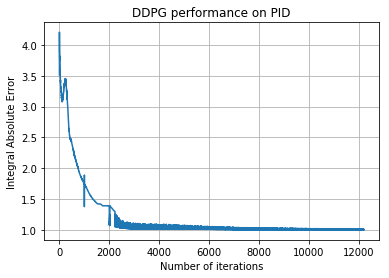

In [5]:
plt.plot(np.arange(0,12202), error_values[:12202])        
plt.xlabel("Number of iterations")
plt.ylabel("Integral Absolute Error")
plt.title("DDPG performance on PID")
plt.grid()
plt.show()

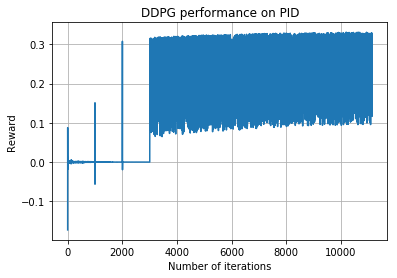

In [18]:
plt.plot(np.arange(11144), total_reward)
plt.xlabel("Number of iterations")
plt.ylabel("Reward")
plt.title("DDPG performance on PID")
plt.grid()

In [15]:
len(total_reward)

11144